In [1]:
#import glob
import os
import librosa
import librosa.display
import numpy as np
#from sklearn.model_selection import KFold
#from sklearn.metrics import accuracy_score
import torch
import torchvision
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
#import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pandas as pd
#import PIL
#from clearml import Task
#from clearml.storage import StorageManager
#import tensorflow as tf
#from tensorflow import keras

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:


path = '/content/drive/My Drive/sound Classification/'
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [4]:
# this is how csv file looks like
file_n='UrbanSound8K.csv'
csvData = pd.read_csv(path+file_n)
print(csvData.iloc[0, :])

slice_file_name    100032-3-0-0.wav
fsID                         100032
start                             0
end                        0.317551
salience                          1
fold                              5
classID                           3
class                      dog_bark
Name: 0, dtype: object


In [5]:
#listen a sample audio
import IPython.display as ipd
ipd.Audio(path+'/fold10/209672-3-8-0.wav')





sampling rate:  44100 Hz
bit depth:  16
number of channels:  2
duration:  4.0  second
number of samples:  176400
class:  2_children_playing


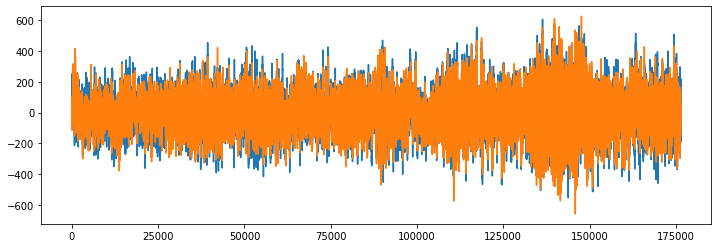

In [6]:
from scipy.io import wavfile as wav
import struct

def wav_plotter(full_path, class_label):   
    rate, wav_sample = wav.read(full_path)
    wave_file = open(full_path,"rb")
    riff_fmt = wave_file.read(36)
    bit_depth_string = riff_fmt[-2:]
    bit_depth = struct.unpack("H",bit_depth_string)[0]
    print('sampling rate: ',rate,'Hz')
    print('bit depth: ',bit_depth)
    print('number of channels: ',wav_sample.shape[1])
    print('duration: ',wav_sample.shape[0]/rate,' second')
    print('number of samples: ',len(wav_sample))
    print('class: ',class_label)
    plt.figure(figsize=(12, 4))
    plt.plot(wav_sample) 
    return ipd.Audio(full_path)

full_path=path+'/fold5/100263-2-0-36.wav'

audio_class='2_children_playing'
wav_plotter(full_path, audio_class)



sampling rate:  44100 Hz
bit depth:  16
number of channels:  2
duration:  4.0  second
number of samples:  176400
class:  3_dog_bark


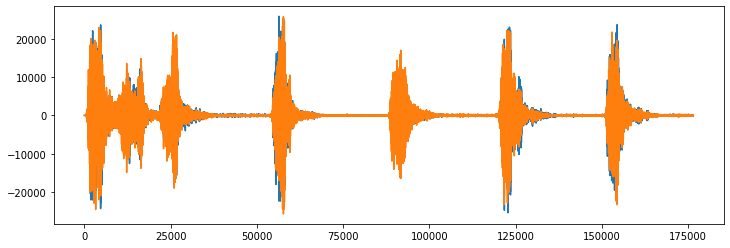

In [7]:
full_path=path+'/fold10/100795-3-1-0.wav'

audio_class='3_dog_bark'
wav_plotter(full_path, audio_class)


In [16]:

def create_spectrogram(filename,name,label,cname):
    plt.interactive(False)
    clip, sample_rate = librosa.load(filename, sr=None)
    fig = plt.figure(figsize=[0.8,0.8])
    #fig=plt.gcf()
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    S = librosa.feature.melspectrogram(y=clip, sr=sample_rate)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
    print(path)
    filename  = path +"images/Train/"+label+"_"+cname+ name + ".jpg"

    print(filename)
    
    plt.show(fig)
    
    
    ##fig.savefig('myimage.svg', format='svg', dpi=1200)
    fig.savefig(filename, dpi=100, bbox_inches='tight',pad_inches=0)
    ##plt.savefig(filename, dpi=400, bbox_inches='tight',pad_inches=0)
    plt.close()    
    fig.clf()
    plt.close(fig)
    plt.close('all')
    del filename,name,clip,sample_rate,fig,ax,S

def create_test_spectrogram(filename,name,label,cname):
    plt.interactive(False)
    clip, sample_rate = librosa.load(filename, sr=None)
    fig = plt.figure(figsize=[0.8,0.8])
    #fig=plt.gcf()
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    S = librosa.feature.melspectrogram(y=clip, sr=sample_rate)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
    print(path)
    
    filename  = path +"images/Test/"+label+"_"+cname+ name + ".jpg"  
    #print(path)
    #filename  = path +"Spectrograms/Test"+ name + ".jpg"

    print(filename)
    
    plt.show(fig)
    
    
    ##fig.savefig('myimage.svg', format='svg', dpi=100)
    fig.savefig(filename, dpi=100, bbox_inches='tight',pad_inches=0)
    ##plt.savefig(filename, dpi=400, bbox_inches='tight',pad_inches=0)
    plt.close()    
    fig.clf()
    plt.close(fig)
    plt.close('all')
    del filename,name,clip,sample_rate,fig,ax,S

csv_path = path+file_n
filepath = path

file_names = []
labels = []
folders = []
classname=[]

def init_data(csv_path,file_path,folderList):
        csvData = pd.read_csv(csv_path)
        #print()
        #initialize lists to hold file names, labels, and folder numbers
        #loop through the csv entries and only add entries from folders in the folder list
        for i in range(1,len(csvData)):#2981,3699,4279,7285,8148
            if csvData.iloc[i, 5] in folderList:
                file_names.append(csvData.iloc[i, 0]) # names of files
                labels.append(csvData.iloc[i, 6]) # class Ids
                folders.append(csvData.iloc[i, 5]) # folders folds
                classname.append(csvData.iloc[i, 7]) # class names e.g car_horn
                
  #      file_path = file_path
        folderList = folderList
        print(len(labels)) #generate spectrograms according to labels in respective folders not fold wise check if labels ==0 store in corresponding sound
        print(len(classname))
        print(len(folders))
        print(len(file_names))
        print(folderList)
        
        
        
        

def get_items(index):
        #format the file path and load the file
        #path = self.file_path + "/" + self.file_names[index]

#filename=path+'/fold10/209672-3-8-0.wav'
#name='209672-3-8-0'
  f=0
  for files in range(len(file_names)): #for all music files
     #   if(files==index):
          filename = filepath + "fold" + str(folders[f]) +"/" + file_names[f]
          name="/" + file_names[f]
          name=name.split('.')[0]
          label=str(labels[f])
          cname=classname[f]
          print(filename,label,cname,name,f)
          print(cname)
          print(filename)
          
          create_spectrogram(filename,name,label,cname)
          f=f+1

def get_test_items(index):
        #format the file path and load the file
        #path = self.file_path + "/" + self.file_names[index]

#filename=path+'/fold10/209672-3-8-0.wav'
#name='209672-3-8-0'
  f=0
  for files in range(len(file_names)): #for all music files in fold10
     #  if(folders[f]==index):
          filename = filepath + "fold" + str(folders[f]) +"/" + file_names[f]
          name="/" + file_names[f]
          name=name.split('.')[0]
          label=str(labels[f])
          cname=classname[f]
          print(filename,label,cname,name,f)
          #print(cname)
          print(filename)
          
          
          create_test_spectrogram(filename,name,label,cname)
          f=f+1


#initialize names
#init_data(csv_path, filepath, range(1,10))

#call folder by folder
#for folder in range(1,10):
#  print(folder, "Folder No")
#  get_items(folder)




In [ ]:
#​* 10-fold cross validation using the predefined folds: 
#train on data from 9 of the 10 predefined  folds and test on data from the remaining fold. 
#Repeat this process 10 times (each time using a different set of 9 out of the 10 folds for
# training and the remaining fold for testing). Finally report the average classification accuracy over all 10 experiments
# (as an average score + standard deviation, or, even better, as a boxplot).

837
837
837
837
range(10, 11)
/content/drive/My Drive/sound Classification/fold10/100648-1-0-0.wav 1 car_horn /100648-1-0-0 0
/content/drive/My Drive/sound Classification/fold10/100648-1-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/1_car_horn/100648-1-0-0.jpg


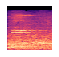

/content/drive/My Drive/sound Classification/fold10/100648-1-1-0.wav 1 car_horn /100648-1-1-0 1
/content/drive/My Drive/sound Classification/fold10/100648-1-1-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/1_car_horn/100648-1-1-0.jpg


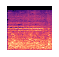

/content/drive/My Drive/sound Classification/fold10/100648-1-2-0.wav 1 car_horn /100648-1-2-0 2
/content/drive/My Drive/sound Classification/fold10/100648-1-2-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/1_car_horn/100648-1-2-0.jpg


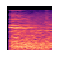

/content/drive/My Drive/sound Classification/fold10/100648-1-3-0.wav 1 car_horn /100648-1-3-0 3
/content/drive/My Drive/sound Classification/fold10/100648-1-3-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/1_car_horn/100648-1-3-0.jpg


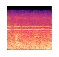

/content/drive/My Drive/sound Classification/fold10/100648-1-4-0.wav 1 car_horn /100648-1-4-0 4
/content/drive/My Drive/sound Classification/fold10/100648-1-4-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/1_car_horn/100648-1-4-0.jpg


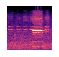

/content/drive/My Drive/sound Classification/fold10/100795-3-0-0.wav 3 dog_bark /100795-3-0-0 5
/content/drive/My Drive/sound Classification/fold10/100795-3-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/100795-3-0-0.jpg


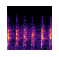

/content/drive/My Drive/sound Classification/fold10/100795-3-1-0.wav 3 dog_bark /100795-3-1-0 6
/content/drive/My Drive/sound Classification/fold10/100795-3-1-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/100795-3-1-0.jpg


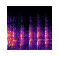

/content/drive/My Drive/sound Classification/fold10/100795-3-1-1.wav 3 dog_bark /100795-3-1-1 7
/content/drive/My Drive/sound Classification/fold10/100795-3-1-1.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/100795-3-1-1.jpg


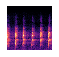

/content/drive/My Drive/sound Classification/fold10/100795-3-1-2.wav 3 dog_bark /100795-3-1-2 8
/content/drive/My Drive/sound Classification/fold10/100795-3-1-2.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/100795-3-1-2.jpg


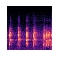

/content/drive/My Drive/sound Classification/fold10/101382-2-0-10.wav 2 children_playing /101382-2-0-10 9
/content/drive/My Drive/sound Classification/fold10/101382-2-0-10.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/101382-2-0-10.jpg


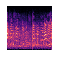

/content/drive/My Drive/sound Classification/fold10/101382-2-0-12.wav 2 children_playing /101382-2-0-12 10
/content/drive/My Drive/sound Classification/fold10/101382-2-0-12.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/101382-2-0-12.jpg


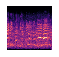

/content/drive/My Drive/sound Classification/fold10/101382-2-0-20.wav 2 children_playing /101382-2-0-20 11
/content/drive/My Drive/sound Classification/fold10/101382-2-0-20.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/101382-2-0-20.jpg


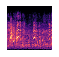

/content/drive/My Drive/sound Classification/fold10/101382-2-0-21.wav 2 children_playing /101382-2-0-21 12
/content/drive/My Drive/sound Classification/fold10/101382-2-0-21.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/101382-2-0-21.jpg


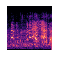

/content/drive/My Drive/sound Classification/fold10/101382-2-0-29.wav 2 children_playing /101382-2-0-29 13
/content/drive/My Drive/sound Classification/fold10/101382-2-0-29.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/101382-2-0-29.jpg


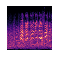

/content/drive/My Drive/sound Classification/fold10/101382-2-0-33.wav 2 children_playing /101382-2-0-33 14
/content/drive/My Drive/sound Classification/fold10/101382-2-0-33.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/101382-2-0-33.jpg


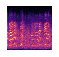

/content/drive/My Drive/sound Classification/fold10/101382-2-0-42.wav 2 children_playing /101382-2-0-42 15
/content/drive/My Drive/sound Classification/fold10/101382-2-0-42.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/101382-2-0-42.jpg


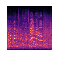

/content/drive/My Drive/sound Classification/fold10/101382-2-0-45.wav 2 children_playing /101382-2-0-45 16
/content/drive/My Drive/sound Classification/fold10/101382-2-0-45.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/101382-2-0-45.jpg


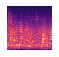

/content/drive/My Drive/sound Classification/fold10/102103-3-0-0.wav 3 dog_bark /102103-3-0-0 17
/content/drive/My Drive/sound Classification/fold10/102103-3-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/102103-3-0-0.jpg


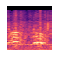

/content/drive/My Drive/sound Classification/fold10/102103-3-1-0.wav 3 dog_bark /102103-3-1-0 18
/content/drive/My Drive/sound Classification/fold10/102103-3-1-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/102103-3-1-0.jpg


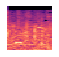

/content/drive/My Drive/sound Classification/fold10/102857-5-0-0.wav 5 engine_idling /102857-5-0-0 19
/content/drive/My Drive/sound Classification/fold10/102857-5-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/102857-5-0-0.jpg


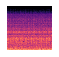

/content/drive/My Drive/sound Classification/fold10/102857-5-0-1.wav 5 engine_idling /102857-5-0-1 20
/content/drive/My Drive/sound Classification/fold10/102857-5-0-1.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/102857-5-0-1.jpg


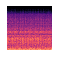

/content/drive/My Drive/sound Classification/fold10/102857-5-0-10.wav 5 engine_idling /102857-5-0-10 21
/content/drive/My Drive/sound Classification/fold10/102857-5-0-10.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/102857-5-0-10.jpg


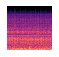

/content/drive/My Drive/sound Classification/fold10/102857-5-0-11.wav 5 engine_idling /102857-5-0-11 22
/content/drive/My Drive/sound Classification/fold10/102857-5-0-11.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/102857-5-0-11.jpg


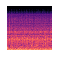

/content/drive/My Drive/sound Classification/fold10/102857-5-0-12.wav 5 engine_idling /102857-5-0-12 23
/content/drive/My Drive/sound Classification/fold10/102857-5-0-12.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/102857-5-0-12.jpg


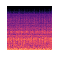

/content/drive/My Drive/sound Classification/fold10/102857-5-0-13.wav 5 engine_idling /102857-5-0-13 24
/content/drive/My Drive/sound Classification/fold10/102857-5-0-13.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/102857-5-0-13.jpg


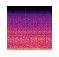

/content/drive/My Drive/sound Classification/fold10/102857-5-0-14.wav 5 engine_idling /102857-5-0-14 25
/content/drive/My Drive/sound Classification/fold10/102857-5-0-14.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/102857-5-0-14.jpg


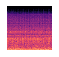

/content/drive/My Drive/sound Classification/fold10/102857-5-0-15.wav 5 engine_idling /102857-5-0-15 26
/content/drive/My Drive/sound Classification/fold10/102857-5-0-15.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/102857-5-0-15.jpg


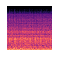

/content/drive/My Drive/sound Classification/fold10/102857-5-0-16.wav 5 engine_idling /102857-5-0-16 27
/content/drive/My Drive/sound Classification/fold10/102857-5-0-16.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/102857-5-0-16.jpg


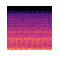

/content/drive/My Drive/sound Classification/fold10/102857-5-0-17.wav 5 engine_idling /102857-5-0-17 28
/content/drive/My Drive/sound Classification/fold10/102857-5-0-17.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/102857-5-0-17.jpg


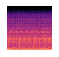

/content/drive/My Drive/sound Classification/fold10/102857-5-0-18.wav 5 engine_idling /102857-5-0-18 29
/content/drive/My Drive/sound Classification/fold10/102857-5-0-18.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/102857-5-0-18.jpg


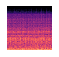

/content/drive/My Drive/sound Classification/fold10/102857-5-0-19.wav 5 engine_idling /102857-5-0-19 30
/content/drive/My Drive/sound Classification/fold10/102857-5-0-19.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/102857-5-0-19.jpg


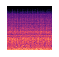

/content/drive/My Drive/sound Classification/fold10/102857-5-0-2.wav 5 engine_idling /102857-5-0-2 31
/content/drive/My Drive/sound Classification/fold10/102857-5-0-2.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/102857-5-0-2.jpg


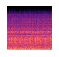

/content/drive/My Drive/sound Classification/fold10/102857-5-0-20.wav 5 engine_idling /102857-5-0-20 32
/content/drive/My Drive/sound Classification/fold10/102857-5-0-20.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/102857-5-0-20.jpg


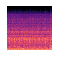

/content/drive/My Drive/sound Classification/fold10/102857-5-0-21.wav 5 engine_idling /102857-5-0-21 33
/content/drive/My Drive/sound Classification/fold10/102857-5-0-21.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/102857-5-0-21.jpg


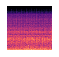

/content/drive/My Drive/sound Classification/fold10/102857-5-0-22.wav 5 engine_idling /102857-5-0-22 34
/content/drive/My Drive/sound Classification/fold10/102857-5-0-22.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/102857-5-0-22.jpg


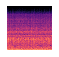

/content/drive/My Drive/sound Classification/fold10/102857-5-0-23.wav 5 engine_idling /102857-5-0-23 35
/content/drive/My Drive/sound Classification/fold10/102857-5-0-23.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/102857-5-0-23.jpg


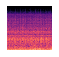

/content/drive/My Drive/sound Classification/fold10/102857-5-0-24.wav 5 engine_idling /102857-5-0-24 36
/content/drive/My Drive/sound Classification/fold10/102857-5-0-24.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/102857-5-0-24.jpg


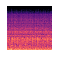

/content/drive/My Drive/sound Classification/fold10/102857-5-0-25.wav 5 engine_idling /102857-5-0-25 37
/content/drive/My Drive/sound Classification/fold10/102857-5-0-25.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/102857-5-0-25.jpg


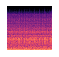

/content/drive/My Drive/sound Classification/fold10/102857-5-0-26.wav 5 engine_idling /102857-5-0-26 38
/content/drive/My Drive/sound Classification/fold10/102857-5-0-26.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/102857-5-0-26.jpg


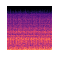

/content/drive/My Drive/sound Classification/fold10/102857-5-0-27.wav 5 engine_idling /102857-5-0-27 39
/content/drive/My Drive/sound Classification/fold10/102857-5-0-27.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/102857-5-0-27.jpg


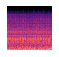

/content/drive/My Drive/sound Classification/fold10/102857-5-0-28.wav 5 engine_idling /102857-5-0-28 40
/content/drive/My Drive/sound Classification/fold10/102857-5-0-28.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/102857-5-0-28.jpg


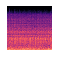

/content/drive/My Drive/sound Classification/fold10/102857-5-0-29.wav 5 engine_idling /102857-5-0-29 41
/content/drive/My Drive/sound Classification/fold10/102857-5-0-29.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/102857-5-0-29.jpg


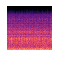

/content/drive/My Drive/sound Classification/fold10/102857-5-0-3.wav 5 engine_idling /102857-5-0-3 42
/content/drive/My Drive/sound Classification/fold10/102857-5-0-3.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/102857-5-0-3.jpg


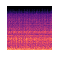

/content/drive/My Drive/sound Classification/fold10/102857-5-0-30.wav 5 engine_idling /102857-5-0-30 43
/content/drive/My Drive/sound Classification/fold10/102857-5-0-30.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/102857-5-0-30.jpg


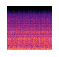

/content/drive/My Drive/sound Classification/fold10/102857-5-0-4.wav 5 engine_idling /102857-5-0-4 44
/content/drive/My Drive/sound Classification/fold10/102857-5-0-4.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/102857-5-0-4.jpg


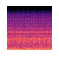

/content/drive/My Drive/sound Classification/fold10/102857-5-0-5.wav 5 engine_idling /102857-5-0-5 45
/content/drive/My Drive/sound Classification/fold10/102857-5-0-5.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/102857-5-0-5.jpg


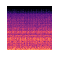

/content/drive/My Drive/sound Classification/fold10/102857-5-0-6.wav 5 engine_idling /102857-5-0-6 46
/content/drive/My Drive/sound Classification/fold10/102857-5-0-6.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/102857-5-0-6.jpg


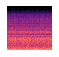

/content/drive/My Drive/sound Classification/fold10/102857-5-0-7.wav 5 engine_idling /102857-5-0-7 47
/content/drive/My Drive/sound Classification/fold10/102857-5-0-7.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/102857-5-0-7.jpg


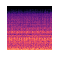

/content/drive/My Drive/sound Classification/fold10/102857-5-0-8.wav 5 engine_idling /102857-5-0-8 48
/content/drive/My Drive/sound Classification/fold10/102857-5-0-8.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/102857-5-0-8.jpg


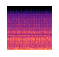

/content/drive/My Drive/sound Classification/fold10/102857-5-0-9.wav 5 engine_idling /102857-5-0-9 49
/content/drive/My Drive/sound Classification/fold10/102857-5-0-9.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/102857-5-0-9.jpg


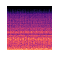

/content/drive/My Drive/sound Classification/fold10/103438-5-0-0.wav 5 engine_idling /103438-5-0-0 50
/content/drive/My Drive/sound Classification/fold10/103438-5-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/103438-5-0-0.jpg


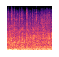

/content/drive/My Drive/sound Classification/fold10/103438-5-0-1.wav 5 engine_idling /103438-5-0-1 51
/content/drive/My Drive/sound Classification/fold10/103438-5-0-1.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/103438-5-0-1.jpg


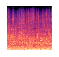

/content/drive/My Drive/sound Classification/fold10/103438-5-0-2.wav 5 engine_idling /103438-5-0-2 52
/content/drive/My Drive/sound Classification/fold10/103438-5-0-2.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/103438-5-0-2.jpg


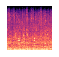

/content/drive/My Drive/sound Classification/fold10/106014-5-0-0.wav 5 engine_idling /106014-5-0-0 53
/content/drive/My Drive/sound Classification/fold10/106014-5-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/106014-5-0-0.jpg


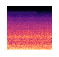

/content/drive/My Drive/sound Classification/fold10/106014-5-0-1.wav 5 engine_idling /106014-5-0-1 54
/content/drive/My Drive/sound Classification/fold10/106014-5-0-1.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/106014-5-0-1.jpg


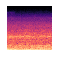

/content/drive/My Drive/sound Classification/fold10/106014-5-0-2.wav 5 engine_idling /106014-5-0-2 55
/content/drive/My Drive/sound Classification/fold10/106014-5-0-2.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/106014-5-0-2.jpg


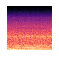

/content/drive/My Drive/sound Classification/fold10/106014-5-0-3.wav 5 engine_idling /106014-5-0-3 56
/content/drive/My Drive/sound Classification/fold10/106014-5-0-3.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/106014-5-0-3.jpg


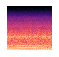

/content/drive/My Drive/sound Classification/fold10/106014-5-0-4.wav 5 engine_idling /106014-5-0-4 57
/content/drive/My Drive/sound Classification/fold10/106014-5-0-4.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/106014-5-0-4.jpg


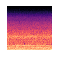

/content/drive/My Drive/sound Classification/fold10/115241-9-0-1.wav 9 street_music /115241-9-0-1 58
/content/drive/My Drive/sound Classification/fold10/115241-9-0-1.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/115241-9-0-1.jpg


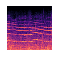

/content/drive/My Drive/sound Classification/fold10/115241-9-0-14.wav 9 street_music /115241-9-0-14 59
/content/drive/My Drive/sound Classification/fold10/115241-9-0-14.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/115241-9-0-14.jpg


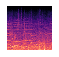

/content/drive/My Drive/sound Classification/fold10/115241-9-0-2.wav 9 street_music /115241-9-0-2 60
/content/drive/My Drive/sound Classification/fold10/115241-9-0-2.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/115241-9-0-2.jpg


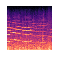

/content/drive/My Drive/sound Classification/fold10/115241-9-0-20.wav 9 street_music /115241-9-0-20 61
/content/drive/My Drive/sound Classification/fold10/115241-9-0-20.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/115241-9-0-20.jpg


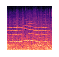

/content/drive/My Drive/sound Classification/fold10/115241-9-0-6.wav 9 street_music /115241-9-0-6 62
/content/drive/My Drive/sound Classification/fold10/115241-9-0-6.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/115241-9-0-6.jpg


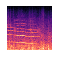

/content/drive/My Drive/sound Classification/fold10/115241-9-0-8.wav 9 street_music /115241-9-0-8 63
/content/drive/My Drive/sound Classification/fold10/115241-9-0-8.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/115241-9-0-8.jpg


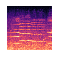

/content/drive/My Drive/sound Classification/fold10/115241-9-0-9.wav 9 street_music /115241-9-0-9 64
/content/drive/My Drive/sound Classification/fold10/115241-9-0-9.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/115241-9-0-9.jpg


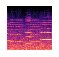

/content/drive/My Drive/sound Classification/fold10/115418-9-0-11.wav 9 street_music /115418-9-0-11 65
/content/drive/My Drive/sound Classification/fold10/115418-9-0-11.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/115418-9-0-11.jpg


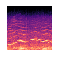

/content/drive/My Drive/sound Classification/fold10/115418-9-0-12.wav 9 street_music /115418-9-0-12 66
/content/drive/My Drive/sound Classification/fold10/115418-9-0-12.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/115418-9-0-12.jpg


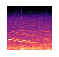

/content/drive/My Drive/sound Classification/fold10/115418-9-0-15.wav 9 street_music /115418-9-0-15 67
/content/drive/My Drive/sound Classification/fold10/115418-9-0-15.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/115418-9-0-15.jpg


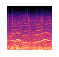

/content/drive/My Drive/sound Classification/fold10/115418-9-0-20.wav 9 street_music /115418-9-0-20 68
/content/drive/My Drive/sound Classification/fold10/115418-9-0-20.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/115418-9-0-20.jpg


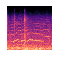

/content/drive/My Drive/sound Classification/fold10/115418-9-0-29.wav 9 street_music /115418-9-0-29 69
/content/drive/My Drive/sound Classification/fold10/115418-9-0-29.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/115418-9-0-29.jpg


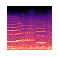

/content/drive/My Drive/sound Classification/fold10/115418-9-0-6.wav 9 street_music /115418-9-0-6 70
/content/drive/My Drive/sound Classification/fold10/115418-9-0-6.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/115418-9-0-6.jpg


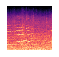

/content/drive/My Drive/sound Classification/fold10/11722-3-0-0.wav 3 dog_bark /11722-3-0-0 71
/content/drive/My Drive/sound Classification/fold10/11722-3-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/11722-3-0-0.jpg


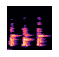

/content/drive/My Drive/sound Classification/fold10/11722-3-1-0.wav 3 dog_bark /11722-3-1-0 72
/content/drive/My Drive/sound Classification/fold10/11722-3-1-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/11722-3-1-0.jpg


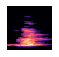

/content/drive/My Drive/sound Classification/fold10/117889-9-0-12.wav 9 street_music /117889-9-0-12 73
/content/drive/My Drive/sound Classification/fold10/117889-9-0-12.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/117889-9-0-12.jpg


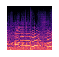

/content/drive/My Drive/sound Classification/fold10/117889-9-0-20.wav 9 street_music /117889-9-0-20 74
/content/drive/My Drive/sound Classification/fold10/117889-9-0-20.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/117889-9-0-20.jpg


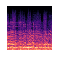

/content/drive/My Drive/sound Classification/fold10/117889-9-0-30.wav 9 street_music /117889-9-0-30 75
/content/drive/My Drive/sound Classification/fold10/117889-9-0-30.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/117889-9-0-30.jpg


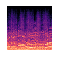

/content/drive/My Drive/sound Classification/fold10/117889-9-0-36.wav 9 street_music /117889-9-0-36 76
/content/drive/My Drive/sound Classification/fold10/117889-9-0-36.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/117889-9-0-36.jpg


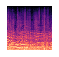

/content/drive/My Drive/sound Classification/fold10/117889-9-0-39.wav 9 street_music /117889-9-0-39 77
/content/drive/My Drive/sound Classification/fold10/117889-9-0-39.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/117889-9-0-39.jpg


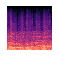

/content/drive/My Drive/sound Classification/fold10/117889-9-0-40.wav 9 street_music /117889-9-0-40 78
/content/drive/My Drive/sound Classification/fold10/117889-9-0-40.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/117889-9-0-40.jpg


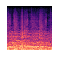

/content/drive/My Drive/sound Classification/fold10/118278-4-0-0.wav 4 drilling /118278-4-0-0 79
/content/drive/My Drive/sound Classification/fold10/118278-4-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/118278-4-0-0.jpg


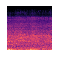

/content/drive/My Drive/sound Classification/fold10/118278-4-0-1.wav 4 drilling /118278-4-0-1 80
/content/drive/My Drive/sound Classification/fold10/118278-4-0-1.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/118278-4-0-1.jpg


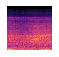

/content/drive/My Drive/sound Classification/fold10/118278-4-0-10.wav 4 drilling /118278-4-0-10 81
/content/drive/My Drive/sound Classification/fold10/118278-4-0-10.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/118278-4-0-10.jpg


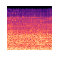

/content/drive/My Drive/sound Classification/fold10/118278-4-0-11.wav 4 drilling /118278-4-0-11 82
/content/drive/My Drive/sound Classification/fold10/118278-4-0-11.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/118278-4-0-11.jpg


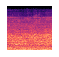

/content/drive/My Drive/sound Classification/fold10/118278-4-0-12.wav 4 drilling /118278-4-0-12 83
/content/drive/My Drive/sound Classification/fold10/118278-4-0-12.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/118278-4-0-12.jpg


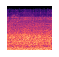

/content/drive/My Drive/sound Classification/fold10/118278-4-0-13.wav 4 drilling /118278-4-0-13 84
/content/drive/My Drive/sound Classification/fold10/118278-4-0-13.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/118278-4-0-13.jpg


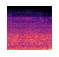

/content/drive/My Drive/sound Classification/fold10/118278-4-0-2.wav 4 drilling /118278-4-0-2 85
/content/drive/My Drive/sound Classification/fold10/118278-4-0-2.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/118278-4-0-2.jpg


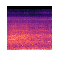

/content/drive/My Drive/sound Classification/fold10/118278-4-0-3.wav 4 drilling /118278-4-0-3 86
/content/drive/My Drive/sound Classification/fold10/118278-4-0-3.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/118278-4-0-3.jpg


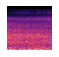

/content/drive/My Drive/sound Classification/fold10/118278-4-0-4.wav 4 drilling /118278-4-0-4 87
/content/drive/My Drive/sound Classification/fold10/118278-4-0-4.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/118278-4-0-4.jpg


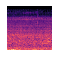

/content/drive/My Drive/sound Classification/fold10/118278-4-0-5.wav 4 drilling /118278-4-0-5 88
/content/drive/My Drive/sound Classification/fold10/118278-4-0-5.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/118278-4-0-5.jpg


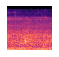

/content/drive/My Drive/sound Classification/fold10/118278-4-0-6.wav 4 drilling /118278-4-0-6 89
/content/drive/My Drive/sound Classification/fold10/118278-4-0-6.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/118278-4-0-6.jpg


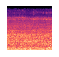

/content/drive/My Drive/sound Classification/fold10/118278-4-0-7.wav 4 drilling /118278-4-0-7 90
/content/drive/My Drive/sound Classification/fold10/118278-4-0-7.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/118278-4-0-7.jpg


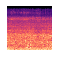

/content/drive/My Drive/sound Classification/fold10/118278-4-0-8.wav 4 drilling /118278-4-0-8 91
/content/drive/My Drive/sound Classification/fold10/118278-4-0-8.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/118278-4-0-8.jpg


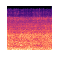

/content/drive/My Drive/sound Classification/fold10/118278-4-0-9.wav 4 drilling /118278-4-0-9 92
/content/drive/My Drive/sound Classification/fold10/118278-4-0-9.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/118278-4-0-9.jpg


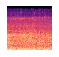

/content/drive/My Drive/sound Classification/fold10/118558-5-0-0.wav 5 engine_idling /118558-5-0-0 93
/content/drive/My Drive/sound Classification/fold10/118558-5-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/118558-5-0-0.jpg


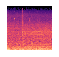

/content/drive/My Drive/sound Classification/fold10/118558-5-0-1.wav 5 engine_idling /118558-5-0-1 94
/content/drive/My Drive/sound Classification/fold10/118558-5-0-1.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/118558-5-0-1.jpg


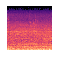

/content/drive/My Drive/sound Classification/fold10/118558-5-0-2.wav 5 engine_idling /118558-5-0-2 95
/content/drive/My Drive/sound Classification/fold10/118558-5-0-2.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/118558-5-0-2.jpg


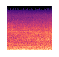

/content/drive/My Drive/sound Classification/fold10/118558-5-1-0.wav 5 engine_idling /118558-5-1-0 96
/content/drive/My Drive/sound Classification/fold10/118558-5-1-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/118558-5-1-0.jpg


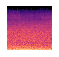

/content/drive/My Drive/sound Classification/fold10/118558-5-1-1.wav 5 engine_idling /118558-5-1-1 97
/content/drive/My Drive/sound Classification/fold10/118558-5-1-1.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/118558-5-1-1.jpg


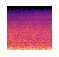

/content/drive/My Drive/sound Classification/fold10/118558-5-1-2.wav 5 engine_idling /118558-5-1-2 98
/content/drive/My Drive/sound Classification/fold10/118558-5-1-2.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/118558-5-1-2.jpg


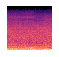

/content/drive/My Drive/sound Classification/fold10/118558-5-2-0.wav 5 engine_idling /118558-5-2-0 99
/content/drive/My Drive/sound Classification/fold10/118558-5-2-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/118558-5-2-0.jpg


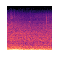

/content/drive/My Drive/sound Classification/fold10/118558-5-2-1.wav 5 engine_idling /118558-5-2-1 100
/content/drive/My Drive/sound Classification/fold10/118558-5-2-1.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/118558-5-2-1.jpg


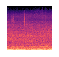

/content/drive/My Drive/sound Classification/fold10/118558-5-2-2.wav 5 engine_idling /118558-5-2-2 101
/content/drive/My Drive/sound Classification/fold10/118558-5-2-2.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/118558-5-2-2.jpg


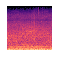

/content/drive/My Drive/sound Classification/fold10/118558-5-2-3.wav 5 engine_idling /118558-5-2-3 102
/content/drive/My Drive/sound Classification/fold10/118558-5-2-3.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/118558-5-2-3.jpg


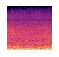

/content/drive/My Drive/sound Classification/fold10/119067-0-0-0.wav 0 air_conditioner /119067-0-0-0 103
/content/drive/My Drive/sound Classification/fold10/119067-0-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/119067-0-0-0.jpg


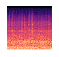

/content/drive/My Drive/sound Classification/fold10/119067-0-0-1.wav 0 air_conditioner /119067-0-0-1 104
/content/drive/My Drive/sound Classification/fold10/119067-0-0-1.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/119067-0-0-1.jpg


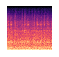

/content/drive/My Drive/sound Classification/fold10/119067-0-0-2.wav 0 air_conditioner /119067-0-0-2 105
/content/drive/My Drive/sound Classification/fold10/119067-0-0-2.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/119067-0-0-2.jpg


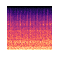

/content/drive/My Drive/sound Classification/fold10/128240-3-0-1.wav 3 dog_bark /128240-3-0-1 106
/content/drive/My Drive/sound Classification/fold10/128240-3-0-1.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/128240-3-0-1.jpg


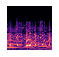

/content/drive/My Drive/sound Classification/fold10/128240-3-0-20.wav 3 dog_bark /128240-3-0-20 107
/content/drive/My Drive/sound Classification/fold10/128240-3-0-20.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/128240-3-0-20.jpg


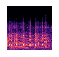

/content/drive/My Drive/sound Classification/fold10/128240-3-0-39.wav 3 dog_bark /128240-3-0-39 108
/content/drive/My Drive/sound Classification/fold10/128240-3-0-39.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/128240-3-0-39.jpg


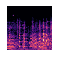

/content/drive/My Drive/sound Classification/fold10/128240-3-0-42.wav 3 dog_bark /128240-3-0-42 109
/content/drive/My Drive/sound Classification/fold10/128240-3-0-42.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/128240-3-0-42.jpg


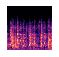

/content/drive/My Drive/sound Classification/fold10/128470-3-0-0.wav 3 dog_bark /128470-3-0-0 110
/content/drive/My Drive/sound Classification/fold10/128470-3-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/128470-3-0-0.jpg


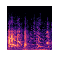

/content/drive/My Drive/sound Classification/fold10/128470-3-0-1.wav 3 dog_bark /128470-3-0-1 111
/content/drive/My Drive/sound Classification/fold10/128470-3-0-1.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/128470-3-0-1.jpg


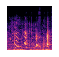

/content/drive/My Drive/sound Classification/fold10/128470-3-0-5.wav 3 dog_bark /128470-3-0-5 112
/content/drive/My Drive/sound Classification/fold10/128470-3-0-5.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/128470-3-0-5.jpg


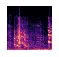

/content/drive/My Drive/sound Classification/fold10/128470-3-0-8.wav 3 dog_bark /128470-3-0-8 113
/content/drive/My Drive/sound Classification/fold10/128470-3-0-8.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/128470-3-0-8.jpg


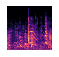

/content/drive/My Drive/sound Classification/fold10/129750-2-0-3.wav 2 children_playing /129750-2-0-3 114
/content/drive/My Drive/sound Classification/fold10/129750-2-0-3.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/129750-2-0-3.jpg


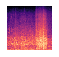

/content/drive/My Drive/sound Classification/fold10/129750-2-0-34.wav 2 children_playing /129750-2-0-34 115
/content/drive/My Drive/sound Classification/fold10/129750-2-0-34.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/129750-2-0-34.jpg


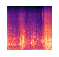

/content/drive/My Drive/sound Classification/fold10/129750-2-0-36.wav 2 children_playing /129750-2-0-36 116
/content/drive/My Drive/sound Classification/fold10/129750-2-0-36.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/129750-2-0-36.jpg


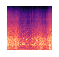

/content/drive/My Drive/sound Classification/fold10/129750-2-0-37.wav 2 children_playing /129750-2-0-37 117
/content/drive/My Drive/sound Classification/fold10/129750-2-0-37.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/129750-2-0-37.jpg


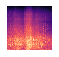

/content/drive/My Drive/sound Classification/fold10/129750-2-0-4.wav 2 children_playing /129750-2-0-4 118
/content/drive/My Drive/sound Classification/fold10/129750-2-0-4.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/129750-2-0-4.jpg


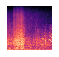

/content/drive/My Drive/sound Classification/fold10/129750-2-0-45.wav 2 children_playing /129750-2-0-45 119
/content/drive/My Drive/sound Classification/fold10/129750-2-0-45.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/129750-2-0-45.jpg


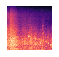

/content/drive/My Drive/sound Classification/fold10/129750-2-0-46.wav 2 children_playing /129750-2-0-46 120
/content/drive/My Drive/sound Classification/fold10/129750-2-0-46.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/129750-2-0-46.jpg


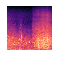

/content/drive/My Drive/sound Classification/fold10/129750-2-0-48.wav 2 children_playing /129750-2-0-48 121
/content/drive/My Drive/sound Classification/fold10/129750-2-0-48.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/129750-2-0-48.jpg


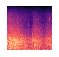

/content/drive/My Drive/sound Classification/fold10/136558-9-0-1.wav 9 street_music /136558-9-0-1 122
/content/drive/My Drive/sound Classification/fold10/136558-9-0-1.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/136558-9-0-1.jpg


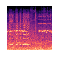

/content/drive/My Drive/sound Classification/fold10/136558-9-0-2.wav 9 street_music /136558-9-0-2 123
/content/drive/My Drive/sound Classification/fold10/136558-9-0-2.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/136558-9-0-2.jpg


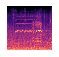

/content/drive/My Drive/sound Classification/fold10/136558-9-1-10.wav 9 street_music /136558-9-1-10 124
/content/drive/My Drive/sound Classification/fold10/136558-9-1-10.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/136558-9-1-10.jpg


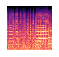

/content/drive/My Drive/sound Classification/fold10/136558-9-1-21.wav 9 street_music /136558-9-1-21 125
/content/drive/My Drive/sound Classification/fold10/136558-9-1-21.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/136558-9-1-21.jpg


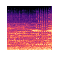

/content/drive/My Drive/sound Classification/fold10/136558-9-1-26.wav 9 street_music /136558-9-1-26 126
/content/drive/My Drive/sound Classification/fold10/136558-9-1-26.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/136558-9-1-26.jpg


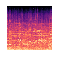

/content/drive/My Drive/sound Classification/fold10/136558-9-1-39.wav 9 street_music /136558-9-1-39 127
/content/drive/My Drive/sound Classification/fold10/136558-9-1-39.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/136558-9-1-39.jpg


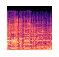

/content/drive/My Drive/sound Classification/fold10/138017-9-0-2.wav 9 street_music /138017-9-0-2 128
/content/drive/My Drive/sound Classification/fold10/138017-9-0-2.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/138017-9-0-2.jpg


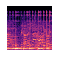

/content/drive/My Drive/sound Classification/fold10/138017-9-0-9.wav 9 street_music /138017-9-0-9 129
/content/drive/My Drive/sound Classification/fold10/138017-9-0-9.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/138017-9-0-9.jpg


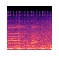

/content/drive/My Drive/sound Classification/fold10/138017-9-1-10.wav 9 street_music /138017-9-1-10 130
/content/drive/My Drive/sound Classification/fold10/138017-9-1-10.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/138017-9-1-10.jpg


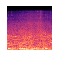

/content/drive/My Drive/sound Classification/fold10/138017-9-1-16.wav 9 street_music /138017-9-1-16 131
/content/drive/My Drive/sound Classification/fold10/138017-9-1-16.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/138017-9-1-16.jpg


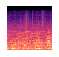

/content/drive/My Drive/sound Classification/fold10/138017-9-1-4.wav 9 street_music /138017-9-1-4 132
/content/drive/My Drive/sound Classification/fold10/138017-9-1-4.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/138017-9-1-4.jpg


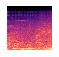

/content/drive/My Drive/sound Classification/fold10/138017-9-1-6.wav 9 street_music /138017-9-1-6 133
/content/drive/My Drive/sound Classification/fold10/138017-9-1-6.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/138017-9-1-6.jpg


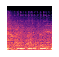

/content/drive/My Drive/sound Classification/fold10/141240-5-0-0.wav 5 engine_idling /141240-5-0-0 134
/content/drive/My Drive/sound Classification/fold10/141240-5-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/141240-5-0-0.jpg


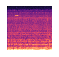

/content/drive/My Drive/sound Classification/fold10/141240-5-1-0.wav 5 engine_idling /141240-5-1-0 135
/content/drive/My Drive/sound Classification/fold10/141240-5-1-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/141240-5-1-0.jpg


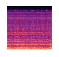

/content/drive/My Drive/sound Classification/fold10/142641-3-0-0.wav 3 dog_bark /142641-3-0-0 136
/content/drive/My Drive/sound Classification/fold10/142641-3-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/142641-3-0-0.jpg


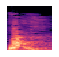

/content/drive/My Drive/sound Classification/fold10/14468-3-0-2.wav 3 dog_bark /14468-3-0-2 137
/content/drive/My Drive/sound Classification/fold10/14468-3-0-2.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/14468-3-0-2.jpg


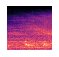

/content/drive/My Drive/sound Classification/fold10/14468-3-0-3.wav 3 dog_bark /14468-3-0-3 138
/content/drive/My Drive/sound Classification/fold10/14468-3-0-3.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/14468-3-0-3.jpg


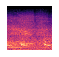

/content/drive/My Drive/sound Classification/fold10/14468-3-1-0.wav 3 dog_bark /14468-3-1-0 139
/content/drive/My Drive/sound Classification/fold10/14468-3-1-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/14468-3-1-0.jpg


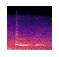

/content/drive/My Drive/sound Classification/fold10/14468-3-5-0.wav 3 dog_bark /14468-3-5-0 140
/content/drive/My Drive/sound Classification/fold10/14468-3-5-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/14468-3-5-0.jpg


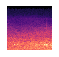

/content/drive/My Drive/sound Classification/fold10/14470-2-0-10.wav 2 children_playing /14470-2-0-10 141
/content/drive/My Drive/sound Classification/fold10/14470-2-0-10.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/14470-2-0-10.jpg


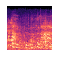

/content/drive/My Drive/sound Classification/fold10/14470-2-0-14.wav 2 children_playing /14470-2-0-14 142
/content/drive/My Drive/sound Classification/fold10/14470-2-0-14.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/14470-2-0-14.jpg


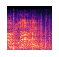

/content/drive/My Drive/sound Classification/fold10/14470-2-0-21.wav 2 children_playing /14470-2-0-21 143
/content/drive/My Drive/sound Classification/fold10/14470-2-0-21.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/14470-2-0-21.jpg


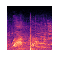

/content/drive/My Drive/sound Classification/fold10/14470-2-0-4.wav 2 children_playing /14470-2-0-4 144
/content/drive/My Drive/sound Classification/fold10/14470-2-0-4.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/14470-2-0-4.jpg


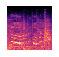

/content/drive/My Drive/sound Classification/fold10/14470-2-0-56.wav 2 children_playing /14470-2-0-56 145
/content/drive/My Drive/sound Classification/fold10/14470-2-0-56.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/14470-2-0-56.jpg


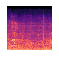

/content/drive/My Drive/sound Classification/fold10/14470-2-0-65.wav 2 children_playing /14470-2-0-65 146
/content/drive/My Drive/sound Classification/fold10/14470-2-0-65.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/14470-2-0-65.jpg


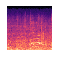

/content/drive/My Drive/sound Classification/fold10/14470-2-0-70.wav 2 children_playing /14470-2-0-70 147
/content/drive/My Drive/sound Classification/fold10/14470-2-0-70.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/14470-2-0-70.jpg


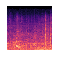

/content/drive/My Drive/sound Classification/fold10/14470-2-0-72.wav 2 children_playing /14470-2-0-72 148
/content/drive/My Drive/sound Classification/fold10/14470-2-0-72.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/14470-2-0-72.jpg


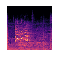

/content/drive/My Drive/sound Classification/fold10/146244-4-0-0.wav 4 drilling /146244-4-0-0 149
/content/drive/My Drive/sound Classification/fold10/146244-4-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/146244-4-0-0.jpg


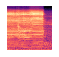

/content/drive/My Drive/sound Classification/fold10/147491-9-0-0.wav 9 street_music /147491-9-0-0 150
/content/drive/My Drive/sound Classification/fold10/147491-9-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/147491-9-0-0.jpg


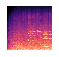

/content/drive/My Drive/sound Classification/fold10/147491-9-0-5.wav 9 street_music /147491-9-0-5 151
/content/drive/My Drive/sound Classification/fold10/147491-9-0-5.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/147491-9-0-5.jpg


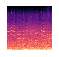

/content/drive/My Drive/sound Classification/fold10/147491-9-2-10.wav 9 street_music /147491-9-2-10 152
/content/drive/My Drive/sound Classification/fold10/147491-9-2-10.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/147491-9-2-10.jpg


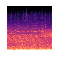

/content/drive/My Drive/sound Classification/fold10/147491-9-2-25.wav 9 street_music /147491-9-2-25 153
/content/drive/My Drive/sound Classification/fold10/147491-9-2-25.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/147491-9-2-25.jpg


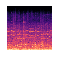

/content/drive/My Drive/sound Classification/fold10/147491-9-2-32.wav 9 street_music /147491-9-2-32 154
/content/drive/My Drive/sound Classification/fold10/147491-9-2-32.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/147491-9-2-32.jpg


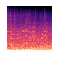

/content/drive/My Drive/sound Classification/fold10/147491-9-2-6.wav 9 street_music /147491-9-2-6 155
/content/drive/My Drive/sound Classification/fold10/147491-9-2-6.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/147491-9-2-6.jpg


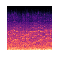

/content/drive/My Drive/sound Classification/fold10/155241-9-0-50.wav 9 street_music /155241-9-0-50 156
/content/drive/My Drive/sound Classification/fold10/155241-9-0-50.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/155241-9-0-50.jpg


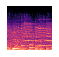

/content/drive/My Drive/sound Classification/fold10/155241-9-0-56.wav 9 street_music /155241-9-0-56 157
/content/drive/My Drive/sound Classification/fold10/155241-9-0-56.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/155241-9-0-56.jpg


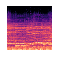

/content/drive/My Drive/sound Classification/fold10/155241-9-0-69.wav 9 street_music /155241-9-0-69 158
/content/drive/My Drive/sound Classification/fold10/155241-9-0-69.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/155241-9-0-69.jpg


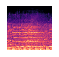

/content/drive/My Drive/sound Classification/fold10/155241-9-0-79.wav 9 street_music /155241-9-0-79 159
/content/drive/My Drive/sound Classification/fold10/155241-9-0-79.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/155241-9-0-79.jpg


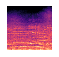

/content/drive/My Drive/sound Classification/fold10/155241-9-0-8.wav 9 street_music /155241-9-0-8 160
/content/drive/My Drive/sound Classification/fold10/155241-9-0-8.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/155241-9-0-8.jpg


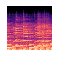

/content/drive/My Drive/sound Classification/fold10/155241-9-0-88.wav 9 street_music /155241-9-0-88 161
/content/drive/My Drive/sound Classification/fold10/155241-9-0-88.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/155241-9-0-88.jpg


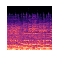

/content/drive/My Drive/sound Classification/fold10/155262-2-0-101.wav 2 children_playing /155262-2-0-101 162
/content/drive/My Drive/sound Classification/fold10/155262-2-0-101.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/155262-2-0-101.jpg


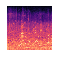

/content/drive/My Drive/sound Classification/fold10/155262-2-0-11.wav 2 children_playing /155262-2-0-11 163
/content/drive/My Drive/sound Classification/fold10/155262-2-0-11.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/155262-2-0-11.jpg


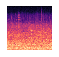

/content/drive/My Drive/sound Classification/fold10/155262-2-0-15.wav 2 children_playing /155262-2-0-15 164
/content/drive/My Drive/sound Classification/fold10/155262-2-0-15.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/155262-2-0-15.jpg


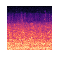

/content/drive/My Drive/sound Classification/fold10/155262-2-0-2.wav 2 children_playing /155262-2-0-2 165
/content/drive/My Drive/sound Classification/fold10/155262-2-0-2.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/155262-2-0-2.jpg


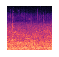

/content/drive/My Drive/sound Classification/fold10/155262-2-0-21.wav 2 children_playing /155262-2-0-21 166
/content/drive/My Drive/sound Classification/fold10/155262-2-0-21.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/155262-2-0-21.jpg


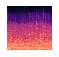

/content/drive/My Drive/sound Classification/fold10/155262-2-0-48.wav 2 children_playing /155262-2-0-48 167
/content/drive/My Drive/sound Classification/fold10/155262-2-0-48.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/155262-2-0-48.jpg


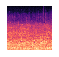

/content/drive/My Drive/sound Classification/fold10/155262-2-0-58.wav 2 children_playing /155262-2-0-58 168
/content/drive/My Drive/sound Classification/fold10/155262-2-0-58.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/155262-2-0-58.jpg


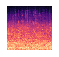

/content/drive/My Drive/sound Classification/fold10/155262-2-0-63.wav 2 children_playing /155262-2-0-63 169
/content/drive/My Drive/sound Classification/fold10/155262-2-0-63.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/155262-2-0-63.jpg


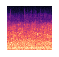

/content/drive/My Drive/sound Classification/fold10/155280-2-0-10.wav 2 children_playing /155280-2-0-10 170
/content/drive/My Drive/sound Classification/fold10/155280-2-0-10.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/155280-2-0-10.jpg


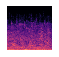

/content/drive/My Drive/sound Classification/fold10/155280-2-0-11.wav 2 children_playing /155280-2-0-11 171
/content/drive/My Drive/sound Classification/fold10/155280-2-0-11.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/155280-2-0-11.jpg


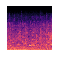

/content/drive/My Drive/sound Classification/fold10/155280-2-0-13.wav 2 children_playing /155280-2-0-13 172
/content/drive/My Drive/sound Classification/fold10/155280-2-0-13.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/155280-2-0-13.jpg


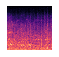

/content/drive/My Drive/sound Classification/fold10/155280-2-0-15.wav 2 children_playing /155280-2-0-15 173
/content/drive/My Drive/sound Classification/fold10/155280-2-0-15.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/155280-2-0-15.jpg


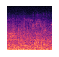

/content/drive/My Drive/sound Classification/fold10/155280-2-0-3.wav 2 children_playing /155280-2-0-3 174
/content/drive/My Drive/sound Classification/fold10/155280-2-0-3.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/155280-2-0-3.jpg


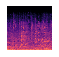

/content/drive/My Drive/sound Classification/fold10/155280-2-0-5.wav 2 children_playing /155280-2-0-5 175
/content/drive/My Drive/sound Classification/fold10/155280-2-0-5.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/155280-2-0-5.jpg


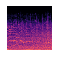

/content/drive/My Drive/sound Classification/fold10/155280-2-0-6.wav 2 children_playing /155280-2-0-6 176
/content/drive/My Drive/sound Classification/fold10/155280-2-0-6.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/155280-2-0-6.jpg


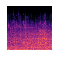

/content/drive/My Drive/sound Classification/fold10/155280-2-0-7.wav 2 children_playing /155280-2-0-7 177
/content/drive/My Drive/sound Classification/fold10/155280-2-0-7.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/155280-2-0-7.jpg


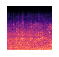

/content/drive/My Drive/sound Classification/fold10/155311-3-0-0.wav 3 dog_bark /155311-3-0-0 178
/content/drive/My Drive/sound Classification/fold10/155311-3-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/155311-3-0-0.jpg


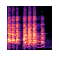

/content/drive/My Drive/sound Classification/fold10/15544-5-0-0.wav 5 engine_idling /15544-5-0-0 179
/content/drive/My Drive/sound Classification/fold10/15544-5-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/15544-5-0-0.jpg


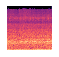

/content/drive/My Drive/sound Classification/fold10/15544-5-0-1.wav 5 engine_idling /15544-5-0-1 180
/content/drive/My Drive/sound Classification/fold10/15544-5-0-1.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/15544-5-0-1.jpg


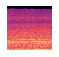

/content/drive/My Drive/sound Classification/fold10/15544-5-0-10.wav 5 engine_idling /15544-5-0-10 181
/content/drive/My Drive/sound Classification/fold10/15544-5-0-10.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/15544-5-0-10.jpg


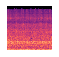

/content/drive/My Drive/sound Classification/fold10/15544-5-0-11.wav 5 engine_idling /15544-5-0-11 182
/content/drive/My Drive/sound Classification/fold10/15544-5-0-11.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/15544-5-0-11.jpg


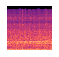

/content/drive/My Drive/sound Classification/fold10/15544-5-0-12.wav 5 engine_idling /15544-5-0-12 183
/content/drive/My Drive/sound Classification/fold10/15544-5-0-12.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/15544-5-0-12.jpg


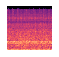

/content/drive/My Drive/sound Classification/fold10/15544-5-0-13.wav 5 engine_idling /15544-5-0-13 184
/content/drive/My Drive/sound Classification/fold10/15544-5-0-13.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/15544-5-0-13.jpg


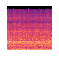

/content/drive/My Drive/sound Classification/fold10/15544-5-0-14.wav 5 engine_idling /15544-5-0-14 185
/content/drive/My Drive/sound Classification/fold10/15544-5-0-14.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/15544-5-0-14.jpg


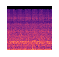

/content/drive/My Drive/sound Classification/fold10/15544-5-0-15.wav 5 engine_idling /15544-5-0-15 186
/content/drive/My Drive/sound Classification/fold10/15544-5-0-15.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/15544-5-0-15.jpg


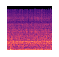

/content/drive/My Drive/sound Classification/fold10/15544-5-0-16.wav 5 engine_idling /15544-5-0-16 187
/content/drive/My Drive/sound Classification/fold10/15544-5-0-16.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/15544-5-0-16.jpg


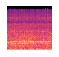

/content/drive/My Drive/sound Classification/fold10/15544-5-0-17.wav 5 engine_idling /15544-5-0-17 188
/content/drive/My Drive/sound Classification/fold10/15544-5-0-17.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/15544-5-0-17.jpg


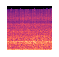

/content/drive/My Drive/sound Classification/fold10/15544-5-0-18.wav 5 engine_idling /15544-5-0-18 189
/content/drive/My Drive/sound Classification/fold10/15544-5-0-18.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/15544-5-0-18.jpg


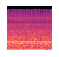

/content/drive/My Drive/sound Classification/fold10/15544-5-0-19.wav 5 engine_idling /15544-5-0-19 190
/content/drive/My Drive/sound Classification/fold10/15544-5-0-19.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/15544-5-0-19.jpg


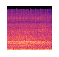

/content/drive/My Drive/sound Classification/fold10/15544-5-0-2.wav 5 engine_idling /15544-5-0-2 191
/content/drive/My Drive/sound Classification/fold10/15544-5-0-2.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/15544-5-0-2.jpg


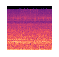

/content/drive/My Drive/sound Classification/fold10/15544-5-0-3.wav 5 engine_idling /15544-5-0-3 192
/content/drive/My Drive/sound Classification/fold10/15544-5-0-3.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/15544-5-0-3.jpg


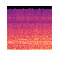

/content/drive/My Drive/sound Classification/fold10/15544-5-0-4.wav 5 engine_idling /15544-5-0-4 193
/content/drive/My Drive/sound Classification/fold10/15544-5-0-4.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/15544-5-0-4.jpg


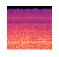

/content/drive/My Drive/sound Classification/fold10/15544-5-0-5.wav 5 engine_idling /15544-5-0-5 194
/content/drive/My Drive/sound Classification/fold10/15544-5-0-5.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/15544-5-0-5.jpg


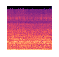

/content/drive/My Drive/sound Classification/fold10/15544-5-0-6.wav 5 engine_idling /15544-5-0-6 195
/content/drive/My Drive/sound Classification/fold10/15544-5-0-6.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/15544-5-0-6.jpg


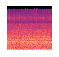

/content/drive/My Drive/sound Classification/fold10/15544-5-0-7.wav 5 engine_idling /15544-5-0-7 196
/content/drive/My Drive/sound Classification/fold10/15544-5-0-7.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/15544-5-0-7.jpg


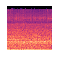

/content/drive/My Drive/sound Classification/fold10/15544-5-0-8.wav 5 engine_idling /15544-5-0-8 197
/content/drive/My Drive/sound Classification/fold10/15544-5-0-8.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/15544-5-0-8.jpg


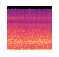

/content/drive/My Drive/sound Classification/fold10/15544-5-0-9.wav 5 engine_idling /15544-5-0-9 198
/content/drive/My Drive/sound Classification/fold10/15544-5-0-9.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/15544-5-0-9.jpg


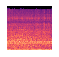

/content/drive/My Drive/sound Classification/fold10/157207-6-0-0.wav 6 gun_shot /157207-6-0-0 199
/content/drive/My Drive/sound Classification/fold10/157207-6-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/6_gun_shot/157207-6-0-0.jpg


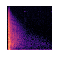

/content/drive/My Drive/sound Classification/fold10/157207-6-1-0.wav 6 gun_shot /157207-6-1-0 200
/content/drive/My Drive/sound Classification/fold10/157207-6-1-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/6_gun_shot/157207-6-1-0.jpg


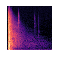

/content/drive/My Drive/sound Classification/fold10/157207-6-10-0.wav 6 gun_shot /157207-6-10-0 201
/content/drive/My Drive/sound Classification/fold10/157207-6-10-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/6_gun_shot/157207-6-10-0.jpg


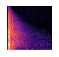

/content/drive/My Drive/sound Classification/fold10/157207-6-2-0.wav 6 gun_shot /157207-6-2-0 202
/content/drive/My Drive/sound Classification/fold10/157207-6-2-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/6_gun_shot/157207-6-2-0.jpg


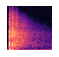

/content/drive/My Drive/sound Classification/fold10/157207-6-3-0.wav 6 gun_shot /157207-6-3-0 203
/content/drive/My Drive/sound Classification/fold10/157207-6-3-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/6_gun_shot/157207-6-3-0.jpg


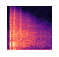

/content/drive/My Drive/sound Classification/fold10/157207-6-4-0.wav 6 gun_shot /157207-6-4-0 204
/content/drive/My Drive/sound Classification/fold10/157207-6-4-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/6_gun_shot/157207-6-4-0.jpg


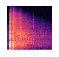

/content/drive/My Drive/sound Classification/fold10/157207-6-5-0.wav 6 gun_shot /157207-6-5-0 205
/content/drive/My Drive/sound Classification/fold10/157207-6-5-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/6_gun_shot/157207-6-5-0.jpg


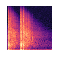

/content/drive/My Drive/sound Classification/fold10/157207-6-6-0.wav 6 gun_shot /157207-6-6-0 206
/content/drive/My Drive/sound Classification/fold10/157207-6-6-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/6_gun_shot/157207-6-6-0.jpg


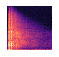

/content/drive/My Drive/sound Classification/fold10/157207-6-7-0.wav 6 gun_shot /157207-6-7-0 207
/content/drive/My Drive/sound Classification/fold10/157207-6-7-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/6_gun_shot/157207-6-7-0.jpg


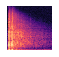

/content/drive/My Drive/sound Classification/fold10/157207-6-8-0.wav 6 gun_shot /157207-6-8-0 208
/content/drive/My Drive/sound Classification/fold10/157207-6-8-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/6_gun_shot/157207-6-8-0.jpg


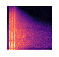

/content/drive/My Drive/sound Classification/fold10/157207-6-9-0.wav 6 gun_shot /157207-6-9-0 209
/content/drive/My Drive/sound Classification/fold10/157207-6-9-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/6_gun_shot/157207-6-9-0.jpg


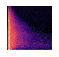

/content/drive/My Drive/sound Classification/fold10/157800-6-0-0.wav 6 gun_shot /157800-6-0-0 210
/content/drive/My Drive/sound Classification/fold10/157800-6-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/6_gun_shot/157800-6-0-0.jpg


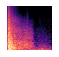

/content/drive/My Drive/sound Classification/fold10/159709-6-0-0.wav 6 gun_shot /159709-6-0-0 211
/content/drive/My Drive/sound Classification/fold10/159709-6-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/6_gun_shot/159709-6-0-0.jpg


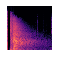

/content/drive/My Drive/sound Classification/fold10/159742-8-0-0.wav 8 siren /159742-8-0-0 212
/content/drive/My Drive/sound Classification/fold10/159742-8-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/159742-8-0-0.jpg


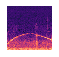

/content/drive/My Drive/sound Classification/fold10/159742-8-0-1.wav 8 siren /159742-8-0-1 213
/content/drive/My Drive/sound Classification/fold10/159742-8-0-1.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/159742-8-0-1.jpg


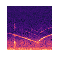

/content/drive/My Drive/sound Classification/fold10/159742-8-0-10.wav 8 siren /159742-8-0-10 214
/content/drive/My Drive/sound Classification/fold10/159742-8-0-10.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/159742-8-0-10.jpg


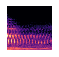

/content/drive/My Drive/sound Classification/fold10/159742-8-0-11.wav 8 siren /159742-8-0-11 215
/content/drive/My Drive/sound Classification/fold10/159742-8-0-11.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/159742-8-0-11.jpg


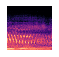

/content/drive/My Drive/sound Classification/fold10/159742-8-0-12.wav 8 siren /159742-8-0-12 216
/content/drive/My Drive/sound Classification/fold10/159742-8-0-12.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/159742-8-0-12.jpg


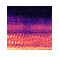

/content/drive/My Drive/sound Classification/fold10/159742-8-0-13.wav 8 siren /159742-8-0-13 217
/content/drive/My Drive/sound Classification/fold10/159742-8-0-13.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/159742-8-0-13.jpg


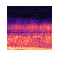

/content/drive/My Drive/sound Classification/fold10/159742-8-0-14.wav 8 siren /159742-8-0-14 218
/content/drive/My Drive/sound Classification/fold10/159742-8-0-14.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/159742-8-0-14.jpg


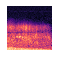

/content/drive/My Drive/sound Classification/fold10/159742-8-0-2.wav 8 siren /159742-8-0-2 219
/content/drive/My Drive/sound Classification/fold10/159742-8-0-2.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/159742-8-0-2.jpg


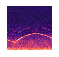

/content/drive/My Drive/sound Classification/fold10/159742-8-0-3.wav 8 siren /159742-8-0-3 220
/content/drive/My Drive/sound Classification/fold10/159742-8-0-3.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/159742-8-0-3.jpg


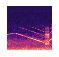

/content/drive/My Drive/sound Classification/fold10/159742-8-0-4.wav 8 siren /159742-8-0-4 221
/content/drive/My Drive/sound Classification/fold10/159742-8-0-4.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/159742-8-0-4.jpg


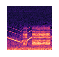

/content/drive/My Drive/sound Classification/fold10/159742-8-0-5.wav 8 siren /159742-8-0-5 222
/content/drive/My Drive/sound Classification/fold10/159742-8-0-5.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/159742-8-0-5.jpg


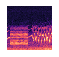

/content/drive/My Drive/sound Classification/fold10/159742-8-0-6.wav 8 siren /159742-8-0-6 223
/content/drive/My Drive/sound Classification/fold10/159742-8-0-6.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/159742-8-0-6.jpg


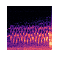

/content/drive/My Drive/sound Classification/fold10/159742-8-0-7.wav 8 siren /159742-8-0-7 224
/content/drive/My Drive/sound Classification/fold10/159742-8-0-7.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/159742-8-0-7.jpg


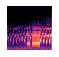

/content/drive/My Drive/sound Classification/fold10/159742-8-0-8.wav 8 siren /159742-8-0-8 225
/content/drive/My Drive/sound Classification/fold10/159742-8-0-8.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/159742-8-0-8.jpg


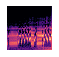

/content/drive/My Drive/sound Classification/fold10/159742-8-0-9.wav 8 siren /159742-8-0-9 226
/content/drive/My Drive/sound Classification/fold10/159742-8-0-9.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/159742-8-0-9.jpg


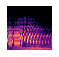

/content/drive/My Drive/sound Classification/fold10/162134-7-0-0.wav 7 jackhammer /162134-7-0-0 227
/content/drive/My Drive/sound Classification/fold10/162134-7-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/162134-7-0-0.jpg


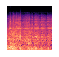

/content/drive/My Drive/sound Classification/fold10/162134-7-0-1.wav 7 jackhammer /162134-7-0-1 228
/content/drive/My Drive/sound Classification/fold10/162134-7-0-1.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/162134-7-0-1.jpg


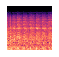

/content/drive/My Drive/sound Classification/fold10/162134-7-0-2.wav 7 jackhammer /162134-7-0-2 229
/content/drive/My Drive/sound Classification/fold10/162134-7-0-2.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/162134-7-0-2.jpg


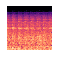

/content/drive/My Drive/sound Classification/fold10/162134-7-1-0.wav 7 jackhammer /162134-7-1-0 230
/content/drive/My Drive/sound Classification/fold10/162134-7-1-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/162134-7-1-0.jpg


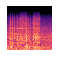

/content/drive/My Drive/sound Classification/fold10/162134-7-10-0.wav 7 jackhammer /162134-7-10-0 231
/content/drive/My Drive/sound Classification/fold10/162134-7-10-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/162134-7-10-0.jpg


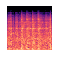

/content/drive/My Drive/sound Classification/fold10/162134-7-10-1.wav 7 jackhammer /162134-7-10-1 232
/content/drive/My Drive/sound Classification/fold10/162134-7-10-1.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/162134-7-10-1.jpg


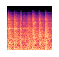

/content/drive/My Drive/sound Classification/fold10/162134-7-10-2.wav 7 jackhammer /162134-7-10-2 233
/content/drive/My Drive/sound Classification/fold10/162134-7-10-2.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/162134-7-10-2.jpg


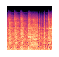

/content/drive/My Drive/sound Classification/fold10/162134-7-10-3.wav 7 jackhammer /162134-7-10-3 234
/content/drive/My Drive/sound Classification/fold10/162134-7-10-3.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/162134-7-10-3.jpg


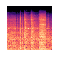

/content/drive/My Drive/sound Classification/fold10/162134-7-11-0.wav 7 jackhammer /162134-7-11-0 235
/content/drive/My Drive/sound Classification/fold10/162134-7-11-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/162134-7-11-0.jpg


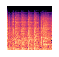

/content/drive/My Drive/sound Classification/fold10/162134-7-11-1.wav 7 jackhammer /162134-7-11-1 236
/content/drive/My Drive/sound Classification/fold10/162134-7-11-1.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/162134-7-11-1.jpg


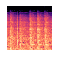

/content/drive/My Drive/sound Classification/fold10/162134-7-11-2.wav 7 jackhammer /162134-7-11-2 237
/content/drive/My Drive/sound Classification/fold10/162134-7-11-2.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/162134-7-11-2.jpg


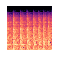

/content/drive/My Drive/sound Classification/fold10/162134-7-11-3.wav 7 jackhammer /162134-7-11-3 238
/content/drive/My Drive/sound Classification/fold10/162134-7-11-3.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/162134-7-11-3.jpg


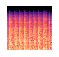

/content/drive/My Drive/sound Classification/fold10/162134-7-11-4.wav 7 jackhammer /162134-7-11-4 239
/content/drive/My Drive/sound Classification/fold10/162134-7-11-4.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/162134-7-11-4.jpg


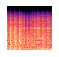

/content/drive/My Drive/sound Classification/fold10/162134-7-11-5.wav 7 jackhammer /162134-7-11-5 240
/content/drive/My Drive/sound Classification/fold10/162134-7-11-5.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/162134-7-11-5.jpg


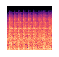

/content/drive/My Drive/sound Classification/fold10/162134-7-11-6.wav 7 jackhammer /162134-7-11-6 241
/content/drive/My Drive/sound Classification/fold10/162134-7-11-6.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/162134-7-11-6.jpg


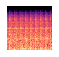

/content/drive/My Drive/sound Classification/fold10/162134-7-11-7.wav 7 jackhammer /162134-7-11-7 242
/content/drive/My Drive/sound Classification/fold10/162134-7-11-7.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/162134-7-11-7.jpg


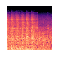

/content/drive/My Drive/sound Classification/fold10/162134-7-12-0.wav 7 jackhammer /162134-7-12-0 243
/content/drive/My Drive/sound Classification/fold10/162134-7-12-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/162134-7-12-0.jpg


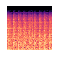

/content/drive/My Drive/sound Classification/fold10/162134-7-12-1.wav 7 jackhammer /162134-7-12-1 244
/content/drive/My Drive/sound Classification/fold10/162134-7-12-1.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/162134-7-12-1.jpg


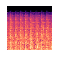

/content/drive/My Drive/sound Classification/fold10/162134-7-12-2.wav 7 jackhammer /162134-7-12-2 245
/content/drive/My Drive/sound Classification/fold10/162134-7-12-2.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/162134-7-12-2.jpg


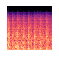

/content/drive/My Drive/sound Classification/fold10/162134-7-12-3.wav 7 jackhammer /162134-7-12-3 246
/content/drive/My Drive/sound Classification/fold10/162134-7-12-3.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/162134-7-12-3.jpg


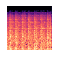

/content/drive/My Drive/sound Classification/fold10/162134-7-12-4.wav 7 jackhammer /162134-7-12-4 247
/content/drive/My Drive/sound Classification/fold10/162134-7-12-4.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/162134-7-12-4.jpg


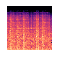

/content/drive/My Drive/sound Classification/fold10/162134-7-13-0.wav 7 jackhammer /162134-7-13-0 248
/content/drive/My Drive/sound Classification/fold10/162134-7-13-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/162134-7-13-0.jpg


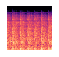

/content/drive/My Drive/sound Classification/fold10/162134-7-13-1.wav 7 jackhammer /162134-7-13-1 249
/content/drive/My Drive/sound Classification/fold10/162134-7-13-1.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/162134-7-13-1.jpg


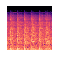

/content/drive/My Drive/sound Classification/fold10/162134-7-13-2.wav 7 jackhammer /162134-7-13-2 250
/content/drive/My Drive/sound Classification/fold10/162134-7-13-2.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/162134-7-13-2.jpg


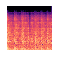

/content/drive/My Drive/sound Classification/fold10/162134-7-13-3.wav 7 jackhammer /162134-7-13-3 251
/content/drive/My Drive/sound Classification/fold10/162134-7-13-3.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/162134-7-13-3.jpg


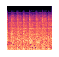

/content/drive/My Drive/sound Classification/fold10/162134-7-13-4.wav 7 jackhammer /162134-7-13-4 252
/content/drive/My Drive/sound Classification/fold10/162134-7-13-4.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/162134-7-13-4.jpg


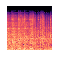

/content/drive/My Drive/sound Classification/fold10/162134-7-14-0.wav 7 jackhammer /162134-7-14-0 253
/content/drive/My Drive/sound Classification/fold10/162134-7-14-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/162134-7-14-0.jpg


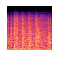

/content/drive/My Drive/sound Classification/fold10/162134-7-14-1.wav 7 jackhammer /162134-7-14-1 254
/content/drive/My Drive/sound Classification/fold10/162134-7-14-1.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/162134-7-14-1.jpg


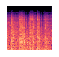

/content/drive/My Drive/sound Classification/fold10/162134-7-14-2.wav 7 jackhammer /162134-7-14-2 255
/content/drive/My Drive/sound Classification/fold10/162134-7-14-2.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/162134-7-14-2.jpg


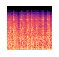

/content/drive/My Drive/sound Classification/fold10/162134-7-15-0.wav 7 jackhammer /162134-7-15-0 256
/content/drive/My Drive/sound Classification/fold10/162134-7-15-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/162134-7-15-0.jpg


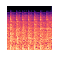

/content/drive/My Drive/sound Classification/fold10/162134-7-15-1.wav 7 jackhammer /162134-7-15-1 257
/content/drive/My Drive/sound Classification/fold10/162134-7-15-1.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/162134-7-15-1.jpg


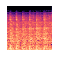

/content/drive/My Drive/sound Classification/fold10/162134-7-15-2.wav 7 jackhammer /162134-7-15-2 258
/content/drive/My Drive/sound Classification/fold10/162134-7-15-2.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/162134-7-15-2.jpg


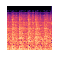

/content/drive/My Drive/sound Classification/fold10/162134-7-15-3.wav 7 jackhammer /162134-7-15-3 259
/content/drive/My Drive/sound Classification/fold10/162134-7-15-3.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/162134-7-15-3.jpg


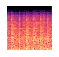

/content/drive/My Drive/sound Classification/fold10/162134-7-15-4.wav 7 jackhammer /162134-7-15-4 260
/content/drive/My Drive/sound Classification/fold10/162134-7-15-4.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/162134-7-15-4.jpg


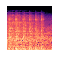

/content/drive/My Drive/sound Classification/fold10/162134-7-16-0.wav 7 jackhammer /162134-7-16-0 261
/content/drive/My Drive/sound Classification/fold10/162134-7-16-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/162134-7-16-0.jpg


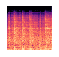

/content/drive/My Drive/sound Classification/fold10/162134-7-16-1.wav 7 jackhammer /162134-7-16-1 262
/content/drive/My Drive/sound Classification/fold10/162134-7-16-1.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/162134-7-16-1.jpg


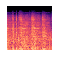

/content/drive/My Drive/sound Classification/fold10/162134-7-17-0.wav 7 jackhammer /162134-7-17-0 263
/content/drive/My Drive/sound Classification/fold10/162134-7-17-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/162134-7-17-0.jpg


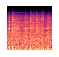

/content/drive/My Drive/sound Classification/fold10/162134-7-17-1.wav 7 jackhammer /162134-7-17-1 264
/content/drive/My Drive/sound Classification/fold10/162134-7-17-1.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/162134-7-17-1.jpg


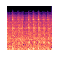

/content/drive/My Drive/sound Classification/fold10/162134-7-17-2.wav 7 jackhammer /162134-7-17-2 265
/content/drive/My Drive/sound Classification/fold10/162134-7-17-2.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/162134-7-17-2.jpg


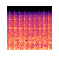

/content/drive/My Drive/sound Classification/fold10/162134-7-17-3.wav 7 jackhammer /162134-7-17-3 266
/content/drive/My Drive/sound Classification/fold10/162134-7-17-3.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/162134-7-17-3.jpg


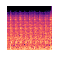

/content/drive/My Drive/sound Classification/fold10/162134-7-17-4.wav 7 jackhammer /162134-7-17-4 267
/content/drive/My Drive/sound Classification/fold10/162134-7-17-4.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/162134-7-17-4.jpg


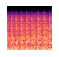

/content/drive/My Drive/sound Classification/fold10/162134-7-2-0.wav 7 jackhammer /162134-7-2-0 268
/content/drive/My Drive/sound Classification/fold10/162134-7-2-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/162134-7-2-0.jpg


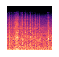

/content/drive/My Drive/sound Classification/fold10/162134-7-3-0.wav 7 jackhammer /162134-7-3-0 269
/content/drive/My Drive/sound Classification/fold10/162134-7-3-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/162134-7-3-0.jpg


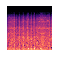

/content/drive/My Drive/sound Classification/fold10/162134-7-4-0.wav 7 jackhammer /162134-7-4-0 270
/content/drive/My Drive/sound Classification/fold10/162134-7-4-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/162134-7-4-0.jpg


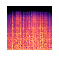

/content/drive/My Drive/sound Classification/fold10/162134-7-5-0.wav 7 jackhammer /162134-7-5-0 271
/content/drive/My Drive/sound Classification/fold10/162134-7-5-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/162134-7-5-0.jpg


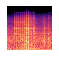

/content/drive/My Drive/sound Classification/fold10/162134-7-6-0.wav 7 jackhammer /162134-7-6-0 272
/content/drive/My Drive/sound Classification/fold10/162134-7-6-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/162134-7-6-0.jpg


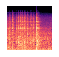

/content/drive/My Drive/sound Classification/fold10/162134-7-7-0.wav 7 jackhammer /162134-7-7-0 273
/content/drive/My Drive/sound Classification/fold10/162134-7-7-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/162134-7-7-0.jpg


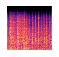

/content/drive/My Drive/sound Classification/fold10/162134-7-7-1.wav 7 jackhammer /162134-7-7-1 274
/content/drive/My Drive/sound Classification/fold10/162134-7-7-1.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/162134-7-7-1.jpg


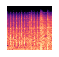

/content/drive/My Drive/sound Classification/fold10/162134-7-8-0.wav 7 jackhammer /162134-7-8-0 275
/content/drive/My Drive/sound Classification/fold10/162134-7-8-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/162134-7-8-0.jpg


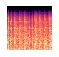

/content/drive/My Drive/sound Classification/fold10/162134-7-8-1.wav 7 jackhammer /162134-7-8-1 276
/content/drive/My Drive/sound Classification/fold10/162134-7-8-1.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/162134-7-8-1.jpg


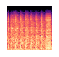

/content/drive/My Drive/sound Classification/fold10/162134-7-8-2.wav 7 jackhammer /162134-7-8-2 277
/content/drive/My Drive/sound Classification/fold10/162134-7-8-2.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/162134-7-8-2.jpg


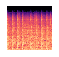

/content/drive/My Drive/sound Classification/fold10/162134-7-8-3.wav 7 jackhammer /162134-7-8-3 278
/content/drive/My Drive/sound Classification/fold10/162134-7-8-3.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/162134-7-8-3.jpg


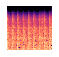

/content/drive/My Drive/sound Classification/fold10/162134-7-8-4.wav 7 jackhammer /162134-7-8-4 279
/content/drive/My Drive/sound Classification/fold10/162134-7-8-4.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/162134-7-8-4.jpg


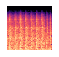

/content/drive/My Drive/sound Classification/fold10/162134-7-8-5.wav 7 jackhammer /162134-7-8-5 280
/content/drive/My Drive/sound Classification/fold10/162134-7-8-5.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/162134-7-8-5.jpg


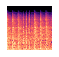

/content/drive/My Drive/sound Classification/fold10/162134-7-8-6.wav 7 jackhammer /162134-7-8-6 281
/content/drive/My Drive/sound Classification/fold10/162134-7-8-6.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/162134-7-8-6.jpg


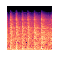

/content/drive/My Drive/sound Classification/fold10/162134-7-8-7.wav 7 jackhammer /162134-7-8-7 282
/content/drive/My Drive/sound Classification/fold10/162134-7-8-7.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/162134-7-8-7.jpg


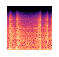

/content/drive/My Drive/sound Classification/fold10/162134-7-9-0.wav 7 jackhammer /162134-7-9-0 283
/content/drive/My Drive/sound Classification/fold10/162134-7-9-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/162134-7-9-0.jpg


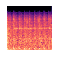

/content/drive/My Drive/sound Classification/fold10/162134-7-9-1.wav 7 jackhammer /162134-7-9-1 284
/content/drive/My Drive/sound Classification/fold10/162134-7-9-1.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/162134-7-9-1.jpg


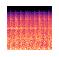

/content/drive/My Drive/sound Classification/fold10/162134-7-9-2.wav 7 jackhammer /162134-7-9-2 285
/content/drive/My Drive/sound Classification/fold10/162134-7-9-2.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/162134-7-9-2.jpg


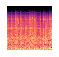

/content/drive/My Drive/sound Classification/fold10/162134-7-9-3.wav 7 jackhammer /162134-7-9-3 286
/content/drive/My Drive/sound Classification/fold10/162134-7-9-3.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/162134-7-9-3.jpg


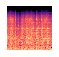

/content/drive/My Drive/sound Classification/fold10/162134-7-9-4.wav 7 jackhammer /162134-7-9-4 287
/content/drive/My Drive/sound Classification/fold10/162134-7-9-4.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/162134-7-9-4.jpg


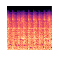

/content/drive/My Drive/sound Classification/fold10/162148-3-0-0.wav 3 dog_bark /162148-3-0-0 288
/content/drive/My Drive/sound Classification/fold10/162148-3-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/162148-3-0-0.jpg


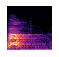

/content/drive/My Drive/sound Classification/fold10/163459-3-0-0.wav 3 dog_bark /163459-3-0-0 289
/content/drive/My Drive/sound Classification/fold10/163459-3-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/163459-3-0-0.jpg


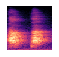

/content/drive/My Drive/sound Classification/fold10/164194-2-0-10.wav 2 children_playing /164194-2-0-10 290
/content/drive/My Drive/sound Classification/fold10/164194-2-0-10.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/164194-2-0-10.jpg


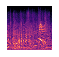

/content/drive/My Drive/sound Classification/fold10/164194-2-0-11.wav 2 children_playing /164194-2-0-11 291
/content/drive/My Drive/sound Classification/fold10/164194-2-0-11.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/164194-2-0-11.jpg


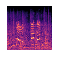

/content/drive/My Drive/sound Classification/fold10/164194-2-0-14.wav 2 children_playing /164194-2-0-14 292
/content/drive/My Drive/sound Classification/fold10/164194-2-0-14.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/164194-2-0-14.jpg


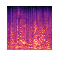

/content/drive/My Drive/sound Classification/fold10/164194-2-0-18.wav 2 children_playing /164194-2-0-18 293
/content/drive/My Drive/sound Classification/fold10/164194-2-0-18.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/164194-2-0-18.jpg


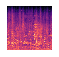

/content/drive/My Drive/sound Classification/fold10/164194-2-0-24.wav 2 children_playing /164194-2-0-24 294
/content/drive/My Drive/sound Classification/fold10/164194-2-0-24.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/164194-2-0-24.jpg


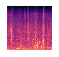

/content/drive/My Drive/sound Classification/fold10/164194-2-0-26.wav 2 children_playing /164194-2-0-26 295
/content/drive/My Drive/sound Classification/fold10/164194-2-0-26.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/164194-2-0-26.jpg


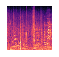

/content/drive/My Drive/sound Classification/fold10/164194-2-0-29.wav 2 children_playing /164194-2-0-29 296
/content/drive/My Drive/sound Classification/fold10/164194-2-0-29.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/164194-2-0-29.jpg


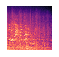

/content/drive/My Drive/sound Classification/fold10/164194-2-0-7.wav 2 children_playing /164194-2-0-7 297
/content/drive/My Drive/sound Classification/fold10/164194-2-0-7.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/164194-2-0-7.jpg


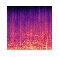

/content/drive/My Drive/sound Classification/fold10/164377-9-0-16.wav 9 street_music /164377-9-0-16 298
/content/drive/My Drive/sound Classification/fold10/164377-9-0-16.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/164377-9-0-16.jpg


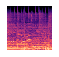

/content/drive/My Drive/sound Classification/fold10/164377-9-1-15.wav 9 street_music /164377-9-1-15 299
/content/drive/My Drive/sound Classification/fold10/164377-9-1-15.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/164377-9-1-15.jpg


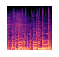

/content/drive/My Drive/sound Classification/fold10/164377-9-1-3.wav 9 street_music /164377-9-1-3 300
/content/drive/My Drive/sound Classification/fold10/164377-9-1-3.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/164377-9-1-3.jpg


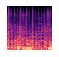

/content/drive/My Drive/sound Classification/fold10/164377-9-1-36.wav 9 street_music /164377-9-1-36 301
/content/drive/My Drive/sound Classification/fold10/164377-9-1-36.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/164377-9-1-36.jpg


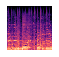

/content/drive/My Drive/sound Classification/fold10/164377-9-1-43.wav 9 street_music /164377-9-1-43 302
/content/drive/My Drive/sound Classification/fold10/164377-9-1-43.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/164377-9-1-43.jpg


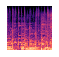

/content/drive/My Drive/sound Classification/fold10/164377-9-1-50.wav 9 street_music /164377-9-1-50 303
/content/drive/My Drive/sound Classification/fold10/164377-9-1-50.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/164377-9-1-50.jpg


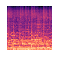

/content/drive/My Drive/sound Classification/fold10/164377-9-1-92.wav 9 street_music /164377-9-1-92 304
/content/drive/My Drive/sound Classification/fold10/164377-9-1-92.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/164377-9-1-92.jpg


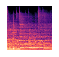

/content/drive/My Drive/sound Classification/fold10/164646-6-0-0.wav 6 gun_shot /164646-6-0-0 305
/content/drive/My Drive/sound Classification/fold10/164646-6-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/6_gun_shot/164646-6-0-0.jpg


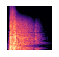

/content/drive/My Drive/sound Classification/fold10/165166-8-0-0.wav 8 siren /165166-8-0-0 306
/content/drive/My Drive/sound Classification/fold10/165166-8-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/165166-8-0-0.jpg


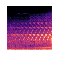

/content/drive/My Drive/sound Classification/fold10/165166-8-0-1.wav 8 siren /165166-8-0-1 307
/content/drive/My Drive/sound Classification/fold10/165166-8-0-1.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/165166-8-0-1.jpg


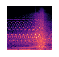

/content/drive/My Drive/sound Classification/fold10/165166-8-0-2.wav 8 siren /165166-8-0-2 308
/content/drive/My Drive/sound Classification/fold10/165166-8-0-2.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/165166-8-0-2.jpg


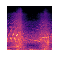

/content/drive/My Drive/sound Classification/fold10/165166-8-0-3.wav 8 siren /165166-8-0-3 309
/content/drive/My Drive/sound Classification/fold10/165166-8-0-3.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/165166-8-0-3.jpg


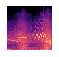

/content/drive/My Drive/sound Classification/fold10/165166-8-0-4.wav 8 siren /165166-8-0-4 310
/content/drive/My Drive/sound Classification/fold10/165166-8-0-4.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/165166-8-0-4.jpg


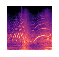

/content/drive/My Drive/sound Classification/fold10/165166-8-0-5.wav 8 siren /165166-8-0-5 311
/content/drive/My Drive/sound Classification/fold10/165166-8-0-5.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/165166-8-0-5.jpg


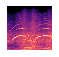

/content/drive/My Drive/sound Classification/fold10/165166-8-0-6.wav 8 siren /165166-8-0-6 312
/content/drive/My Drive/sound Classification/fold10/165166-8-0-6.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/165166-8-0-6.jpg


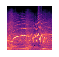

/content/drive/My Drive/sound Classification/fold10/165166-8-0-7.wav 8 siren /165166-8-0-7 313
/content/drive/My Drive/sound Classification/fold10/165166-8-0-7.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/165166-8-0-7.jpg


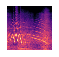

/content/drive/My Drive/sound Classification/fold10/165166-8-0-8.wav 8 siren /165166-8-0-8 314
/content/drive/My Drive/sound Classification/fold10/165166-8-0-8.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/165166-8-0-8.jpg


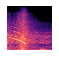

/content/drive/My Drive/sound Classification/fold10/165640-4-0-0.wav 4 drilling /165640-4-0-0 315
/content/drive/My Drive/sound Classification/fold10/165640-4-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/165640-4-0-0.jpg


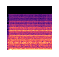

/content/drive/My Drive/sound Classification/fold10/165640-4-0-1.wav 4 drilling /165640-4-0-1 316
/content/drive/My Drive/sound Classification/fold10/165640-4-0-1.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/165640-4-0-1.jpg


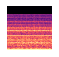

/content/drive/My Drive/sound Classification/fold10/165640-4-0-2.wav 4 drilling /165640-4-0-2 317
/content/drive/My Drive/sound Classification/fold10/165640-4-0-2.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/165640-4-0-2.jpg


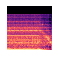

/content/drive/My Drive/sound Classification/fold10/167464-0-0-0.wav 0 air_conditioner /167464-0-0-0 318
/content/drive/My Drive/sound Classification/fold10/167464-0-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/167464-0-0-0.jpg


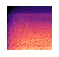

/content/drive/My Drive/sound Classification/fold10/167464-0-0-1.wav 0 air_conditioner /167464-0-0-1 319
/content/drive/My Drive/sound Classification/fold10/167464-0-0-1.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/167464-0-0-1.jpg


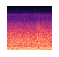

/content/drive/My Drive/sound Classification/fold10/167464-0-0-10.wav 0 air_conditioner /167464-0-0-10 320
/content/drive/My Drive/sound Classification/fold10/167464-0-0-10.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/167464-0-0-10.jpg


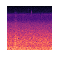

/content/drive/My Drive/sound Classification/fold10/167464-0-0-11.wav 0 air_conditioner /167464-0-0-11 321
/content/drive/My Drive/sound Classification/fold10/167464-0-0-11.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/167464-0-0-11.jpg


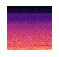

/content/drive/My Drive/sound Classification/fold10/167464-0-0-12.wav 0 air_conditioner /167464-0-0-12 322
/content/drive/My Drive/sound Classification/fold10/167464-0-0-12.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/167464-0-0-12.jpg


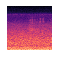

/content/drive/My Drive/sound Classification/fold10/167464-0-0-13.wav 0 air_conditioner /167464-0-0-13 323
/content/drive/My Drive/sound Classification/fold10/167464-0-0-13.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/167464-0-0-13.jpg


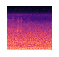

/content/drive/My Drive/sound Classification/fold10/167464-0-0-14.wav 0 air_conditioner /167464-0-0-14 324
/content/drive/My Drive/sound Classification/fold10/167464-0-0-14.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/167464-0-0-14.jpg


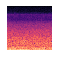

/content/drive/My Drive/sound Classification/fold10/167464-0-0-15.wav 0 air_conditioner /167464-0-0-15 325
/content/drive/My Drive/sound Classification/fold10/167464-0-0-15.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/167464-0-0-15.jpg


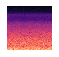

/content/drive/My Drive/sound Classification/fold10/167464-0-0-16.wav 0 air_conditioner /167464-0-0-16 326
/content/drive/My Drive/sound Classification/fold10/167464-0-0-16.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/167464-0-0-16.jpg


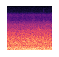

/content/drive/My Drive/sound Classification/fold10/167464-0-0-17.wav 0 air_conditioner /167464-0-0-17 327
/content/drive/My Drive/sound Classification/fold10/167464-0-0-17.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/167464-0-0-17.jpg


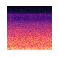

/content/drive/My Drive/sound Classification/fold10/167464-0-0-18.wav 0 air_conditioner /167464-0-0-18 328
/content/drive/My Drive/sound Classification/fold10/167464-0-0-18.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/167464-0-0-18.jpg


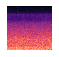

/content/drive/My Drive/sound Classification/fold10/167464-0-0-19.wav 0 air_conditioner /167464-0-0-19 329
/content/drive/My Drive/sound Classification/fold10/167464-0-0-19.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/167464-0-0-19.jpg


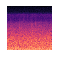

/content/drive/My Drive/sound Classification/fold10/167464-0-0-2.wav 0 air_conditioner /167464-0-0-2 330
/content/drive/My Drive/sound Classification/fold10/167464-0-0-2.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/167464-0-0-2.jpg


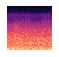

/content/drive/My Drive/sound Classification/fold10/167464-0-0-20.wav 0 air_conditioner /167464-0-0-20 331
/content/drive/My Drive/sound Classification/fold10/167464-0-0-20.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/167464-0-0-20.jpg


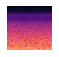

/content/drive/My Drive/sound Classification/fold10/167464-0-0-21.wav 0 air_conditioner /167464-0-0-21 332
/content/drive/My Drive/sound Classification/fold10/167464-0-0-21.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/167464-0-0-21.jpg


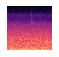

/content/drive/My Drive/sound Classification/fold10/167464-0-0-22.wav 0 air_conditioner /167464-0-0-22 333
/content/drive/My Drive/sound Classification/fold10/167464-0-0-22.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/167464-0-0-22.jpg


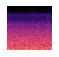

/content/drive/My Drive/sound Classification/fold10/167464-0-0-23.wav 0 air_conditioner /167464-0-0-23 334
/content/drive/My Drive/sound Classification/fold10/167464-0-0-23.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/167464-0-0-23.jpg


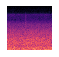

/content/drive/My Drive/sound Classification/fold10/167464-0-0-24.wav 0 air_conditioner /167464-0-0-24 335
/content/drive/My Drive/sound Classification/fold10/167464-0-0-24.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/167464-0-0-24.jpg


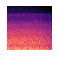

/content/drive/My Drive/sound Classification/fold10/167464-0-0-3.wav 0 air_conditioner /167464-0-0-3 336
/content/drive/My Drive/sound Classification/fold10/167464-0-0-3.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/167464-0-0-3.jpg


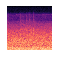

/content/drive/My Drive/sound Classification/fold10/167464-0-0-4.wav 0 air_conditioner /167464-0-0-4 337
/content/drive/My Drive/sound Classification/fold10/167464-0-0-4.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/167464-0-0-4.jpg


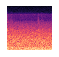

/content/drive/My Drive/sound Classification/fold10/167464-0-0-5.wav 0 air_conditioner /167464-0-0-5 338
/content/drive/My Drive/sound Classification/fold10/167464-0-0-5.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/167464-0-0-5.jpg


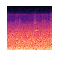

/content/drive/My Drive/sound Classification/fold10/167464-0-0-6.wav 0 air_conditioner /167464-0-0-6 339
/content/drive/My Drive/sound Classification/fold10/167464-0-0-6.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/167464-0-0-6.jpg


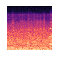

/content/drive/My Drive/sound Classification/fold10/167464-0-0-7.wav 0 air_conditioner /167464-0-0-7 340
/content/drive/My Drive/sound Classification/fold10/167464-0-0-7.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/167464-0-0-7.jpg


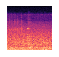

/content/drive/My Drive/sound Classification/fold10/167464-0-0-8.wav 0 air_conditioner /167464-0-0-8 341
/content/drive/My Drive/sound Classification/fold10/167464-0-0-8.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/167464-0-0-8.jpg


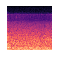

/content/drive/My Drive/sound Classification/fold10/167464-0-0-9.wav 0 air_conditioner /167464-0-0-9 342
/content/drive/My Drive/sound Classification/fold10/167464-0-0-9.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/167464-0-0-9.jpg


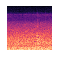

/content/drive/My Drive/sound Classification/fold10/167750-4-0-0.wav 4 drilling /167750-4-0-0 343
/content/drive/My Drive/sound Classification/fold10/167750-4-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/167750-4-0-0.jpg


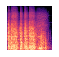

/content/drive/My Drive/sound Classification/fold10/167750-4-1-0.wav 4 drilling /167750-4-1-0 344
/content/drive/My Drive/sound Classification/fold10/167750-4-1-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/167750-4-1-0.jpg


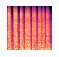

/content/drive/My Drive/sound Classification/fold10/167750-4-2-0.wav 4 drilling /167750-4-2-0 345
/content/drive/My Drive/sound Classification/fold10/167750-4-2-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/167750-4-2-0.jpg


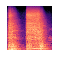

/content/drive/My Drive/sound Classification/fold10/167750-4-3-0.wav 4 drilling /167750-4-3-0 346
/content/drive/My Drive/sound Classification/fold10/167750-4-3-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/167750-4-3-0.jpg


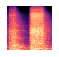

/content/drive/My Drive/sound Classification/fold10/169261-6-0-0.wav 6 gun_shot /169261-6-0-0 347
/content/drive/My Drive/sound Classification/fold10/169261-6-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/6_gun_shot/169261-6-0-0.jpg


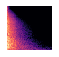

/content/drive/My Drive/sound Classification/fold10/17074-1-0-0.wav 1 car_horn /17074-1-0-0 348
/content/drive/My Drive/sound Classification/fold10/17074-1-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/1_car_horn/17074-1-0-0.jpg


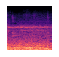

/content/drive/My Drive/sound Classification/fold10/17124-1-0-0.wav 1 car_horn /17124-1-0-0 349
/content/drive/My Drive/sound Classification/fold10/17124-1-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/1_car_horn/17124-1-0-0.jpg


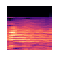

/content/drive/My Drive/sound Classification/fold10/171478-9-0-26.wav 9 street_music /171478-9-0-26 350
/content/drive/My Drive/sound Classification/fold10/171478-9-0-26.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/171478-9-0-26.jpg


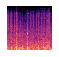

/content/drive/My Drive/sound Classification/fold10/171478-9-0-28.wav 9 street_music /171478-9-0-28 351
/content/drive/My Drive/sound Classification/fold10/171478-9-0-28.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/171478-9-0-28.jpg


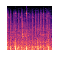

/content/drive/My Drive/sound Classification/fold10/171478-9-0-38.wav 9 street_music /171478-9-0-38 352
/content/drive/My Drive/sound Classification/fold10/171478-9-0-38.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/171478-9-0-38.jpg


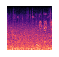

/content/drive/My Drive/sound Classification/fold10/171478-9-0-4.wav 9 street_music /171478-9-0-4 353
/content/drive/My Drive/sound Classification/fold10/171478-9-0-4.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/171478-9-0-4.jpg


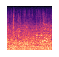

/content/drive/My Drive/sound Classification/fold10/171478-9-0-55.wav 9 street_music /171478-9-0-55 354
/content/drive/My Drive/sound Classification/fold10/171478-9-0-55.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/171478-9-0-55.jpg


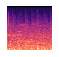

/content/drive/My Drive/sound Classification/fold10/171478-9-0-57.wav 9 street_music /171478-9-0-57 355
/content/drive/My Drive/sound Classification/fold10/171478-9-0-57.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/171478-9-0-57.jpg


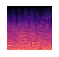

/content/drive/My Drive/sound Classification/fold10/171478-9-0-58.wav 9 street_music /171478-9-0-58 356
/content/drive/My Drive/sound Classification/fold10/171478-9-0-58.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/171478-9-0-58.jpg


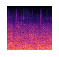

/content/drive/My Drive/sound Classification/fold10/172519-9-0-10.wav 9 street_music /172519-9-0-10 357
/content/drive/My Drive/sound Classification/fold10/172519-9-0-10.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/172519-9-0-10.jpg


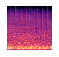

/content/drive/My Drive/sound Classification/fold10/172519-9-0-13.wav 9 street_music /172519-9-0-13 358
/content/drive/My Drive/sound Classification/fold10/172519-9-0-13.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/172519-9-0-13.jpg


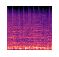

/content/drive/My Drive/sound Classification/fold10/172519-9-0-49.wav 9 street_music /172519-9-0-49 359
/content/drive/My Drive/sound Classification/fold10/172519-9-0-49.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/172519-9-0-49.jpg


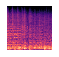

/content/drive/My Drive/sound Classification/fold10/172519-9-0-53.wav 9 street_music /172519-9-0-53 360
/content/drive/My Drive/sound Classification/fold10/172519-9-0-53.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/172519-9-0-53.jpg


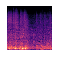

/content/drive/My Drive/sound Classification/fold10/172519-9-0-67.wav 9 street_music /172519-9-0-67 361
/content/drive/My Drive/sound Classification/fold10/172519-9-0-67.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/172519-9-0-67.jpg


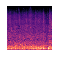

/content/drive/My Drive/sound Classification/fold10/172519-9-0-8.wav 9 street_music /172519-9-0-8 362
/content/drive/My Drive/sound Classification/fold10/172519-9-0-8.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/172519-9-0-8.jpg


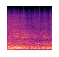

/content/drive/My Drive/sound Classification/fold10/174289-6-0-0.wav 6 gun_shot /174289-6-0-0 363
/content/drive/My Drive/sound Classification/fold10/174289-6-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/6_gun_shot/174289-6-0-0.jpg


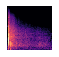

/content/drive/My Drive/sound Classification/fold10/174289-6-1-0.wav 6 gun_shot /174289-6-1-0 364
/content/drive/My Drive/sound Classification/fold10/174289-6-1-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/6_gun_shot/174289-6-1-0.jpg


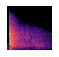

/content/drive/My Drive/sound Classification/fold10/174289-6-2-0.wav 6 gun_shot /174289-6-2-0 365
/content/drive/My Drive/sound Classification/fold10/174289-6-2-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/6_gun_shot/174289-6-2-0.jpg


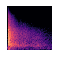

/content/drive/My Drive/sound Classification/fold10/174289-6-3-0.wav 6 gun_shot /174289-6-3-0 366
/content/drive/My Drive/sound Classification/fold10/174289-6-3-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/6_gun_shot/174289-6-3-0.jpg


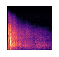

/content/drive/My Drive/sound Classification/fold10/174292-6-0-0.wav 6 gun_shot /174292-6-0-0 367
/content/drive/My Drive/sound Classification/fold10/174292-6-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/6_gun_shot/174292-6-0-0.jpg


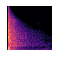

/content/drive/My Drive/sound Classification/fold10/174292-6-1-0.wav 6 gun_shot /174292-6-1-0 368
/content/drive/My Drive/sound Classification/fold10/174292-6-1-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/6_gun_shot/174292-6-1-0.jpg


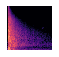

/content/drive/My Drive/sound Classification/fold10/174292-6-2-0.wav 6 gun_shot /174292-6-2-0 369
/content/drive/My Drive/sound Classification/fold10/174292-6-2-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/6_gun_shot/174292-6-2-0.jpg


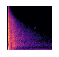

/content/drive/My Drive/sound Classification/fold10/17486-3-0-0.wav 3 dog_bark /17486-3-0-0 370
/content/drive/My Drive/sound Classification/fold10/17486-3-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/17486-3-0-0.jpg


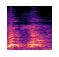

/content/drive/My Drive/sound Classification/fold10/17486-3-1-0.wav 3 dog_bark /17486-3-1-0 371
/content/drive/My Drive/sound Classification/fold10/17486-3-1-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/17486-3-1-0.jpg


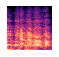

/content/drive/My Drive/sound Classification/fold10/17486-3-2-0.wav 3 dog_bark /17486-3-2-0 372
/content/drive/My Drive/sound Classification/fold10/17486-3-2-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/17486-3-2-0.jpg


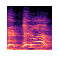

/content/drive/My Drive/sound Classification/fold10/175842-1-0-0.wav 1 car_horn /175842-1-0-0 373
/content/drive/My Drive/sound Classification/fold10/175842-1-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/1_car_horn/175842-1-0-0.jpg


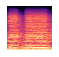

/content/drive/My Drive/sound Classification/fold10/175850-1-0-0.wav 1 car_horn /175850-1-0-0 374
/content/drive/My Drive/sound Classification/fold10/175850-1-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/1_car_horn/175850-1-0-0.jpg


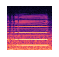

/content/drive/My Drive/sound Classification/fold10/178261-7-0-0.wav 7 jackhammer /178261-7-0-0 375
/content/drive/My Drive/sound Classification/fold10/178261-7-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/178261-7-0-0.jpg


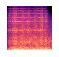

/content/drive/My Drive/sound Classification/fold10/178261-7-1-0.wav 7 jackhammer /178261-7-1-0 376
/content/drive/My Drive/sound Classification/fold10/178261-7-1-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/178261-7-1-0.jpg


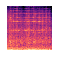

/content/drive/My Drive/sound Classification/fold10/178261-7-2-0.wav 7 jackhammer /178261-7-2-0 377
/content/drive/My Drive/sound Classification/fold10/178261-7-2-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/178261-7-2-0.jpg


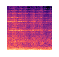

/content/drive/My Drive/sound Classification/fold10/178261-7-3-0.wav 7 jackhammer /178261-7-3-0 378
/content/drive/My Drive/sound Classification/fold10/178261-7-3-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/178261-7-3-0.jpg


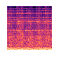

/content/drive/My Drive/sound Classification/fold10/178261-7-3-1.wav 7 jackhammer /178261-7-3-1 379
/content/drive/My Drive/sound Classification/fold10/178261-7-3-1.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/178261-7-3-1.jpg


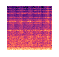

/content/drive/My Drive/sound Classification/fold10/178261-7-3-2.wav 7 jackhammer /178261-7-3-2 380
/content/drive/My Drive/sound Classification/fold10/178261-7-3-2.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/178261-7-3-2.jpg


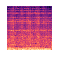

/content/drive/My Drive/sound Classification/fold10/178261-7-3-3.wav 7 jackhammer /178261-7-3-3 381
/content/drive/My Drive/sound Classification/fold10/178261-7-3-3.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/178261-7-3-3.jpg


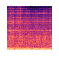

/content/drive/My Drive/sound Classification/fold10/178261-7-3-4.wav 7 jackhammer /178261-7-3-4 382
/content/drive/My Drive/sound Classification/fold10/178261-7-3-4.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/178261-7-3-4.jpg


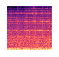

/content/drive/My Drive/sound Classification/fold10/178261-7-3-5.wav 7 jackhammer /178261-7-3-5 383
/content/drive/My Drive/sound Classification/fold10/178261-7-3-5.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/178261-7-3-5.jpg


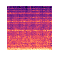

/content/drive/My Drive/sound Classification/fold10/178261-7-3-6.wav 7 jackhammer /178261-7-3-6 384
/content/drive/My Drive/sound Classification/fold10/178261-7-3-6.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/178261-7-3-6.jpg


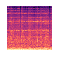

/content/drive/My Drive/sound Classification/fold10/178402-1-0-0.wav 1 car_horn /178402-1-0-0 385
/content/drive/My Drive/sound Classification/fold10/178402-1-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/1_car_horn/178402-1-0-0.jpg


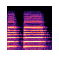

/content/drive/My Drive/sound Classification/fold10/178826-2-0-10.wav 2 children_playing /178826-2-0-10 386
/content/drive/My Drive/sound Classification/fold10/178826-2-0-10.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/178826-2-0-10.jpg


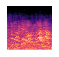

/content/drive/My Drive/sound Classification/fold10/178826-2-0-12.wav 2 children_playing /178826-2-0-12 387
/content/drive/My Drive/sound Classification/fold10/178826-2-0-12.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/178826-2-0-12.jpg


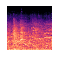

/content/drive/My Drive/sound Classification/fold10/178826-2-0-14.wav 2 children_playing /178826-2-0-14 388
/content/drive/My Drive/sound Classification/fold10/178826-2-0-14.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/178826-2-0-14.jpg


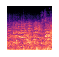

/content/drive/My Drive/sound Classification/fold10/178826-2-0-16.wav 2 children_playing /178826-2-0-16 389
/content/drive/My Drive/sound Classification/fold10/178826-2-0-16.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/178826-2-0-16.jpg


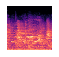

/content/drive/My Drive/sound Classification/fold10/178826-2-0-17.wav 2 children_playing /178826-2-0-17 390
/content/drive/My Drive/sound Classification/fold10/178826-2-0-17.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/178826-2-0-17.jpg


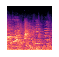

/content/drive/My Drive/sound Classification/fold10/178826-2-0-20.wav 2 children_playing /178826-2-0-20 391
/content/drive/My Drive/sound Classification/fold10/178826-2-0-20.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/178826-2-0-20.jpg


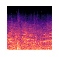

/content/drive/My Drive/sound Classification/fold10/178826-2-0-28.wav 2 children_playing /178826-2-0-28 392
/content/drive/My Drive/sound Classification/fold10/178826-2-0-28.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/178826-2-0-28.jpg


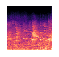

/content/drive/My Drive/sound Classification/fold10/178826-2-0-39.wav 2 children_playing /178826-2-0-39 393
/content/drive/My Drive/sound Classification/fold10/178826-2-0-39.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/178826-2-0-39.jpg


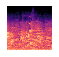

/content/drive/My Drive/sound Classification/fold10/179868-1-0-0.wav 1 car_horn /179868-1-0-0 394
/content/drive/My Drive/sound Classification/fold10/179868-1-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/1_car_horn/179868-1-0-0.jpg


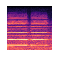

/content/drive/My Drive/sound Classification/fold10/180127-4-0-0.wav 4 drilling /180127-4-0-0 395
/content/drive/My Drive/sound Classification/fold10/180127-4-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/180127-4-0-0.jpg


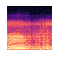

/content/drive/My Drive/sound Classification/fold10/180127-4-0-1.wav 4 drilling /180127-4-0-1 396
/content/drive/My Drive/sound Classification/fold10/180127-4-0-1.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/180127-4-0-1.jpg


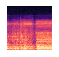

/content/drive/My Drive/sound Classification/fold10/180127-4-0-10.wav 4 drilling /180127-4-0-10 397
/content/drive/My Drive/sound Classification/fold10/180127-4-0-10.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/180127-4-0-10.jpg


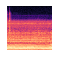

/content/drive/My Drive/sound Classification/fold10/180127-4-0-11.wav 4 drilling /180127-4-0-11 398
/content/drive/My Drive/sound Classification/fold10/180127-4-0-11.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/180127-4-0-11.jpg


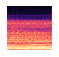

/content/drive/My Drive/sound Classification/fold10/180127-4-0-12.wav 4 drilling /180127-4-0-12 399
/content/drive/My Drive/sound Classification/fold10/180127-4-0-12.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/180127-4-0-12.jpg


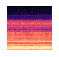

/content/drive/My Drive/sound Classification/fold10/180127-4-0-13.wav 4 drilling /180127-4-0-13 400
/content/drive/My Drive/sound Classification/fold10/180127-4-0-13.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/180127-4-0-13.jpg


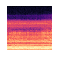

/content/drive/My Drive/sound Classification/fold10/180127-4-0-14.wav 4 drilling /180127-4-0-14 401
/content/drive/My Drive/sound Classification/fold10/180127-4-0-14.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/180127-4-0-14.jpg


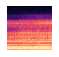

/content/drive/My Drive/sound Classification/fold10/180127-4-0-15.wav 4 drilling /180127-4-0-15 402
/content/drive/My Drive/sound Classification/fold10/180127-4-0-15.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/180127-4-0-15.jpg


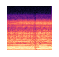

/content/drive/My Drive/sound Classification/fold10/180127-4-0-16.wav 4 drilling /180127-4-0-16 403
/content/drive/My Drive/sound Classification/fold10/180127-4-0-16.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/180127-4-0-16.jpg


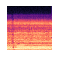

/content/drive/My Drive/sound Classification/fold10/180127-4-0-17.wav 4 drilling /180127-4-0-17 404
/content/drive/My Drive/sound Classification/fold10/180127-4-0-17.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/180127-4-0-17.jpg


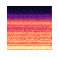

/content/drive/My Drive/sound Classification/fold10/180127-4-0-18.wav 4 drilling /180127-4-0-18 405
/content/drive/My Drive/sound Classification/fold10/180127-4-0-18.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/180127-4-0-18.jpg


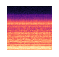

/content/drive/My Drive/sound Classification/fold10/180127-4-0-19.wav 4 drilling /180127-4-0-19 406
/content/drive/My Drive/sound Classification/fold10/180127-4-0-19.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/180127-4-0-19.jpg


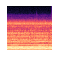

/content/drive/My Drive/sound Classification/fold10/180127-4-0-2.wav 4 drilling /180127-4-0-2 407
/content/drive/My Drive/sound Classification/fold10/180127-4-0-2.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/180127-4-0-2.jpg


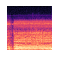

/content/drive/My Drive/sound Classification/fold10/180127-4-0-20.wav 4 drilling /180127-4-0-20 408
/content/drive/My Drive/sound Classification/fold10/180127-4-0-20.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/180127-4-0-20.jpg


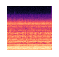

/content/drive/My Drive/sound Classification/fold10/180127-4-0-21.wav 4 drilling /180127-4-0-21 409
/content/drive/My Drive/sound Classification/fold10/180127-4-0-21.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/180127-4-0-21.jpg


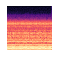

/content/drive/My Drive/sound Classification/fold10/180127-4-0-3.wav 4 drilling /180127-4-0-3 410
/content/drive/My Drive/sound Classification/fold10/180127-4-0-3.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/180127-4-0-3.jpg


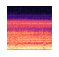

/content/drive/My Drive/sound Classification/fold10/180127-4-0-4.wav 4 drilling /180127-4-0-4 411
/content/drive/My Drive/sound Classification/fold10/180127-4-0-4.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/180127-4-0-4.jpg


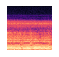

/content/drive/My Drive/sound Classification/fold10/180127-4-0-5.wav 4 drilling /180127-4-0-5 412
/content/drive/My Drive/sound Classification/fold10/180127-4-0-5.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/180127-4-0-5.jpg


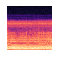

/content/drive/My Drive/sound Classification/fold10/180127-4-0-6.wav 4 drilling /180127-4-0-6 413
/content/drive/My Drive/sound Classification/fold10/180127-4-0-6.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/180127-4-0-6.jpg


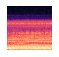

/content/drive/My Drive/sound Classification/fold10/180127-4-0-7.wav 4 drilling /180127-4-0-7 414
/content/drive/My Drive/sound Classification/fold10/180127-4-0-7.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/180127-4-0-7.jpg


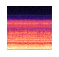

/content/drive/My Drive/sound Classification/fold10/180127-4-0-8.wav 4 drilling /180127-4-0-8 415
/content/drive/My Drive/sound Classification/fold10/180127-4-0-8.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/180127-4-0-8.jpg


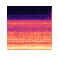

/content/drive/My Drive/sound Classification/fold10/180127-4-0-9.wav 4 drilling /180127-4-0-9 416
/content/drive/My Drive/sound Classification/fold10/180127-4-0-9.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/180127-4-0-9.jpg


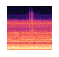

/content/drive/My Drive/sound Classification/fold10/181624-4-0-0.wav 4 drilling /181624-4-0-0 417
/content/drive/My Drive/sound Classification/fold10/181624-4-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/181624-4-0-0.jpg


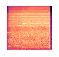

/content/drive/My Drive/sound Classification/fold10/181624-4-1-0.wav 4 drilling /181624-4-1-0 418
/content/drive/My Drive/sound Classification/fold10/181624-4-1-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/181624-4-1-0.jpg


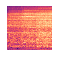

/content/drive/My Drive/sound Classification/fold10/181624-4-10-0.wav 4 drilling /181624-4-10-0 419
/content/drive/My Drive/sound Classification/fold10/181624-4-10-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/181624-4-10-0.jpg


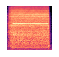

/content/drive/My Drive/sound Classification/fold10/181624-4-2-0.wav 4 drilling /181624-4-2-0 420
/content/drive/My Drive/sound Classification/fold10/181624-4-2-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/181624-4-2-0.jpg


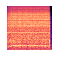

/content/drive/My Drive/sound Classification/fold10/181624-4-3-0.wav 4 drilling /181624-4-3-0 421
/content/drive/My Drive/sound Classification/fold10/181624-4-3-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/181624-4-3-0.jpg


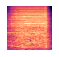

/content/drive/My Drive/sound Classification/fold10/181624-4-4-0.wav 4 drilling /181624-4-4-0 422
/content/drive/My Drive/sound Classification/fold10/181624-4-4-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/181624-4-4-0.jpg


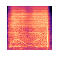

/content/drive/My Drive/sound Classification/fold10/181624-4-5-0.wav 4 drilling /181624-4-5-0 423
/content/drive/My Drive/sound Classification/fold10/181624-4-5-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/181624-4-5-0.jpg


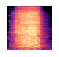

/content/drive/My Drive/sound Classification/fold10/181624-4-6-0.wav 4 drilling /181624-4-6-0 424
/content/drive/My Drive/sound Classification/fold10/181624-4-6-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/181624-4-6-0.jpg


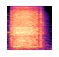

/content/drive/My Drive/sound Classification/fold10/181624-4-7-0.wav 4 drilling /181624-4-7-0 425
/content/drive/My Drive/sound Classification/fold10/181624-4-7-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/181624-4-7-0.jpg


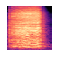

/content/drive/My Drive/sound Classification/fold10/181624-4-8-0.wav 4 drilling /181624-4-8-0 426
/content/drive/My Drive/sound Classification/fold10/181624-4-8-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/181624-4-8-0.jpg


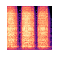

/content/drive/My Drive/sound Classification/fold10/181624-4-9-0.wav 4 drilling /181624-4-9-0 427
/content/drive/My Drive/sound Classification/fold10/181624-4-9-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/181624-4-9-0.jpg


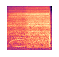

/content/drive/My Drive/sound Classification/fold10/187110-2-0-1.wav 2 children_playing /187110-2-0-1 428
/content/drive/My Drive/sound Classification/fold10/187110-2-0-1.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/187110-2-0-1.jpg


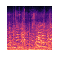

/content/drive/My Drive/sound Classification/fold10/187110-2-0-10.wav 2 children_playing /187110-2-0-10 429
/content/drive/My Drive/sound Classification/fold10/187110-2-0-10.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/187110-2-0-10.jpg


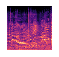

/content/drive/My Drive/sound Classification/fold10/187110-2-0-12.wav 2 children_playing /187110-2-0-12 430
/content/drive/My Drive/sound Classification/fold10/187110-2-0-12.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/187110-2-0-12.jpg


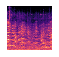

/content/drive/My Drive/sound Classification/fold10/187110-2-0-27.wav 2 children_playing /187110-2-0-27 431
/content/drive/My Drive/sound Classification/fold10/187110-2-0-27.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/187110-2-0-27.jpg


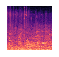

/content/drive/My Drive/sound Classification/fold10/187110-2-0-30.wav 2 children_playing /187110-2-0-30 432
/content/drive/My Drive/sound Classification/fold10/187110-2-0-30.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/187110-2-0-30.jpg


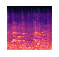

/content/drive/My Drive/sound Classification/fold10/187110-2-0-34.wav 2 children_playing /187110-2-0-34 433
/content/drive/My Drive/sound Classification/fold10/187110-2-0-34.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/187110-2-0-34.jpg


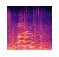

/content/drive/My Drive/sound Classification/fold10/187110-2-0-6.wav 2 children_playing /187110-2-0-6 434
/content/drive/My Drive/sound Classification/fold10/187110-2-0-6.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/187110-2-0-6.jpg


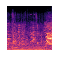

/content/drive/My Drive/sound Classification/fold10/187110-2-0-8.wav 2 children_playing /187110-2-0-8 435
/content/drive/My Drive/sound Classification/fold10/187110-2-0-8.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/187110-2-0-8.jpg


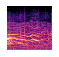

/content/drive/My Drive/sound Classification/fold10/187863-4-0-0.wav 4 drilling /187863-4-0-0 436
/content/drive/My Drive/sound Classification/fold10/187863-4-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/187863-4-0-0.jpg


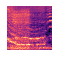

/content/drive/My Drive/sound Classification/fold10/187863-4-0-1.wav 4 drilling /187863-4-0-1 437
/content/drive/My Drive/sound Classification/fold10/187863-4-0-1.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/187863-4-0-1.jpg


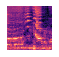

/content/drive/My Drive/sound Classification/fold10/187863-4-0-2.wav 4 drilling /187863-4-0-2 438
/content/drive/My Drive/sound Classification/fold10/187863-4-0-2.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/187863-4-0-2.jpg


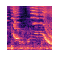

/content/drive/My Drive/sound Classification/fold10/187863-4-0-3.wav 4 drilling /187863-4-0-3 439
/content/drive/My Drive/sound Classification/fold10/187863-4-0-3.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/187863-4-0-3.jpg


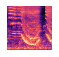

/content/drive/My Drive/sound Classification/fold10/187863-4-0-4.wav 4 drilling /187863-4-0-4 440
/content/drive/My Drive/sound Classification/fold10/187863-4-0-4.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/187863-4-0-4.jpg


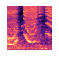

/content/drive/My Drive/sound Classification/fold10/187863-4-0-5.wav 4 drilling /187863-4-0-5 441
/content/drive/My Drive/sound Classification/fold10/187863-4-0-5.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/187863-4-0-5.jpg


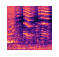

/content/drive/My Drive/sound Classification/fold10/188497-2-0-0.wav 2 children_playing /188497-2-0-0 442
/content/drive/My Drive/sound Classification/fold10/188497-2-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/188497-2-0-0.jpg


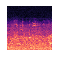

/content/drive/My Drive/sound Classification/fold10/188497-2-0-1.wav 2 children_playing /188497-2-0-1 443
/content/drive/My Drive/sound Classification/fold10/188497-2-0-1.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/188497-2-0-1.jpg


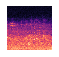

/content/drive/My Drive/sound Classification/fold10/188497-2-0-11.wav 2 children_playing /188497-2-0-11 444
/content/drive/My Drive/sound Classification/fold10/188497-2-0-11.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/188497-2-0-11.jpg


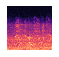

/content/drive/My Drive/sound Classification/fold10/188497-2-0-17.wav 2 children_playing /188497-2-0-17 445
/content/drive/My Drive/sound Classification/fold10/188497-2-0-17.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/188497-2-0-17.jpg


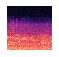

/content/drive/My Drive/sound Classification/fold10/188497-2-0-19.wav 2 children_playing /188497-2-0-19 446
/content/drive/My Drive/sound Classification/fold10/188497-2-0-19.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/188497-2-0-19.jpg


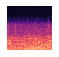

/content/drive/My Drive/sound Classification/fold10/188497-2-0-2.wav 2 children_playing /188497-2-0-2 447
/content/drive/My Drive/sound Classification/fold10/188497-2-0-2.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/188497-2-0-2.jpg


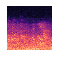

/content/drive/My Drive/sound Classification/fold10/188497-2-0-23.wav 2 children_playing /188497-2-0-23 448
/content/drive/My Drive/sound Classification/fold10/188497-2-0-23.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/188497-2-0-23.jpg


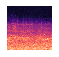

/content/drive/My Drive/sound Classification/fold10/188497-2-0-8.wav 2 children_playing /188497-2-0-8 449
/content/drive/My Drive/sound Classification/fold10/188497-2-0-8.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/188497-2-0-8.jpg


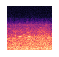

/content/drive/My Drive/sound Classification/fold10/188813-7-0-0.wav 7 jackhammer /188813-7-0-0 450
/content/drive/My Drive/sound Classification/fold10/188813-7-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/188813-7-0-0.jpg


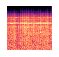

/content/drive/My Drive/sound Classification/fold10/188813-7-1-0.wav 7 jackhammer /188813-7-1-0 451
/content/drive/My Drive/sound Classification/fold10/188813-7-1-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/188813-7-1-0.jpg


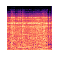

/content/drive/My Drive/sound Classification/fold10/188813-7-10-0.wav 7 jackhammer /188813-7-10-0 452
/content/drive/My Drive/sound Classification/fold10/188813-7-10-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/188813-7-10-0.jpg


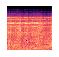

/content/drive/My Drive/sound Classification/fold10/188813-7-10-1.wav 7 jackhammer /188813-7-10-1 453
/content/drive/My Drive/sound Classification/fold10/188813-7-10-1.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/188813-7-10-1.jpg


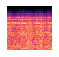

/content/drive/My Drive/sound Classification/fold10/188813-7-10-2.wav 7 jackhammer /188813-7-10-2 454
/content/drive/My Drive/sound Classification/fold10/188813-7-10-2.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/188813-7-10-2.jpg


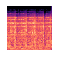

/content/drive/My Drive/sound Classification/fold10/188813-7-10-3.wav 7 jackhammer /188813-7-10-3 455
/content/drive/My Drive/sound Classification/fold10/188813-7-10-3.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/188813-7-10-3.jpg


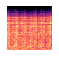

/content/drive/My Drive/sound Classification/fold10/188813-7-11-0.wav 7 jackhammer /188813-7-11-0 456
/content/drive/My Drive/sound Classification/fold10/188813-7-11-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/188813-7-11-0.jpg


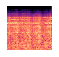

/content/drive/My Drive/sound Classification/fold10/188813-7-11-1.wav 7 jackhammer /188813-7-11-1 457
/content/drive/My Drive/sound Classification/fold10/188813-7-11-1.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/188813-7-11-1.jpg


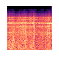

/content/drive/My Drive/sound Classification/fold10/188813-7-12-0.wav 7 jackhammer /188813-7-12-0 458
/content/drive/My Drive/sound Classification/fold10/188813-7-12-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/188813-7-12-0.jpg


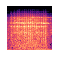

/content/drive/My Drive/sound Classification/fold10/188813-7-13-0.wav 7 jackhammer /188813-7-13-0 459
/content/drive/My Drive/sound Classification/fold10/188813-7-13-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/188813-7-13-0.jpg


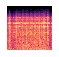

/content/drive/My Drive/sound Classification/fold10/188813-7-2-0.wav 7 jackhammer /188813-7-2-0 460
/content/drive/My Drive/sound Classification/fold10/188813-7-2-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/188813-7-2-0.jpg


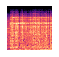

/content/drive/My Drive/sound Classification/fold10/188813-7-3-0.wav 7 jackhammer /188813-7-3-0 461
/content/drive/My Drive/sound Classification/fold10/188813-7-3-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/188813-7-3-0.jpg


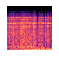

/content/drive/My Drive/sound Classification/fold10/188813-7-4-0.wav 7 jackhammer /188813-7-4-0 462
/content/drive/My Drive/sound Classification/fold10/188813-7-4-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/188813-7-4-0.jpg


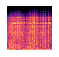

/content/drive/My Drive/sound Classification/fold10/188813-7-5-0.wav 7 jackhammer /188813-7-5-0 463
/content/drive/My Drive/sound Classification/fold10/188813-7-5-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/188813-7-5-0.jpg


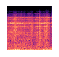

/content/drive/My Drive/sound Classification/fold10/188813-7-6-0.wav 7 jackhammer /188813-7-6-0 464
/content/drive/My Drive/sound Classification/fold10/188813-7-6-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/188813-7-6-0.jpg


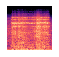

/content/drive/My Drive/sound Classification/fold10/188813-7-7-0.wav 7 jackhammer /188813-7-7-0 465
/content/drive/My Drive/sound Classification/fold10/188813-7-7-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/188813-7-7-0.jpg


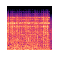

/content/drive/My Drive/sound Classification/fold10/188813-7-8-0.wav 7 jackhammer /188813-7-8-0 466
/content/drive/My Drive/sound Classification/fold10/188813-7-8-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/188813-7-8-0.jpg


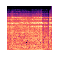

/content/drive/My Drive/sound Classification/fold10/188813-7-9-0.wav 7 jackhammer /188813-7-9-0 467
/content/drive/My Drive/sound Classification/fold10/188813-7-9-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/188813-7-9-0.jpg


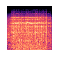

/content/drive/My Drive/sound Classification/fold10/189982-0-0-11.wav 0 air_conditioner /189982-0-0-11 468
/content/drive/My Drive/sound Classification/fold10/189982-0-0-11.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/189982-0-0-11.jpg


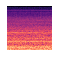

/content/drive/My Drive/sound Classification/fold10/189982-0-0-13.wav 0 air_conditioner /189982-0-0-13 469
/content/drive/My Drive/sound Classification/fold10/189982-0-0-13.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/189982-0-0-13.jpg


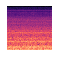

/content/drive/My Drive/sound Classification/fold10/189982-0-0-16.wav 0 air_conditioner /189982-0-0-16 470
/content/drive/My Drive/sound Classification/fold10/189982-0-0-16.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/189982-0-0-16.jpg


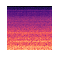

/content/drive/My Drive/sound Classification/fold10/189982-0-0-17.wav 0 air_conditioner /189982-0-0-17 471
/content/drive/My Drive/sound Classification/fold10/189982-0-0-17.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/189982-0-0-17.jpg


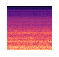

/content/drive/My Drive/sound Classification/fold10/189982-0-0-18.wav 0 air_conditioner /189982-0-0-18 472
/content/drive/My Drive/sound Classification/fold10/189982-0-0-18.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/189982-0-0-18.jpg


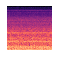

/content/drive/My Drive/sound Classification/fold10/189982-0-0-19.wav 0 air_conditioner /189982-0-0-19 473
/content/drive/My Drive/sound Classification/fold10/189982-0-0-19.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/189982-0-0-19.jpg


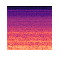

/content/drive/My Drive/sound Classification/fold10/189982-0-0-2.wav 0 air_conditioner /189982-0-0-2 474
/content/drive/My Drive/sound Classification/fold10/189982-0-0-2.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/189982-0-0-2.jpg


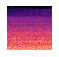

/content/drive/My Drive/sound Classification/fold10/189982-0-0-20.wav 0 air_conditioner /189982-0-0-20 475
/content/drive/My Drive/sound Classification/fold10/189982-0-0-20.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/189982-0-0-20.jpg


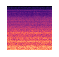

/content/drive/My Drive/sound Classification/fold10/189982-0-0-23.wav 0 air_conditioner /189982-0-0-23 476
/content/drive/My Drive/sound Classification/fold10/189982-0-0-23.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/189982-0-0-23.jpg


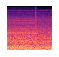

/content/drive/My Drive/sound Classification/fold10/189982-0-0-27.wav 0 air_conditioner /189982-0-0-27 477
/content/drive/My Drive/sound Classification/fold10/189982-0-0-27.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/189982-0-0-27.jpg


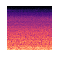

/content/drive/My Drive/sound Classification/fold10/189982-0-0-28.wav 0 air_conditioner /189982-0-0-28 478
/content/drive/My Drive/sound Classification/fold10/189982-0-0-28.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/189982-0-0-28.jpg


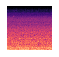

/content/drive/My Drive/sound Classification/fold10/189982-0-0-3.wav 0 air_conditioner /189982-0-0-3 479
/content/drive/My Drive/sound Classification/fold10/189982-0-0-3.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/189982-0-0-3.jpg


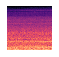

/content/drive/My Drive/sound Classification/fold10/189982-0-0-30.wav 0 air_conditioner /189982-0-0-30 480
/content/drive/My Drive/sound Classification/fold10/189982-0-0-30.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/189982-0-0-30.jpg


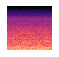

/content/drive/My Drive/sound Classification/fold10/189982-0-0-33.wav 0 air_conditioner /189982-0-0-33 481
/content/drive/My Drive/sound Classification/fold10/189982-0-0-33.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/189982-0-0-33.jpg


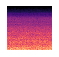

/content/drive/My Drive/sound Classification/fold10/189982-0-0-35.wav 0 air_conditioner /189982-0-0-35 482
/content/drive/My Drive/sound Classification/fold10/189982-0-0-35.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/189982-0-0-35.jpg


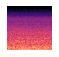

/content/drive/My Drive/sound Classification/fold10/189982-0-0-36.wav 0 air_conditioner /189982-0-0-36 483
/content/drive/My Drive/sound Classification/fold10/189982-0-0-36.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/189982-0-0-36.jpg


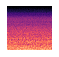

/content/drive/My Drive/sound Classification/fold10/189982-0-0-38.wav 0 air_conditioner /189982-0-0-38 484
/content/drive/My Drive/sound Classification/fold10/189982-0-0-38.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/189982-0-0-38.jpg


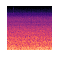

/content/drive/My Drive/sound Classification/fold10/189982-0-0-39.wav 0 air_conditioner /189982-0-0-39 485
/content/drive/My Drive/sound Classification/fold10/189982-0-0-39.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/189982-0-0-39.jpg


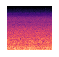

/content/drive/My Drive/sound Classification/fold10/189982-0-0-4.wav 0 air_conditioner /189982-0-0-4 486
/content/drive/My Drive/sound Classification/fold10/189982-0-0-4.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/189982-0-0-4.jpg


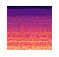

/content/drive/My Drive/sound Classification/fold10/189982-0-0-42.wav 0 air_conditioner /189982-0-0-42 487
/content/drive/My Drive/sound Classification/fold10/189982-0-0-42.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/189982-0-0-42.jpg


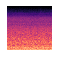

/content/drive/My Drive/sound Classification/fold10/189982-0-0-43.wav 0 air_conditioner /189982-0-0-43 488
/content/drive/My Drive/sound Classification/fold10/189982-0-0-43.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/189982-0-0-43.jpg


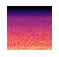

/content/drive/My Drive/sound Classification/fold10/189982-0-0-44.wav 0 air_conditioner /189982-0-0-44 489
/content/drive/My Drive/sound Classification/fold10/189982-0-0-44.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/189982-0-0-44.jpg


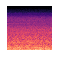

/content/drive/My Drive/sound Classification/fold10/189982-0-0-45.wav 0 air_conditioner /189982-0-0-45 490
/content/drive/My Drive/sound Classification/fold10/189982-0-0-45.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/189982-0-0-45.jpg


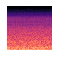

/content/drive/My Drive/sound Classification/fold10/189982-0-0-6.wav 0 air_conditioner /189982-0-0-6 491
/content/drive/My Drive/sound Classification/fold10/189982-0-0-6.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/189982-0-0-6.jpg


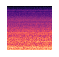

/content/drive/My Drive/sound Classification/fold10/189982-0-0-7.wav 0 air_conditioner /189982-0-0-7 492
/content/drive/My Drive/sound Classification/fold10/189982-0-0-7.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/189982-0-0-7.jpg


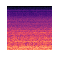

/content/drive/My Drive/sound Classification/fold10/189985-0-0-0.wav 0 air_conditioner /189985-0-0-0 493
/content/drive/My Drive/sound Classification/fold10/189985-0-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/189985-0-0-0.jpg


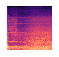

/content/drive/My Drive/sound Classification/fold10/189985-0-0-1.wav 0 air_conditioner /189985-0-0-1 494
/content/drive/My Drive/sound Classification/fold10/189985-0-0-1.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/189985-0-0-1.jpg


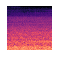

/content/drive/My Drive/sound Classification/fold10/189985-0-0-2.wav 0 air_conditioner /189985-0-0-2 495
/content/drive/My Drive/sound Classification/fold10/189985-0-0-2.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/189985-0-0-2.jpg


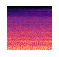

/content/drive/My Drive/sound Classification/fold10/189985-0-0-3.wav 0 air_conditioner /189985-0-0-3 496
/content/drive/My Drive/sound Classification/fold10/189985-0-0-3.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/189985-0-0-3.jpg


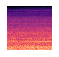

/content/drive/My Drive/sound Classification/fold10/189985-0-0-4.wav 0 air_conditioner /189985-0-0-4 497
/content/drive/My Drive/sound Classification/fold10/189985-0-0-4.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/189985-0-0-4.jpg


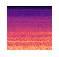

/content/drive/My Drive/sound Classification/fold10/189985-0-0-5.wav 0 air_conditioner /189985-0-0-5 498
/content/drive/My Drive/sound Classification/fold10/189985-0-0-5.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/189985-0-0-5.jpg


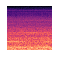

/content/drive/My Drive/sound Classification/fold10/189985-0-0-6.wav 0 air_conditioner /189985-0-0-6 499
/content/drive/My Drive/sound Classification/fold10/189985-0-0-6.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/189985-0-0-6.jpg


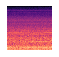

/content/drive/My Drive/sound Classification/fold10/195063-4-0-0.wav 4 drilling /195063-4-0-0 500
/content/drive/My Drive/sound Classification/fold10/195063-4-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/195063-4-0-0.jpg


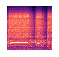

/content/drive/My Drive/sound Classification/fold10/195063-4-1-0.wav 4 drilling /195063-4-1-0 501
/content/drive/My Drive/sound Classification/fold10/195063-4-1-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/195063-4-1-0.jpg


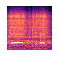

/content/drive/My Drive/sound Classification/fold10/196069-2-0-0.wav 2 children_playing /196069-2-0-0 502
/content/drive/My Drive/sound Classification/fold10/196069-2-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/196069-2-0-0.jpg


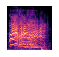

/content/drive/My Drive/sound Classification/fold10/196084-2-0-0.wav 2 children_playing /196084-2-0-0 503
/content/drive/My Drive/sound Classification/fold10/196084-2-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/196084-2-0-0.jpg


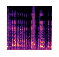

/content/drive/My Drive/sound Classification/fold10/196084-2-0-1.wav 2 children_playing /196084-2-0-1 504
/content/drive/My Drive/sound Classification/fold10/196084-2-0-1.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/196084-2-0-1.jpg


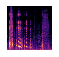

/content/drive/My Drive/sound Classification/fold10/196084-2-0-2.wav 2 children_playing /196084-2-0-2 505
/content/drive/My Drive/sound Classification/fold10/196084-2-0-2.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/196084-2-0-2.jpg


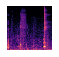

/content/drive/My Drive/sound Classification/fold10/196086-2-0-0.wav 2 children_playing /196086-2-0-0 506
/content/drive/My Drive/sound Classification/fold10/196086-2-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/196086-2-0-0.jpg


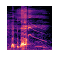

/content/drive/My Drive/sound Classification/fold10/196127-3-0-0.wav 3 dog_bark /196127-3-0-0 507
/content/drive/My Drive/sound Classification/fold10/196127-3-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/196127-3-0-0.jpg


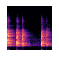

/content/drive/My Drive/sound Classification/fold10/196127-3-0-1.wav 3 dog_bark /196127-3-0-1 508
/content/drive/My Drive/sound Classification/fold10/196127-3-0-1.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/196127-3-0-1.jpg


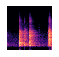

/content/drive/My Drive/sound Classification/fold10/196127-3-0-3.wav 3 dog_bark /196127-3-0-3 509
/content/drive/My Drive/sound Classification/fold10/196127-3-0-3.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/196127-3-0-3.jpg


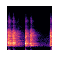

/content/drive/My Drive/sound Classification/fold10/196127-3-0-4.wav 3 dog_bark /196127-3-0-4 510
/content/drive/My Drive/sound Classification/fold10/196127-3-0-4.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/196127-3-0-4.jpg


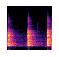

/content/drive/My Drive/sound Classification/fold10/197554-2-0-23.wav 2 children_playing /197554-2-0-23 511
/content/drive/My Drive/sound Classification/fold10/197554-2-0-23.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/197554-2-0-23.jpg


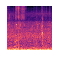

/content/drive/My Drive/sound Classification/fold10/197554-2-0-26.wav 2 children_playing /197554-2-0-26 512
/content/drive/My Drive/sound Classification/fold10/197554-2-0-26.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/197554-2-0-26.jpg


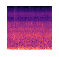

/content/drive/My Drive/sound Classification/fold10/197554-2-0-28.wav 2 children_playing /197554-2-0-28 513
/content/drive/My Drive/sound Classification/fold10/197554-2-0-28.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/197554-2-0-28.jpg


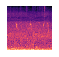

/content/drive/My Drive/sound Classification/fold10/197554-2-0-3.wav 2 children_playing /197554-2-0-3 514
/content/drive/My Drive/sound Classification/fold10/197554-2-0-3.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/197554-2-0-3.jpg


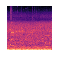

/content/drive/My Drive/sound Classification/fold10/197554-2-0-60.wav 2 children_playing /197554-2-0-60 515
/content/drive/My Drive/sound Classification/fold10/197554-2-0-60.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/197554-2-0-60.jpg


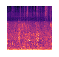

/content/drive/My Drive/sound Classification/fold10/197554-2-0-69.wav 2 children_playing /197554-2-0-69 516
/content/drive/My Drive/sound Classification/fold10/197554-2-0-69.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/197554-2-0-69.jpg


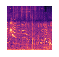

/content/drive/My Drive/sound Classification/fold10/197554-2-0-74.wav 2 children_playing /197554-2-0-74 517
/content/drive/My Drive/sound Classification/fold10/197554-2-0-74.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/197554-2-0-74.jpg


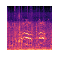

/content/drive/My Drive/sound Classification/fold10/197554-2-0-82.wav 2 children_playing /197554-2-0-82 518
/content/drive/My Drive/sound Classification/fold10/197554-2-0-82.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/197554-2-0-82.jpg


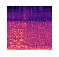

/content/drive/My Drive/sound Classification/fold10/199261-3-0-0.wav 3 dog_bark /199261-3-0-0 519
/content/drive/My Drive/sound Classification/fold10/199261-3-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/199261-3-0-0.jpg


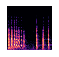

/content/drive/My Drive/sound Classification/fold10/199261-3-0-1.wav 3 dog_bark /199261-3-0-1 520
/content/drive/My Drive/sound Classification/fold10/199261-3-0-1.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/199261-3-0-1.jpg


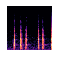

/content/drive/My Drive/sound Classification/fold10/199261-3-0-2.wav 3 dog_bark /199261-3-0-2 521
/content/drive/My Drive/sound Classification/fold10/199261-3-0-2.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/199261-3-0-2.jpg


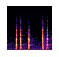

/content/drive/My Drive/sound Classification/fold10/199261-3-0-4.wav 3 dog_bark /199261-3-0-4 522
/content/drive/My Drive/sound Classification/fold10/199261-3-0-4.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/199261-3-0-4.jpg


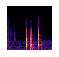

/content/drive/My Drive/sound Classification/fold10/200460-6-0-0.wav 6 gun_shot /200460-6-0-0 523
/content/drive/My Drive/sound Classification/fold10/200460-6-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/6_gun_shot/200460-6-0-0.jpg


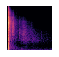

/content/drive/My Drive/sound Classification/fold10/200460-6-1-0.wav 6 gun_shot /200460-6-1-0 524
/content/drive/My Drive/sound Classification/fold10/200460-6-1-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/6_gun_shot/200460-6-1-0.jpg


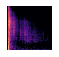

/content/drive/My Drive/sound Classification/fold10/200460-6-2-0.wav 6 gun_shot /200460-6-2-0 525
/content/drive/My Drive/sound Classification/fold10/200460-6-2-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/6_gun_shot/200460-6-2-0.jpg


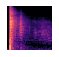

/content/drive/My Drive/sound Classification/fold10/200460-6-3-0.wav 6 gun_shot /200460-6-3-0 526
/content/drive/My Drive/sound Classification/fold10/200460-6-3-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/6_gun_shot/200460-6-3-0.jpg


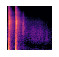

/content/drive/My Drive/sound Classification/fold10/200460-6-4-0.wav 6 gun_shot /200460-6-4-0 527
/content/drive/My Drive/sound Classification/fold10/200460-6-4-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/6_gun_shot/200460-6-4-0.jpg


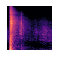

/content/drive/My Drive/sound Classification/fold10/200460-6-5-0.wav 6 gun_shot /200460-6-5-0 528
/content/drive/My Drive/sound Classification/fold10/200460-6-5-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/6_gun_shot/200460-6-5-0.jpg


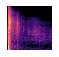

/content/drive/My Drive/sound Classification/fold10/200786-5-0-0.wav 5 engine_idling /200786-5-0-0 529
/content/drive/My Drive/sound Classification/fold10/200786-5-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/200786-5-0-0.jpg


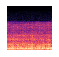

/content/drive/My Drive/sound Classification/fold10/200786-5-1-0.wav 5 engine_idling /200786-5-1-0 530
/content/drive/My Drive/sound Classification/fold10/200786-5-1-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/200786-5-1-0.jpg


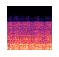

/content/drive/My Drive/sound Classification/fold10/200786-5-1-1.wav 5 engine_idling /200786-5-1-1 531
/content/drive/My Drive/sound Classification/fold10/200786-5-1-1.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/200786-5-1-1.jpg


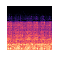

/content/drive/My Drive/sound Classification/fold10/200786-5-1-2.wav 5 engine_idling /200786-5-1-2 532
/content/drive/My Drive/sound Classification/fold10/200786-5-1-2.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/200786-5-1-2.jpg


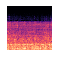

/content/drive/My Drive/sound Classification/fold10/200786-5-1-3.wav 5 engine_idling /200786-5-1-3 533
/content/drive/My Drive/sound Classification/fold10/200786-5-1-3.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/200786-5-1-3.jpg


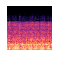

/content/drive/My Drive/sound Classification/fold10/200786-5-1-4.wav 5 engine_idling /200786-5-1-4 534
/content/drive/My Drive/sound Classification/fold10/200786-5-1-4.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/200786-5-1-4.jpg


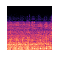

/content/drive/My Drive/sound Classification/fold10/200786-5-1-5.wav 5 engine_idling /200786-5-1-5 535
/content/drive/My Drive/sound Classification/fold10/200786-5-1-5.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/200786-5-1-5.jpg


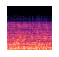

/content/drive/My Drive/sound Classification/fold10/202334-9-0-105.wav 9 street_music /202334-9-0-105 536
/content/drive/My Drive/sound Classification/fold10/202334-9-0-105.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/202334-9-0-105.jpg


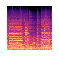

/content/drive/My Drive/sound Classification/fold10/202334-9-0-106.wav 9 street_music /202334-9-0-106 537
/content/drive/My Drive/sound Classification/fold10/202334-9-0-106.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/202334-9-0-106.jpg


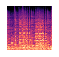

/content/drive/My Drive/sound Classification/fold10/202334-9-0-137.wav 9 street_music /202334-9-0-137 538
/content/drive/My Drive/sound Classification/fold10/202334-9-0-137.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/202334-9-0-137.jpg


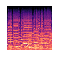

/content/drive/My Drive/sound Classification/fold10/202334-9-0-202.wav 9 street_music /202334-9-0-202 539
/content/drive/My Drive/sound Classification/fold10/202334-9-0-202.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/202334-9-0-202.jpg


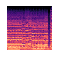

/content/drive/My Drive/sound Classification/fold10/202334-9-0-63.wav 9 street_music /202334-9-0-63 540
/content/drive/My Drive/sound Classification/fold10/202334-9-0-63.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/202334-9-0-63.jpg


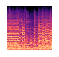

/content/drive/My Drive/sound Classification/fold10/202334-9-0-88.wav 9 street_music /202334-9-0-88 541
/content/drive/My Drive/sound Classification/fold10/202334-9-0-88.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/202334-9-0-88.jpg


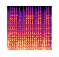

/content/drive/My Drive/sound Classification/fold10/203424-9-0-15.wav 9 street_music /203424-9-0-15 542
/content/drive/My Drive/sound Classification/fold10/203424-9-0-15.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/203424-9-0-15.jpg


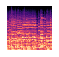

/content/drive/My Drive/sound Classification/fold10/203424-9-0-18.wav 9 street_music /203424-9-0-18 543
/content/drive/My Drive/sound Classification/fold10/203424-9-0-18.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/203424-9-0-18.jpg


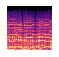

/content/drive/My Drive/sound Classification/fold10/203424-9-0-26.wav 9 street_music /203424-9-0-26 544
/content/drive/My Drive/sound Classification/fold10/203424-9-0-26.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/203424-9-0-26.jpg


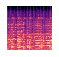

/content/drive/My Drive/sound Classification/fold10/203424-9-0-34.wav 9 street_music /203424-9-0-34 545
/content/drive/My Drive/sound Classification/fold10/203424-9-0-34.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/203424-9-0-34.jpg


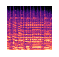

/content/drive/My Drive/sound Classification/fold10/203424-9-0-4.wav 9 street_music /203424-9-0-4 546
/content/drive/My Drive/sound Classification/fold10/203424-9-0-4.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/203424-9-0-4.jpg


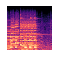

/content/drive/My Drive/sound Classification/fold10/203424-9-0-46.wav 9 street_music /203424-9-0-46 547
/content/drive/My Drive/sound Classification/fold10/203424-9-0-46.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/203424-9-0-46.jpg


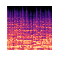

/content/drive/My Drive/sound Classification/fold10/205013-6-0-0.wav 6 gun_shot /205013-6-0-0 548
/content/drive/My Drive/sound Classification/fold10/205013-6-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/6_gun_shot/205013-6-0-0.jpg


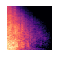

/content/drive/My Drive/sound Classification/fold10/20571-3-0-0.wav 3 dog_bark /20571-3-0-0 549
/content/drive/My Drive/sound Classification/fold10/20571-3-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/20571-3-0-0.jpg


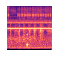

/content/drive/My Drive/sound Classification/fold10/20571-3-1-0.wav 3 dog_bark /20571-3-1-0 550
/content/drive/My Drive/sound Classification/fold10/20571-3-1-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/20571-3-1-0.jpg


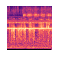

/content/drive/My Drive/sound Classification/fold10/207213-2-0-109.wav 2 children_playing /207213-2-0-109 551
/content/drive/My Drive/sound Classification/fold10/207213-2-0-109.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/207213-2-0-109.jpg


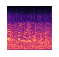

/content/drive/My Drive/sound Classification/fold10/207213-2-0-130.wav 2 children_playing /207213-2-0-130 552
/content/drive/My Drive/sound Classification/fold10/207213-2-0-130.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/207213-2-0-130.jpg


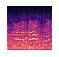

/content/drive/My Drive/sound Classification/fold10/207213-2-0-134.wav 2 children_playing /207213-2-0-134 553
/content/drive/My Drive/sound Classification/fold10/207213-2-0-134.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/207213-2-0-134.jpg


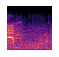

/content/drive/My Drive/sound Classification/fold10/207213-2-0-41.wav 2 children_playing /207213-2-0-41 554
/content/drive/My Drive/sound Classification/fold10/207213-2-0-41.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/207213-2-0-41.jpg


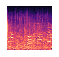

/content/drive/My Drive/sound Classification/fold10/207213-2-0-52.wav 2 children_playing /207213-2-0-52 555
/content/drive/My Drive/sound Classification/fold10/207213-2-0-52.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/207213-2-0-52.jpg


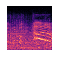

/content/drive/My Drive/sound Classification/fold10/207213-2-0-73.wav 2 children_playing /207213-2-0-73 556
/content/drive/My Drive/sound Classification/fold10/207213-2-0-73.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/207213-2-0-73.jpg


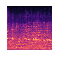

/content/drive/My Drive/sound Classification/fold10/207213-2-0-81.wav 2 children_playing /207213-2-0-81 557
/content/drive/My Drive/sound Classification/fold10/207213-2-0-81.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/207213-2-0-81.jpg


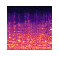

/content/drive/My Drive/sound Classification/fold10/207213-2-0-85.wav 2 children_playing /207213-2-0-85 558
/content/drive/My Drive/sound Classification/fold10/207213-2-0-85.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/207213-2-0-85.jpg


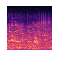

/content/drive/My Drive/sound Classification/fold10/208652-8-0-0.wav 8 siren /208652-8-0-0 559
/content/drive/My Drive/sound Classification/fold10/208652-8-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/208652-8-0-0.jpg


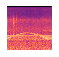

/content/drive/My Drive/sound Classification/fold10/208652-8-2-0.wav 8 siren /208652-8-2-0 560
/content/drive/My Drive/sound Classification/fold10/208652-8-2-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/208652-8-2-0.jpg


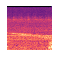

/content/drive/My Drive/sound Classification/fold10/208652-8-4-0.wav 8 siren /208652-8-4-0 561
/content/drive/My Drive/sound Classification/fold10/208652-8-4-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/208652-8-4-0.jpg


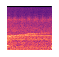

/content/drive/My Drive/sound Classification/fold10/208652-8-6-0.wav 8 siren /208652-8-6-0 562
/content/drive/My Drive/sound Classification/fold10/208652-8-6-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/208652-8-6-0.jpg


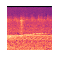

/content/drive/My Drive/sound Classification/fold10/209672-3-0-0.wav 3 dog_bark /209672-3-0-0 563
/content/drive/My Drive/sound Classification/fold10/209672-3-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/209672-3-0-0.jpg


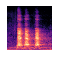

/content/drive/My Drive/sound Classification/fold10/209672-3-3-0.wav 3 dog_bark /209672-3-3-0 564
/content/drive/My Drive/sound Classification/fold10/209672-3-3-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/209672-3-3-0.jpg


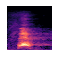

/content/drive/My Drive/sound Classification/fold10/209672-3-6-0.wav 3 dog_bark /209672-3-6-0 565
/content/drive/My Drive/sound Classification/fold10/209672-3-6-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/209672-3-6-0.jpg


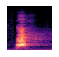

/content/drive/My Drive/sound Classification/fold10/209672-3-8-0.wav 3 dog_bark /209672-3-8-0 566
/content/drive/My Drive/sound Classification/fold10/209672-3-8-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/209672-3-8-0.jpg


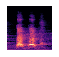

/content/drive/My Drive/sound Classification/fold10/22973-3-0-0.wav 3 dog_bark /22973-3-0-0 567
/content/drive/My Drive/sound Classification/fold10/22973-3-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/22973-3-0-0.jpg


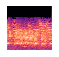

/content/drive/My Drive/sound Classification/fold10/22973-3-0-1.wav 3 dog_bark /22973-3-0-1 568
/content/drive/My Drive/sound Classification/fold10/22973-3-0-1.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/22973-3-0-1.jpg


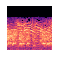

/content/drive/My Drive/sound Classification/fold10/22973-3-0-2.wav 3 dog_bark /22973-3-0-2 569
/content/drive/My Drive/sound Classification/fold10/22973-3-0-2.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/22973-3-0-2.jpg


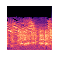

/content/drive/My Drive/sound Classification/fold10/23218-5-0-0.wav 5 engine_idling /23218-5-0-0 570
/content/drive/My Drive/sound Classification/fold10/23218-5-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/23218-5-0-0.jpg


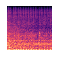

/content/drive/My Drive/sound Classification/fold10/24076-1-0-0.wav 1 car_horn /24076-1-0-0 571
/content/drive/My Drive/sound Classification/fold10/24076-1-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/1_car_horn/24076-1-0-0.jpg


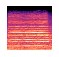

/content/drive/My Drive/sound Classification/fold10/24076-1-1-0.wav 1 car_horn /24076-1-1-0 572
/content/drive/My Drive/sound Classification/fold10/24076-1-1-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/1_car_horn/24076-1-1-0.jpg


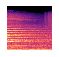

/content/drive/My Drive/sound Classification/fold10/25037-6-0-0.wav 6 gun_shot /25037-6-0-0 573
/content/drive/My Drive/sound Classification/fold10/25037-6-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/6_gun_shot/25037-6-0-0.jpg


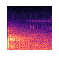

/content/drive/My Drive/sound Classification/fold10/25037-6-1-0.wav 6 gun_shot /25037-6-1-0 574
/content/drive/My Drive/sound Classification/fold10/25037-6-1-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/6_gun_shot/25037-6-1-0.jpg


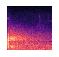

/content/drive/My Drive/sound Classification/fold10/26173-8-0-0.wav 8 siren /26173-8-0-0 575
/content/drive/My Drive/sound Classification/fold10/26173-8-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/26173-8-0-0.jpg


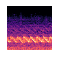

/content/drive/My Drive/sound Classification/fold10/26255-3-0-0.wav 3 dog_bark /26255-3-0-0 576
/content/drive/My Drive/sound Classification/fold10/26255-3-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/26255-3-0-0.jpg


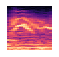

/content/drive/My Drive/sound Classification/fold10/26255-3-13-1.wav 3 dog_bark /26255-3-13-1 577
/content/drive/My Drive/sound Classification/fold10/26255-3-13-1.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/26255-3-13-1.jpg


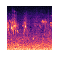

/content/drive/My Drive/sound Classification/fold10/26255-3-6-0.wav 3 dog_bark /26255-3-6-0 578
/content/drive/My Drive/sound Classification/fold10/26255-3-6-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/26255-3-6-0.jpg


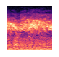

/content/drive/My Drive/sound Classification/fold10/26255-3-8-0.wav 3 dog_bark /26255-3-8-0 579
/content/drive/My Drive/sound Classification/fold10/26255-3-8-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/26255-3-8-0.jpg


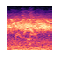

/content/drive/My Drive/sound Classification/fold10/26344-4-0-0.wav 4 drilling /26344-4-0-0 580
/content/drive/My Drive/sound Classification/fold10/26344-4-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/26344-4-0-0.jpg


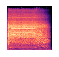

/content/drive/My Drive/sound Classification/fold10/26344-4-1-0.wav 4 drilling /26344-4-1-0 581
/content/drive/My Drive/sound Classification/fold10/26344-4-1-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/26344-4-1-0.jpg


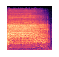

/content/drive/My Drive/sound Classification/fold10/27070-2-0-0.wav 2 children_playing /27070-2-0-0 582
/content/drive/My Drive/sound Classification/fold10/27070-2-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/27070-2-0-0.jpg


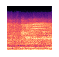

/content/drive/My Drive/sound Classification/fold10/27070-2-0-2.wav 2 children_playing /27070-2-0-2 583
/content/drive/My Drive/sound Classification/fold10/27070-2-0-2.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/27070-2-0-2.jpg


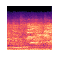

/content/drive/My Drive/sound Classification/fold10/27070-2-0-3.wav 2 children_playing /27070-2-0-3 584
/content/drive/My Drive/sound Classification/fold10/27070-2-0-3.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/27070-2-0-3.jpg


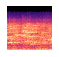

/content/drive/My Drive/sound Classification/fold10/27070-2-0-4.wav 2 children_playing /27070-2-0-4 585
/content/drive/My Drive/sound Classification/fold10/27070-2-0-4.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/27070-2-0-4.jpg


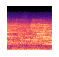

/content/drive/My Drive/sound Classification/fold10/27070-2-0-5.wav 2 children_playing /27070-2-0-5 586
/content/drive/My Drive/sound Classification/fold10/27070-2-0-5.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/27070-2-0-5.jpg


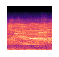

/content/drive/My Drive/sound Classification/fold10/27070-2-0-7.wav 2 children_playing /27070-2-0-7 587
/content/drive/My Drive/sound Classification/fold10/27070-2-0-7.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/27070-2-0-7.jpg


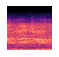

/content/drive/My Drive/sound Classification/fold10/27070-2-0-8.wav 2 children_playing /27070-2-0-8 588
/content/drive/My Drive/sound Classification/fold10/27070-2-0-8.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/2_children_playing/27070-2-0-8.jpg


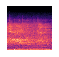

/content/drive/My Drive/sound Classification/fold10/28808-1-0-0.wav 1 car_horn /28808-1-0-0 589
/content/drive/My Drive/sound Classification/fold10/28808-1-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/1_car_horn/28808-1-0-0.jpg


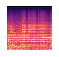

/content/drive/My Drive/sound Classification/fold10/28808-1-0-1.wav 1 car_horn /28808-1-0-1 590
/content/drive/My Drive/sound Classification/fold10/28808-1-0-1.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/1_car_horn/28808-1-0-1.jpg


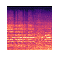

/content/drive/My Drive/sound Classification/fold10/28808-1-0-10.wav 1 car_horn /28808-1-0-10 591
/content/drive/My Drive/sound Classification/fold10/28808-1-0-10.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/1_car_horn/28808-1-0-10.jpg


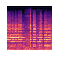

/content/drive/My Drive/sound Classification/fold10/28808-1-0-11.wav 1 car_horn /28808-1-0-11 592
/content/drive/My Drive/sound Classification/fold10/28808-1-0-11.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/1_car_horn/28808-1-0-11.jpg


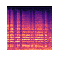

/content/drive/My Drive/sound Classification/fold10/28808-1-0-2.wav 1 car_horn /28808-1-0-2 593
/content/drive/My Drive/sound Classification/fold10/28808-1-0-2.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/1_car_horn/28808-1-0-2.jpg


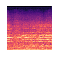

/content/drive/My Drive/sound Classification/fold10/28808-1-0-3.wav 1 car_horn /28808-1-0-3 594
/content/drive/My Drive/sound Classification/fold10/28808-1-0-3.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/1_car_horn/28808-1-0-3.jpg


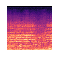

/content/drive/My Drive/sound Classification/fold10/28808-1-0-4.wav 1 car_horn /28808-1-0-4 595
/content/drive/My Drive/sound Classification/fold10/28808-1-0-4.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/1_car_horn/28808-1-0-4.jpg


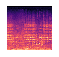

/content/drive/My Drive/sound Classification/fold10/28808-1-0-5.wav 1 car_horn /28808-1-0-5 596
/content/drive/My Drive/sound Classification/fold10/28808-1-0-5.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/1_car_horn/28808-1-0-5.jpg


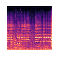

/content/drive/My Drive/sound Classification/fold10/28808-1-0-6.wav 1 car_horn /28808-1-0-6 597
/content/drive/My Drive/sound Classification/fold10/28808-1-0-6.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/1_car_horn/28808-1-0-6.jpg


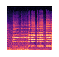

/content/drive/My Drive/sound Classification/fold10/28808-1-0-7.wav 1 car_horn /28808-1-0-7 598
/content/drive/My Drive/sound Classification/fold10/28808-1-0-7.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/1_car_horn/28808-1-0-7.jpg


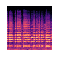

/content/drive/My Drive/sound Classification/fold10/28808-1-0-8.wav 1 car_horn /28808-1-0-8 599
/content/drive/My Drive/sound Classification/fold10/28808-1-0-8.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/1_car_horn/28808-1-0-8.jpg


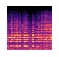

/content/drive/My Drive/sound Classification/fold10/28808-1-0-9.wav 1 car_horn /28808-1-0-9 600
/content/drive/My Drive/sound Classification/fold10/28808-1-0-9.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/1_car_horn/28808-1-0-9.jpg


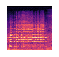

/content/drive/My Drive/sound Classification/fold10/28808-1-1-0.wav 1 car_horn /28808-1-1-0 601
/content/drive/My Drive/sound Classification/fold10/28808-1-1-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/1_car_horn/28808-1-1-0.jpg


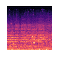

/content/drive/My Drive/sound Classification/fold10/28808-1-1-1.wav 1 car_horn /28808-1-1-1 602
/content/drive/My Drive/sound Classification/fold10/28808-1-1-1.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/1_car_horn/28808-1-1-1.jpg


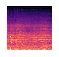

/content/drive/My Drive/sound Classification/fold10/2937-1-0-0.wav 1 car_horn /2937-1-0-0 603
/content/drive/My Drive/sound Classification/fold10/2937-1-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/1_car_horn/2937-1-0-0.jpg


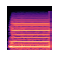

/content/drive/My Drive/sound Classification/fold10/30344-3-0-0.wav 3 dog_bark /30344-3-0-0 604
/content/drive/My Drive/sound Classification/fold10/30344-3-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/30344-3-0-0.jpg


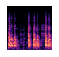

/content/drive/My Drive/sound Classification/fold10/30344-3-0-1.wav 3 dog_bark /30344-3-0-1 605
/content/drive/My Drive/sound Classification/fold10/30344-3-0-1.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/30344-3-0-1.jpg


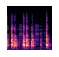

/content/drive/My Drive/sound Classification/fold10/30344-3-0-3.wav 3 dog_bark /30344-3-0-3 606
/content/drive/My Drive/sound Classification/fold10/30344-3-0-3.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/30344-3-0-3.jpg


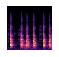

/content/drive/My Drive/sound Classification/fold10/30344-3-0-4.wav 3 dog_bark /30344-3-0-4 607
/content/drive/My Drive/sound Classification/fold10/30344-3-0-4.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/30344-3-0-4.jpg


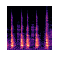

/content/drive/My Drive/sound Classification/fold10/34050-7-0-0.wav 7 jackhammer /34050-7-0-0 608
/content/drive/My Drive/sound Classification/fold10/34050-7-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/34050-7-0-0.jpg


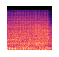

/content/drive/My Drive/sound Classification/fold10/34050-7-1-0.wav 7 jackhammer /34050-7-1-0 609
/content/drive/My Drive/sound Classification/fold10/34050-7-1-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/34050-7-1-0.jpg


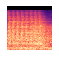

/content/drive/My Drive/sound Classification/fold10/34050-7-2-0.wav 7 jackhammer /34050-7-2-0 610
/content/drive/My Drive/sound Classification/fold10/34050-7-2-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/34050-7-2-0.jpg


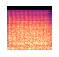

/content/drive/My Drive/sound Classification/fold10/34050-7-3-0.wav 7 jackhammer /34050-7-3-0 611
/content/drive/My Drive/sound Classification/fold10/34050-7-3-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/34050-7-3-0.jpg


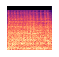

/content/drive/My Drive/sound Classification/fold10/34050-7-4-0.wav 7 jackhammer /34050-7-4-0 612
/content/drive/My Drive/sound Classification/fold10/34050-7-4-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/34050-7-4-0.jpg


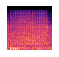

/content/drive/My Drive/sound Classification/fold10/34050-7-5-0.wav 7 jackhammer /34050-7-5-0 613
/content/drive/My Drive/sound Classification/fold10/34050-7-5-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/34050-7-5-0.jpg


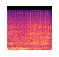

/content/drive/My Drive/sound Classification/fold10/34050-7-6-0.wav 7 jackhammer /34050-7-6-0 614
/content/drive/My Drive/sound Classification/fold10/34050-7-6-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/7_jackhammer/34050-7-6-0.jpg


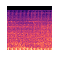

/content/drive/My Drive/sound Classification/fold10/35628-3-0-0.wav 3 dog_bark /35628-3-0-0 615
/content/drive/My Drive/sound Classification/fold10/35628-3-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/35628-3-0-0.jpg


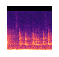

/content/drive/My Drive/sound Classification/fold10/39847-5-0-0.wav 5 engine_idling /39847-5-0-0 616
/content/drive/My Drive/sound Classification/fold10/39847-5-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/39847-5-0-0.jpg


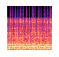

/content/drive/My Drive/sound Classification/fold10/39847-5-0-1.wav 5 engine_idling /39847-5-0-1 617
/content/drive/My Drive/sound Classification/fold10/39847-5-0-1.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/39847-5-0-1.jpg


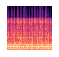

/content/drive/My Drive/sound Classification/fold10/39847-5-0-10.wav 5 engine_idling /39847-5-0-10 618
/content/drive/My Drive/sound Classification/fold10/39847-5-0-10.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/39847-5-0-10.jpg


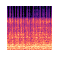

/content/drive/My Drive/sound Classification/fold10/39847-5-0-11.wav 5 engine_idling /39847-5-0-11 619
/content/drive/My Drive/sound Classification/fold10/39847-5-0-11.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/39847-5-0-11.jpg


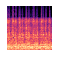

/content/drive/My Drive/sound Classification/fold10/39847-5-0-12.wav 5 engine_idling /39847-5-0-12 620
/content/drive/My Drive/sound Classification/fold10/39847-5-0-12.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/39847-5-0-12.jpg


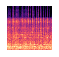

/content/drive/My Drive/sound Classification/fold10/39847-5-0-2.wav 5 engine_idling /39847-5-0-2 621
/content/drive/My Drive/sound Classification/fold10/39847-5-0-2.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/39847-5-0-2.jpg


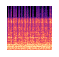

/content/drive/My Drive/sound Classification/fold10/39847-5-0-3.wav 5 engine_idling /39847-5-0-3 622
/content/drive/My Drive/sound Classification/fold10/39847-5-0-3.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/39847-5-0-3.jpg


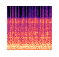

/content/drive/My Drive/sound Classification/fold10/39847-5-0-4.wav 5 engine_idling /39847-5-0-4 623
/content/drive/My Drive/sound Classification/fold10/39847-5-0-4.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/39847-5-0-4.jpg


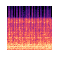

/content/drive/My Drive/sound Classification/fold10/39847-5-0-5.wav 5 engine_idling /39847-5-0-5 624
/content/drive/My Drive/sound Classification/fold10/39847-5-0-5.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/39847-5-0-5.jpg


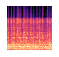

/content/drive/My Drive/sound Classification/fold10/39847-5-0-6.wav 5 engine_idling /39847-5-0-6 625
/content/drive/My Drive/sound Classification/fold10/39847-5-0-6.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/39847-5-0-6.jpg


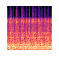

/content/drive/My Drive/sound Classification/fold10/39847-5-0-7.wav 5 engine_idling /39847-5-0-7 626
/content/drive/My Drive/sound Classification/fold10/39847-5-0-7.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/39847-5-0-7.jpg


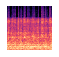

/content/drive/My Drive/sound Classification/fold10/39847-5-0-8.wav 5 engine_idling /39847-5-0-8 627
/content/drive/My Drive/sound Classification/fold10/39847-5-0-8.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/39847-5-0-8.jpg


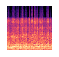

/content/drive/My Drive/sound Classification/fold10/39847-5-0-9.wav 5 engine_idling /39847-5-0-9 628
/content/drive/My Drive/sound Classification/fold10/39847-5-0-9.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/39847-5-0-9.jpg


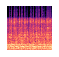

/content/drive/My Drive/sound Classification/fold10/39847-5-1-0.wav 5 engine_idling /39847-5-1-0 629
/content/drive/My Drive/sound Classification/fold10/39847-5-1-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/5_engine_idling/39847-5-1-0.jpg


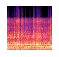

/content/drive/My Drive/sound Classification/fold10/41306-3-0-10.wav 3 dog_bark /41306-3-0-10 630
/content/drive/My Drive/sound Classification/fold10/41306-3-0-10.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/41306-3-0-10.jpg


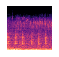

/content/drive/My Drive/sound Classification/fold10/41306-3-0-13.wav 3 dog_bark /41306-3-0-13 631
/content/drive/My Drive/sound Classification/fold10/41306-3-0-13.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/41306-3-0-13.jpg


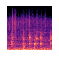

/content/drive/My Drive/sound Classification/fold10/41306-3-0-4.wav 3 dog_bark /41306-3-0-4 632
/content/drive/My Drive/sound Classification/fold10/41306-3-0-4.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/41306-3-0-4.jpg


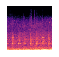

/content/drive/My Drive/sound Classification/fold10/51024-3-0-16.wav 3 dog_bark /51024-3-0-16 633
/content/drive/My Drive/sound Classification/fold10/51024-3-0-16.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/51024-3-0-16.jpg


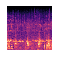

/content/drive/My Drive/sound Classification/fold10/51024-3-0-2.wav 3 dog_bark /51024-3-0-2 634
/content/drive/My Drive/sound Classification/fold10/51024-3-0-2.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/51024-3-0-2.jpg


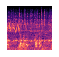

/content/drive/My Drive/sound Classification/fold10/51024-3-0-23.wav 3 dog_bark /51024-3-0-23 635
/content/drive/My Drive/sound Classification/fold10/51024-3-0-23.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/51024-3-0-23.jpg


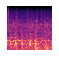

/content/drive/My Drive/sound Classification/fold10/51024-3-0-3.wav 3 dog_bark /51024-3-0-3 636
/content/drive/My Drive/sound Classification/fold10/51024-3-0-3.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/51024-3-0-3.jpg


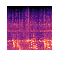

/content/drive/My Drive/sound Classification/fold10/54086-1-0-0.wav 1 car_horn /54086-1-0-0 637
/content/drive/My Drive/sound Classification/fold10/54086-1-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/1_car_horn/54086-1-0-0.jpg


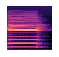

/content/drive/My Drive/sound Classification/fold10/54086-1-1-0.wav 1 car_horn /54086-1-1-0 638
/content/drive/My Drive/sound Classification/fold10/54086-1-1-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/1_car_horn/54086-1-1-0.jpg


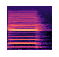

/content/drive/My Drive/sound Classification/fold10/54086-1-2-0.wav 1 car_horn /54086-1-2-0 639
/content/drive/My Drive/sound Classification/fold10/54086-1-2-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/1_car_horn/54086-1-2-0.jpg


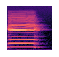

/content/drive/My Drive/sound Classification/fold10/59513-3-0-0.wav 3 dog_bark /59513-3-0-0 640
/content/drive/My Drive/sound Classification/fold10/59513-3-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/59513-3-0-0.jpg


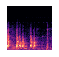

/content/drive/My Drive/sound Classification/fold10/59513-3-0-1.wav 3 dog_bark /59513-3-0-1 641
/content/drive/My Drive/sound Classification/fold10/59513-3-0-1.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/59513-3-0-1.jpg


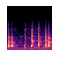

/content/drive/My Drive/sound Classification/fold10/59513-3-0-3.wav 3 dog_bark /59513-3-0-3 642
/content/drive/My Drive/sound Classification/fold10/59513-3-0-3.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/59513-3-0-3.jpg


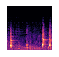

/content/drive/My Drive/sound Classification/fold10/59513-3-0-4.wav 3 dog_bark /59513-3-0-4 643
/content/drive/My Drive/sound Classification/fold10/59513-3-0-4.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/59513-3-0-4.jpg


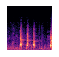

/content/drive/My Drive/sound Classification/fold10/66115-1-0-0.wav 1 car_horn /66115-1-0-0 644
/content/drive/My Drive/sound Classification/fold10/66115-1-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/1_car_horn/66115-1-0-0.jpg


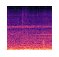

/content/drive/My Drive/sound Classification/fold10/66115-1-0-1.wav 1 car_horn /66115-1-0-1 645
/content/drive/My Drive/sound Classification/fold10/66115-1-0-1.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/1_car_horn/66115-1-0-1.jpg


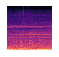

/content/drive/My Drive/sound Classification/fold10/69661-3-0-14.wav 3 dog_bark /69661-3-0-14 646
/content/drive/My Drive/sound Classification/fold10/69661-3-0-14.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/69661-3-0-14.jpg


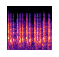

/content/drive/My Drive/sound Classification/fold10/69661-3-0-23.wav 3 dog_bark /69661-3-0-23 647
/content/drive/My Drive/sound Classification/fold10/69661-3-0-23.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/69661-3-0-23.jpg


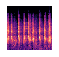

/content/drive/My Drive/sound Classification/fold10/69661-3-0-29.wav 3 dog_bark /69661-3-0-29 648
/content/drive/My Drive/sound Classification/fold10/69661-3-0-29.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/69661-3-0-29.jpg


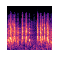

/content/drive/My Drive/sound Classification/fold10/7062-6-0-0.wav 6 gun_shot /7062-6-0-0 649
/content/drive/My Drive/sound Classification/fold10/7062-6-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/6_gun_shot/7062-6-0-0.jpg


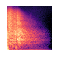

/content/drive/My Drive/sound Classification/fold10/71312-3-0-1.wav 3 dog_bark /71312-3-0-1 650
/content/drive/My Drive/sound Classification/fold10/71312-3-0-1.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/71312-3-0-1.jpg


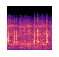

/content/drive/My Drive/sound Classification/fold10/71312-3-0-2.wav 3 dog_bark /71312-3-0-2 651
/content/drive/My Drive/sound Classification/fold10/71312-3-0-2.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/71312-3-0-2.jpg


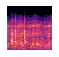

/content/drive/My Drive/sound Classification/fold10/71312-3-0-4.wav 3 dog_bark /71312-3-0-4 652
/content/drive/My Drive/sound Classification/fold10/71312-3-0-4.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/71312-3-0-4.jpg


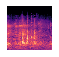

/content/drive/My Drive/sound Classification/fold10/71312-3-0-5.wav 3 dog_bark /71312-3-0-5 653
/content/drive/My Drive/sound Classification/fold10/71312-3-0-5.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/71312-3-0-5.jpg


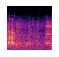

/content/drive/My Drive/sound Classification/fold10/72220-3-0-0.wav 3 dog_bark /72220-3-0-0 654
/content/drive/My Drive/sound Classification/fold10/72220-3-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/72220-3-0-0.jpg


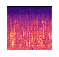

/content/drive/My Drive/sound Classification/fold10/72220-3-2-2.wav 3 dog_bark /72220-3-2-2 655
/content/drive/My Drive/sound Classification/fold10/72220-3-2-2.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/72220-3-2-2.jpg


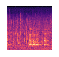

/content/drive/My Drive/sound Classification/fold10/72220-3-2-3.wav 3 dog_bark /72220-3-2-3 656
/content/drive/My Drive/sound Classification/fold10/72220-3-2-3.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/72220-3-2-3.jpg


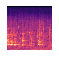

/content/drive/My Drive/sound Classification/fold10/72220-3-2-4.wav 3 dog_bark /72220-3-2-4 657
/content/drive/My Drive/sound Classification/fold10/72220-3-2-4.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/72220-3-2-4.jpg


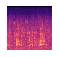

/content/drive/My Drive/sound Classification/fold10/72538-3-0-0.wav 3 dog_bark /72538-3-0-0 658
/content/drive/My Drive/sound Classification/fold10/72538-3-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/72538-3-0-0.jpg


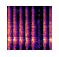

/content/drive/My Drive/sound Classification/fold10/72538-3-0-1.wav 3 dog_bark /72538-3-0-1 659
/content/drive/My Drive/sound Classification/fold10/72538-3-0-1.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/72538-3-0-1.jpg


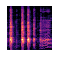

/content/drive/My Drive/sound Classification/fold10/72538-3-0-3.wav 3 dog_bark /72538-3-0-3 660
/content/drive/My Drive/sound Classification/fold10/72538-3-0-3.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/72538-3-0-3.jpg


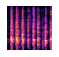

/content/drive/My Drive/sound Classification/fold10/72538-3-0-4.wav 3 dog_bark /72538-3-0-4 661
/content/drive/My Drive/sound Classification/fold10/72538-3-0-4.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/72538-3-0-4.jpg


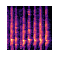

/content/drive/My Drive/sound Classification/fold10/73524-0-0-0.wav 0 air_conditioner /73524-0-0-0 662
/content/drive/My Drive/sound Classification/fold10/73524-0-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/73524-0-0-0.jpg


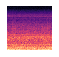

/content/drive/My Drive/sound Classification/fold10/73524-0-0-101.wav 0 air_conditioner /73524-0-0-101 663
/content/drive/My Drive/sound Classification/fold10/73524-0-0-101.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/73524-0-0-101.jpg


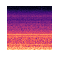

/content/drive/My Drive/sound Classification/fold10/73524-0-0-105.wav 0 air_conditioner /73524-0-0-105 664
/content/drive/My Drive/sound Classification/fold10/73524-0-0-105.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/73524-0-0-105.jpg


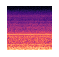

/content/drive/My Drive/sound Classification/fold10/73524-0-0-113.wav 0 air_conditioner /73524-0-0-113 665
/content/drive/My Drive/sound Classification/fold10/73524-0-0-113.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/73524-0-0-113.jpg


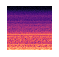

/content/drive/My Drive/sound Classification/fold10/73524-0-0-114.wav 0 air_conditioner /73524-0-0-114 666
/content/drive/My Drive/sound Classification/fold10/73524-0-0-114.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/73524-0-0-114.jpg


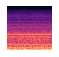

/content/drive/My Drive/sound Classification/fold10/73524-0-0-126.wav 0 air_conditioner /73524-0-0-126 667
/content/drive/My Drive/sound Classification/fold10/73524-0-0-126.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/73524-0-0-126.jpg


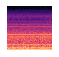

/content/drive/My Drive/sound Classification/fold10/73524-0-0-127.wav 0 air_conditioner /73524-0-0-127 668
/content/drive/My Drive/sound Classification/fold10/73524-0-0-127.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/73524-0-0-127.jpg


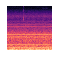

/content/drive/My Drive/sound Classification/fold10/73524-0-0-128.wav 0 air_conditioner /73524-0-0-128 669
/content/drive/My Drive/sound Classification/fold10/73524-0-0-128.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/73524-0-0-128.jpg


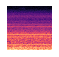

/content/drive/My Drive/sound Classification/fold10/73524-0-0-133.wav 0 air_conditioner /73524-0-0-133 670
/content/drive/My Drive/sound Classification/fold10/73524-0-0-133.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/73524-0-0-133.jpg


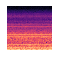

/content/drive/My Drive/sound Classification/fold10/73524-0-0-137.wav 0 air_conditioner /73524-0-0-137 671
/content/drive/My Drive/sound Classification/fold10/73524-0-0-137.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/73524-0-0-137.jpg


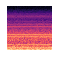

/content/drive/My Drive/sound Classification/fold10/73524-0-0-2.wav 0 air_conditioner /73524-0-0-2 672
/content/drive/My Drive/sound Classification/fold10/73524-0-0-2.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/73524-0-0-2.jpg


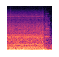

/content/drive/My Drive/sound Classification/fold10/73524-0-0-23.wav 0 air_conditioner /73524-0-0-23 673
/content/drive/My Drive/sound Classification/fold10/73524-0-0-23.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/73524-0-0-23.jpg


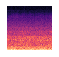

/content/drive/My Drive/sound Classification/fold10/73524-0-0-30.wav 0 air_conditioner /73524-0-0-30 674
/content/drive/My Drive/sound Classification/fold10/73524-0-0-30.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/73524-0-0-30.jpg


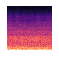

/content/drive/My Drive/sound Classification/fold10/73524-0-0-31.wav 0 air_conditioner /73524-0-0-31 675
/content/drive/My Drive/sound Classification/fold10/73524-0-0-31.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/73524-0-0-31.jpg


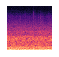

/content/drive/My Drive/sound Classification/fold10/73524-0-0-32.wav 0 air_conditioner /73524-0-0-32 676
/content/drive/My Drive/sound Classification/fold10/73524-0-0-32.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/73524-0-0-32.jpg


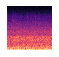

/content/drive/My Drive/sound Classification/fold10/73524-0-0-5.wav 0 air_conditioner /73524-0-0-5 677
/content/drive/My Drive/sound Classification/fold10/73524-0-0-5.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/73524-0-0-5.jpg


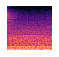

/content/drive/My Drive/sound Classification/fold10/73524-0-0-52.wav 0 air_conditioner /73524-0-0-52 678
/content/drive/My Drive/sound Classification/fold10/73524-0-0-52.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/73524-0-0-52.jpg


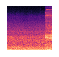

/content/drive/My Drive/sound Classification/fold10/73524-0-0-54.wav 0 air_conditioner /73524-0-0-54 679
/content/drive/My Drive/sound Classification/fold10/73524-0-0-54.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/73524-0-0-54.jpg


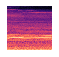

/content/drive/My Drive/sound Classification/fold10/73524-0-0-6.wav 0 air_conditioner /73524-0-0-6 680
/content/drive/My Drive/sound Classification/fold10/73524-0-0-6.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/73524-0-0-6.jpg


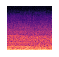

/content/drive/My Drive/sound Classification/fold10/73524-0-0-63.wav 0 air_conditioner /73524-0-0-63 681
/content/drive/My Drive/sound Classification/fold10/73524-0-0-63.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/73524-0-0-63.jpg


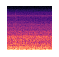

/content/drive/My Drive/sound Classification/fold10/73524-0-0-73.wav 0 air_conditioner /73524-0-0-73 682
/content/drive/My Drive/sound Classification/fold10/73524-0-0-73.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/73524-0-0-73.jpg


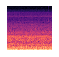

/content/drive/My Drive/sound Classification/fold10/73524-0-0-74.wav 0 air_conditioner /73524-0-0-74 683
/content/drive/My Drive/sound Classification/fold10/73524-0-0-74.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/73524-0-0-74.jpg


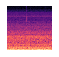

/content/drive/My Drive/sound Classification/fold10/73524-0-0-8.wav 0 air_conditioner /73524-0-0-8 684
/content/drive/My Drive/sound Classification/fold10/73524-0-0-8.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/73524-0-0-8.jpg


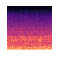

/content/drive/My Drive/sound Classification/fold10/73524-0-0-92.wav 0 air_conditioner /73524-0-0-92 685
/content/drive/My Drive/sound Classification/fold10/73524-0-0-92.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/73524-0-0-92.jpg


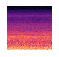

/content/drive/My Drive/sound Classification/fold10/73524-0-0-98.wav 0 air_conditioner /73524-0-0-98 686
/content/drive/My Drive/sound Classification/fold10/73524-0-0-98.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/73524-0-0-98.jpg


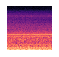

/content/drive/My Drive/sound Classification/fold10/73524-0-0-99.wav 0 air_conditioner /73524-0-0-99 687
/content/drive/My Drive/sound Classification/fold10/73524-0-0-99.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/73524-0-0-99.jpg


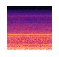

/content/drive/My Drive/sound Classification/fold10/74364-8-1-0.wav 8 siren /74364-8-1-0 688
/content/drive/My Drive/sound Classification/fold10/74364-8-1-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/74364-8-1-0.jpg


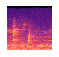

/content/drive/My Drive/sound Classification/fold10/74364-8-1-1.wav 8 siren /74364-8-1-1 689
/content/drive/My Drive/sound Classification/fold10/74364-8-1-1.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/74364-8-1-1.jpg


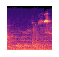

/content/drive/My Drive/sound Classification/fold10/74364-8-1-10.wav 8 siren /74364-8-1-10 690
/content/drive/My Drive/sound Classification/fold10/74364-8-1-10.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/74364-8-1-10.jpg


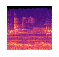

/content/drive/My Drive/sound Classification/fold10/74364-8-1-11.wav 8 siren /74364-8-1-11 691
/content/drive/My Drive/sound Classification/fold10/74364-8-1-11.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/74364-8-1-11.jpg


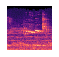

/content/drive/My Drive/sound Classification/fold10/74364-8-1-12.wav 8 siren /74364-8-1-12 692
/content/drive/My Drive/sound Classification/fold10/74364-8-1-12.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/74364-8-1-12.jpg


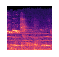

/content/drive/My Drive/sound Classification/fold10/74364-8-1-13.wav 8 siren /74364-8-1-13 693
/content/drive/My Drive/sound Classification/fold10/74364-8-1-13.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/74364-8-1-13.jpg


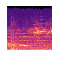

/content/drive/My Drive/sound Classification/fold10/74364-8-1-14.wav 8 siren /74364-8-1-14 694
/content/drive/My Drive/sound Classification/fold10/74364-8-1-14.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/74364-8-1-14.jpg


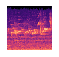

/content/drive/My Drive/sound Classification/fold10/74364-8-1-15.wav 8 siren /74364-8-1-15 695
/content/drive/My Drive/sound Classification/fold10/74364-8-1-15.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/74364-8-1-15.jpg


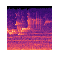

/content/drive/My Drive/sound Classification/fold10/74364-8-1-16.wav 8 siren /74364-8-1-16 696
/content/drive/My Drive/sound Classification/fold10/74364-8-1-16.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/74364-8-1-16.jpg


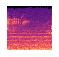

/content/drive/My Drive/sound Classification/fold10/74364-8-1-17.wav 8 siren /74364-8-1-17 697
/content/drive/My Drive/sound Classification/fold10/74364-8-1-17.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/74364-8-1-17.jpg


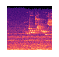

/content/drive/My Drive/sound Classification/fold10/74364-8-1-18.wav 8 siren /74364-8-1-18 698
/content/drive/My Drive/sound Classification/fold10/74364-8-1-18.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/74364-8-1-18.jpg


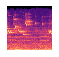

/content/drive/My Drive/sound Classification/fold10/74364-8-1-19.wav 8 siren /74364-8-1-19 699
/content/drive/My Drive/sound Classification/fold10/74364-8-1-19.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/74364-8-1-19.jpg


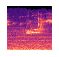

/content/drive/My Drive/sound Classification/fold10/74364-8-1-2.wav 8 siren /74364-8-1-2 700
/content/drive/My Drive/sound Classification/fold10/74364-8-1-2.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/74364-8-1-2.jpg


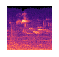

/content/drive/My Drive/sound Classification/fold10/74364-8-1-20.wav 8 siren /74364-8-1-20 701
/content/drive/My Drive/sound Classification/fold10/74364-8-1-20.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/74364-8-1-20.jpg


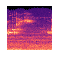

/content/drive/My Drive/sound Classification/fold10/74364-8-1-21.wav 8 siren /74364-8-1-21 702
/content/drive/My Drive/sound Classification/fold10/74364-8-1-21.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/74364-8-1-21.jpg


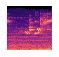

/content/drive/My Drive/sound Classification/fold10/74364-8-1-22.wav 8 siren /74364-8-1-22 703
/content/drive/My Drive/sound Classification/fold10/74364-8-1-22.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/74364-8-1-22.jpg


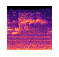

/content/drive/My Drive/sound Classification/fold10/74364-8-1-23.wav 8 siren /74364-8-1-23 704
/content/drive/My Drive/sound Classification/fold10/74364-8-1-23.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/74364-8-1-23.jpg


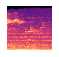

/content/drive/My Drive/sound Classification/fold10/74364-8-1-24.wav 8 siren /74364-8-1-24 705
/content/drive/My Drive/sound Classification/fold10/74364-8-1-24.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/74364-8-1-24.jpg


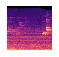

/content/drive/My Drive/sound Classification/fold10/74364-8-1-25.wav 8 siren /74364-8-1-25 706
/content/drive/My Drive/sound Classification/fold10/74364-8-1-25.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/74364-8-1-25.jpg


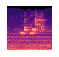

/content/drive/My Drive/sound Classification/fold10/74364-8-1-26.wav 8 siren /74364-8-1-26 707
/content/drive/My Drive/sound Classification/fold10/74364-8-1-26.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/74364-8-1-26.jpg


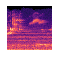

/content/drive/My Drive/sound Classification/fold10/74364-8-1-27.wav 8 siren /74364-8-1-27 708
/content/drive/My Drive/sound Classification/fold10/74364-8-1-27.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/74364-8-1-27.jpg


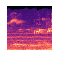

/content/drive/My Drive/sound Classification/fold10/74364-8-1-3.wav 8 siren /74364-8-1-3 709
/content/drive/My Drive/sound Classification/fold10/74364-8-1-3.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/74364-8-1-3.jpg


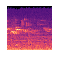

/content/drive/My Drive/sound Classification/fold10/74364-8-1-4.wav 8 siren /74364-8-1-4 710
/content/drive/My Drive/sound Classification/fold10/74364-8-1-4.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/74364-8-1-4.jpg


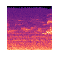

/content/drive/My Drive/sound Classification/fold10/74364-8-1-5.wav 8 siren /74364-8-1-5 711
/content/drive/My Drive/sound Classification/fold10/74364-8-1-5.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/74364-8-1-5.jpg


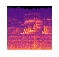

/content/drive/My Drive/sound Classification/fold10/74364-8-1-6.wav 8 siren /74364-8-1-6 712
/content/drive/My Drive/sound Classification/fold10/74364-8-1-6.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/74364-8-1-6.jpg


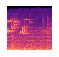

/content/drive/My Drive/sound Classification/fold10/74364-8-1-7.wav 8 siren /74364-8-1-7 713
/content/drive/My Drive/sound Classification/fold10/74364-8-1-7.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/74364-8-1-7.jpg


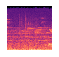

/content/drive/My Drive/sound Classification/fold10/74364-8-1-8.wav 8 siren /74364-8-1-8 714
/content/drive/My Drive/sound Classification/fold10/74364-8-1-8.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/74364-8-1-8.jpg


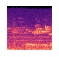

/content/drive/My Drive/sound Classification/fold10/74364-8-1-9.wav 8 siren /74364-8-1-9 715
/content/drive/My Drive/sound Classification/fold10/74364-8-1-9.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/74364-8-1-9.jpg


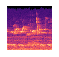

/content/drive/My Drive/sound Classification/fold10/74922-4-0-0.wav 4 drilling /74922-4-0-0 716
/content/drive/My Drive/sound Classification/fold10/74922-4-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/74922-4-0-0.jpg


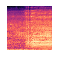

/content/drive/My Drive/sound Classification/fold10/74922-4-0-1.wav 4 drilling /74922-4-0-1 717
/content/drive/My Drive/sound Classification/fold10/74922-4-0-1.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/74922-4-0-1.jpg


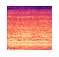

/content/drive/My Drive/sound Classification/fold10/74922-4-0-2.wav 4 drilling /74922-4-0-2 718
/content/drive/My Drive/sound Classification/fold10/74922-4-0-2.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/74922-4-0-2.jpg


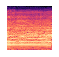

/content/drive/My Drive/sound Classification/fold10/74922-4-0-3.wav 4 drilling /74922-4-0-3 719
/content/drive/My Drive/sound Classification/fold10/74922-4-0-3.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/74922-4-0-3.jpg


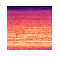

/content/drive/My Drive/sound Classification/fold10/74922-4-0-4.wav 4 drilling /74922-4-0-4 720
/content/drive/My Drive/sound Classification/fold10/74922-4-0-4.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/74922-4-0-4.jpg


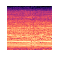

/content/drive/My Drive/sound Classification/fold10/74922-4-0-5.wav 4 drilling /74922-4-0-5 721
/content/drive/My Drive/sound Classification/fold10/74922-4-0-5.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/74922-4-0-5.jpg


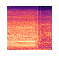

/content/drive/My Drive/sound Classification/fold10/74922-4-0-6.wav 4 drilling /74922-4-0-6 722
/content/drive/My Drive/sound Classification/fold10/74922-4-0-6.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/74922-4-0-6.jpg


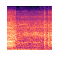

/content/drive/My Drive/sound Classification/fold10/74922-4-0-7.wav 4 drilling /74922-4-0-7 723
/content/drive/My Drive/sound Classification/fold10/74922-4-0-7.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/74922-4-0-7.jpg


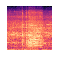

/content/drive/My Drive/sound Classification/fold10/77901-9-0-0.wav 9 street_music /77901-9-0-0 724
/content/drive/My Drive/sound Classification/fold10/77901-9-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/77901-9-0-0.jpg


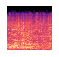

/content/drive/My Drive/sound Classification/fold10/77901-9-0-1.wav 9 street_music /77901-9-0-1 725
/content/drive/My Drive/sound Classification/fold10/77901-9-0-1.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/77901-9-0-1.jpg


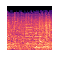

/content/drive/My Drive/sound Classification/fold10/77901-9-0-2.wav 9 street_music /77901-9-0-2 726
/content/drive/My Drive/sound Classification/fold10/77901-9-0-2.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/77901-9-0-2.jpg


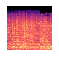

/content/drive/My Drive/sound Classification/fold10/77901-9-0-3.wav 9 street_music /77901-9-0-3 727
/content/drive/My Drive/sound Classification/fold10/77901-9-0-3.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/77901-9-0-3.jpg


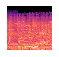

/content/drive/My Drive/sound Classification/fold10/77901-9-0-4.wav 9 street_music /77901-9-0-4 728
/content/drive/My Drive/sound Classification/fold10/77901-9-0-4.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/77901-9-0-4.jpg


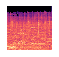

/content/drive/My Drive/sound Classification/fold10/77901-9-0-6.wav 9 street_music /77901-9-0-6 729
/content/drive/My Drive/sound Classification/fold10/77901-9-0-6.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/77901-9-0-6.jpg


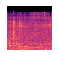

/content/drive/My Drive/sound Classification/fold10/77901-9-0-7.wav 9 street_music /77901-9-0-7 730
/content/drive/My Drive/sound Classification/fold10/77901-9-0-7.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/77901-9-0-7.jpg


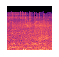

/content/drive/My Drive/sound Classification/fold10/77927-3-0-0.wav 3 dog_bark /77927-3-0-0 731
/content/drive/My Drive/sound Classification/fold10/77927-3-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/77927-3-0-0.jpg


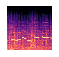

/content/drive/My Drive/sound Classification/fold10/77927-3-0-1.wav 3 dog_bark /77927-3-0-1 732
/content/drive/My Drive/sound Classification/fold10/77927-3-0-1.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/77927-3-0-1.jpg


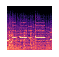

/content/drive/My Drive/sound Classification/fold10/77927-3-0-2.wav 3 dog_bark /77927-3-0-2 733
/content/drive/My Drive/sound Classification/fold10/77927-3-0-2.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/77927-3-0-2.jpg


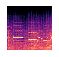

/content/drive/My Drive/sound Classification/fold10/77927-3-1-1.wav 3 dog_bark /77927-3-1-1 734
/content/drive/My Drive/sound Classification/fold10/77927-3-1-1.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/77927-3-1-1.jpg


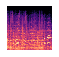

/content/drive/My Drive/sound Classification/fold10/7913-3-0-0.wav 3 dog_bark /7913-3-0-0 735
/content/drive/My Drive/sound Classification/fold10/7913-3-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/7913-3-0-0.jpg


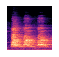

/content/drive/My Drive/sound Classification/fold10/7913-3-1-0.wav 3 dog_bark /7913-3-1-0 736
/content/drive/My Drive/sound Classification/fold10/7913-3-1-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/7913-3-1-0.jpg


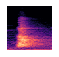

/content/drive/My Drive/sound Classification/fold10/7913-3-2-0.wav 3 dog_bark /7913-3-2-0 737
/content/drive/My Drive/sound Classification/fold10/7913-3-2-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/7913-3-2-0.jpg


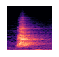

/content/drive/My Drive/sound Classification/fold10/7913-3-3-0.wav 3 dog_bark /7913-3-3-0 738
/content/drive/My Drive/sound Classification/fold10/7913-3-3-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/7913-3-3-0.jpg


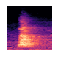

/content/drive/My Drive/sound Classification/fold10/7965-3-11-0.wav 3 dog_bark /7965-3-11-0 739
/content/drive/My Drive/sound Classification/fold10/7965-3-11-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/7965-3-11-0.jpg


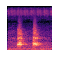

/content/drive/My Drive/sound Classification/fold10/7965-3-16-0.wav 3 dog_bark /7965-3-16-0 740
/content/drive/My Drive/sound Classification/fold10/7965-3-16-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/7965-3-16-0.jpg


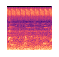

/content/drive/My Drive/sound Classification/fold10/7965-3-22-0.wav 3 dog_bark /7965-3-22-0 741
/content/drive/My Drive/sound Classification/fold10/7965-3-22-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/7965-3-22-0.jpg


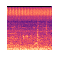

/content/drive/My Drive/sound Classification/fold10/7965-3-3-0.wav 3 dog_bark /7965-3-3-0 742
/content/drive/My Drive/sound Classification/fold10/7965-3-3-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/7965-3-3-0.jpg


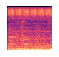

/content/drive/My Drive/sound Classification/fold10/81791-3-0-0.wav 3 dog_bark /81791-3-0-0 743
/content/drive/My Drive/sound Classification/fold10/81791-3-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/81791-3-0-0.jpg


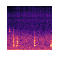

/content/drive/My Drive/sound Classification/fold10/81791-3-0-1.wav 3 dog_bark /81791-3-0-1 744
/content/drive/My Drive/sound Classification/fold10/81791-3-0-1.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/81791-3-0-1.jpg


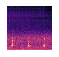

/content/drive/My Drive/sound Classification/fold10/81791-3-1-0.wav 3 dog_bark /81791-3-1-0 745
/content/drive/My Drive/sound Classification/fold10/81791-3-1-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/81791-3-1-0.jpg


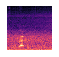

/content/drive/My Drive/sound Classification/fold10/83191-9-0-0.wav 9 street_music /83191-9-0-0 746
/content/drive/My Drive/sound Classification/fold10/83191-9-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/83191-9-0-0.jpg


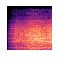

/content/drive/My Drive/sound Classification/fold10/83191-9-0-11.wav 9 street_music /83191-9-0-11 747
/content/drive/My Drive/sound Classification/fold10/83191-9-0-11.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/83191-9-0-11.jpg


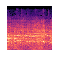

/content/drive/My Drive/sound Classification/fold10/83191-9-0-13.wav 9 street_music /83191-9-0-13 748
/content/drive/My Drive/sound Classification/fold10/83191-9-0-13.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/83191-9-0-13.jpg


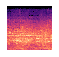

/content/drive/My Drive/sound Classification/fold10/83191-9-0-17.wav 9 street_music /83191-9-0-17 749
/content/drive/My Drive/sound Classification/fold10/83191-9-0-17.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/83191-9-0-17.jpg


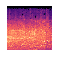

/content/drive/My Drive/sound Classification/fold10/83191-9-0-4.wav 9 street_music /83191-9-0-4 750
/content/drive/My Drive/sound Classification/fold10/83191-9-0-4.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/83191-9-0-4.jpg


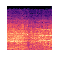

/content/drive/My Drive/sound Classification/fold10/83191-9-0-6.wav 9 street_music /83191-9-0-6 751
/content/drive/My Drive/sound Classification/fold10/83191-9-0-6.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/83191-9-0-6.jpg


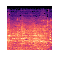

/content/drive/My Drive/sound Classification/fold10/83195-9-0-11.wav 9 street_music /83195-9-0-11 752
/content/drive/My Drive/sound Classification/fold10/83195-9-0-11.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/83195-9-0-11.jpg


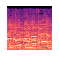

/content/drive/My Drive/sound Classification/fold10/83195-9-0-14.wav 9 street_music /83195-9-0-14 753
/content/drive/My Drive/sound Classification/fold10/83195-9-0-14.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/83195-9-0-14.jpg


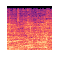

/content/drive/My Drive/sound Classification/fold10/83195-9-0-2.wav 9 street_music /83195-9-0-2 754
/content/drive/My Drive/sound Classification/fold10/83195-9-0-2.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/83195-9-0-2.jpg


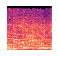

/content/drive/My Drive/sound Classification/fold10/83195-9-0-3.wav 9 street_music /83195-9-0-3 755
/content/drive/My Drive/sound Classification/fold10/83195-9-0-3.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/83195-9-0-3.jpg


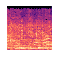

/content/drive/My Drive/sound Classification/fold10/83195-9-0-6.wav 9 street_music /83195-9-0-6 756
/content/drive/My Drive/sound Classification/fold10/83195-9-0-6.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/83195-9-0-6.jpg


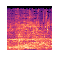

/content/drive/My Drive/sound Classification/fold10/83195-9-0-7.wav 9 street_music /83195-9-0-7 757
/content/drive/My Drive/sound Classification/fold10/83195-9-0-7.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/83195-9-0-7.jpg


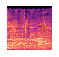

/content/drive/My Drive/sound Classification/fold10/83502-0-0-0.wav 0 air_conditioner /83502-0-0-0 758
/content/drive/My Drive/sound Classification/fold10/83502-0-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/83502-0-0-0.jpg


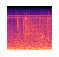

/content/drive/My Drive/sound Classification/fold10/83502-0-0-1.wav 0 air_conditioner /83502-0-0-1 759
/content/drive/My Drive/sound Classification/fold10/83502-0-0-1.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/83502-0-0-1.jpg


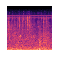

/content/drive/My Drive/sound Classification/fold10/83502-0-0-10.wav 0 air_conditioner /83502-0-0-10 760
/content/drive/My Drive/sound Classification/fold10/83502-0-0-10.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/83502-0-0-10.jpg


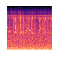

/content/drive/My Drive/sound Classification/fold10/83502-0-0-11.wav 0 air_conditioner /83502-0-0-11 761
/content/drive/My Drive/sound Classification/fold10/83502-0-0-11.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/83502-0-0-11.jpg


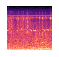

/content/drive/My Drive/sound Classification/fold10/83502-0-0-12.wav 0 air_conditioner /83502-0-0-12 762
/content/drive/My Drive/sound Classification/fold10/83502-0-0-12.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/83502-0-0-12.jpg


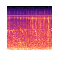

/content/drive/My Drive/sound Classification/fold10/83502-0-0-13.wav 0 air_conditioner /83502-0-0-13 763
/content/drive/My Drive/sound Classification/fold10/83502-0-0-13.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/83502-0-0-13.jpg


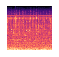

/content/drive/My Drive/sound Classification/fold10/83502-0-0-2.wav 0 air_conditioner /83502-0-0-2 764
/content/drive/My Drive/sound Classification/fold10/83502-0-0-2.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/83502-0-0-2.jpg


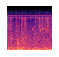

/content/drive/My Drive/sound Classification/fold10/83502-0-0-3.wav 0 air_conditioner /83502-0-0-3 765
/content/drive/My Drive/sound Classification/fold10/83502-0-0-3.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/83502-0-0-3.jpg


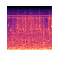

/content/drive/My Drive/sound Classification/fold10/83502-0-0-4.wav 0 air_conditioner /83502-0-0-4 766
/content/drive/My Drive/sound Classification/fold10/83502-0-0-4.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/83502-0-0-4.jpg


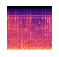

/content/drive/My Drive/sound Classification/fold10/83502-0-0-5.wav 0 air_conditioner /83502-0-0-5 767
/content/drive/My Drive/sound Classification/fold10/83502-0-0-5.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/83502-0-0-5.jpg


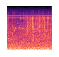

/content/drive/My Drive/sound Classification/fold10/83502-0-0-6.wav 0 air_conditioner /83502-0-0-6 768
/content/drive/My Drive/sound Classification/fold10/83502-0-0-6.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/83502-0-0-6.jpg


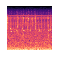

/content/drive/My Drive/sound Classification/fold10/83502-0-0-7.wav 0 air_conditioner /83502-0-0-7 769
/content/drive/My Drive/sound Classification/fold10/83502-0-0-7.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/83502-0-0-7.jpg


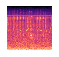

/content/drive/My Drive/sound Classification/fold10/83502-0-0-8.wav 0 air_conditioner /83502-0-0-8 770
/content/drive/My Drive/sound Classification/fold10/83502-0-0-8.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/83502-0-0-8.jpg


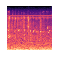

/content/drive/My Drive/sound Classification/fold10/83502-0-0-9.wav 0 air_conditioner /83502-0-0-9 771
/content/drive/My Drive/sound Classification/fold10/83502-0-0-9.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/0_air_conditioner/83502-0-0-9.jpg


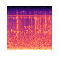

/content/drive/My Drive/sound Classification/fold10/84249-9-0-10.wav 9 street_music /84249-9-0-10 772
/content/drive/My Drive/sound Classification/fold10/84249-9-0-10.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/84249-9-0-10.jpg


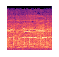

/content/drive/My Drive/sound Classification/fold10/84249-9-0-11.wav 9 street_music /84249-9-0-11 773
/content/drive/My Drive/sound Classification/fold10/84249-9-0-11.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/84249-9-0-11.jpg


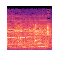

/content/drive/My Drive/sound Classification/fold10/84249-9-0-3.wav 9 street_music /84249-9-0-3 774
/content/drive/My Drive/sound Classification/fold10/84249-9-0-3.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/84249-9-0-3.jpg


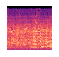

/content/drive/My Drive/sound Classification/fold10/84249-9-0-6.wav 9 street_music /84249-9-0-6 775
/content/drive/My Drive/sound Classification/fold10/84249-9-0-6.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/84249-9-0-6.jpg


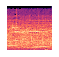

/content/drive/My Drive/sound Classification/fold10/84249-9-0-7.wav 9 street_music /84249-9-0-7 776
/content/drive/My Drive/sound Classification/fold10/84249-9-0-7.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/84249-9-0-7.jpg


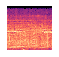

/content/drive/My Drive/sound Classification/fold10/84249-9-0-8.wav 9 street_music /84249-9-0-8 777
/content/drive/My Drive/sound Classification/fold10/84249-9-0-8.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/9_street_music/84249-9-0-8.jpg


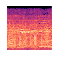

/content/drive/My Drive/sound Classification/fold10/85574-3-0-0.wav 3 dog_bark /85574-3-0-0 778
/content/drive/My Drive/sound Classification/fold10/85574-3-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/85574-3-0-0.jpg


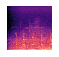

/content/drive/My Drive/sound Classification/fold10/85574-3-0-12.wav 3 dog_bark /85574-3-0-12 779
/content/drive/My Drive/sound Classification/fold10/85574-3-0-12.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/85574-3-0-12.jpg


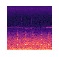

/content/drive/My Drive/sound Classification/fold10/85574-3-0-2.wav 3 dog_bark /85574-3-0-2 780
/content/drive/My Drive/sound Classification/fold10/85574-3-0-2.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/85574-3-0-2.jpg


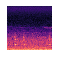

/content/drive/My Drive/sound Classification/fold10/85574-3-0-8.wav 3 dog_bark /85574-3-0-8 781
/content/drive/My Drive/sound Classification/fold10/85574-3-0-8.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/85574-3-0-8.jpg


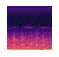

/content/drive/My Drive/sound Classification/fold10/85665-3-0-0.wav 3 dog_bark /85665-3-0-0 782
/content/drive/My Drive/sound Classification/fold10/85665-3-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/85665-3-0-0.jpg


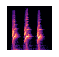

/content/drive/My Drive/sound Classification/fold10/88121-8-0-0.wav 8 siren /88121-8-0-0 783
/content/drive/My Drive/sound Classification/fold10/88121-8-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/88121-8-0-0.jpg


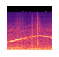

/content/drive/My Drive/sound Classification/fold10/88121-8-0-1.wav 8 siren /88121-8-0-1 784
/content/drive/My Drive/sound Classification/fold10/88121-8-0-1.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/88121-8-0-1.jpg


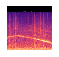

/content/drive/My Drive/sound Classification/fold10/88121-8-0-2.wav 8 siren /88121-8-0-2 785
/content/drive/My Drive/sound Classification/fold10/88121-8-0-2.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/88121-8-0-2.jpg


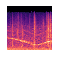

/content/drive/My Drive/sound Classification/fold10/88121-8-0-3.wav 8 siren /88121-8-0-3 786
/content/drive/My Drive/sound Classification/fold10/88121-8-0-3.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/88121-8-0-3.jpg


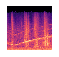

/content/drive/My Drive/sound Classification/fold10/88121-8-1-0.wav 8 siren /88121-8-1-0 787
/content/drive/My Drive/sound Classification/fold10/88121-8-1-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/88121-8-1-0.jpg


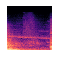

/content/drive/My Drive/sound Classification/fold10/88121-8-2-0.wav 8 siren /88121-8-2-0 788
/content/drive/My Drive/sound Classification/fold10/88121-8-2-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/88121-8-2-0.jpg


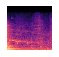

/content/drive/My Drive/sound Classification/fold10/93567-8-0-0.wav 8 siren /93567-8-0-0 789
/content/drive/My Drive/sound Classification/fold10/93567-8-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/93567-8-0-0.jpg


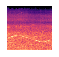

/content/drive/My Drive/sound Classification/fold10/93567-8-0-1.wav 8 siren /93567-8-0-1 790
/content/drive/My Drive/sound Classification/fold10/93567-8-0-1.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/93567-8-0-1.jpg


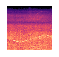

/content/drive/My Drive/sound Classification/fold10/93567-8-0-10.wav 8 siren /93567-8-0-10 791
/content/drive/My Drive/sound Classification/fold10/93567-8-0-10.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/93567-8-0-10.jpg


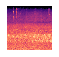

/content/drive/My Drive/sound Classification/fold10/93567-8-0-11.wav 8 siren /93567-8-0-11 792
/content/drive/My Drive/sound Classification/fold10/93567-8-0-11.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/93567-8-0-11.jpg


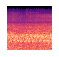

/content/drive/My Drive/sound Classification/fold10/93567-8-0-12.wav 8 siren /93567-8-0-12 793
/content/drive/My Drive/sound Classification/fold10/93567-8-0-12.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/93567-8-0-12.jpg


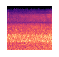

/content/drive/My Drive/sound Classification/fold10/93567-8-0-13.wav 8 siren /93567-8-0-13 794
/content/drive/My Drive/sound Classification/fold10/93567-8-0-13.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/93567-8-0-13.jpg


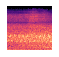

/content/drive/My Drive/sound Classification/fold10/93567-8-0-14.wav 8 siren /93567-8-0-14 795
/content/drive/My Drive/sound Classification/fold10/93567-8-0-14.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/93567-8-0-14.jpg


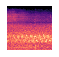

/content/drive/My Drive/sound Classification/fold10/93567-8-0-15.wav 8 siren /93567-8-0-15 796
/content/drive/My Drive/sound Classification/fold10/93567-8-0-15.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/93567-8-0-15.jpg


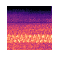

/content/drive/My Drive/sound Classification/fold10/93567-8-0-16.wav 8 siren /93567-8-0-16 797
/content/drive/My Drive/sound Classification/fold10/93567-8-0-16.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/93567-8-0-16.jpg


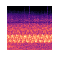

/content/drive/My Drive/sound Classification/fold10/93567-8-0-17.wav 8 siren /93567-8-0-17 798
/content/drive/My Drive/sound Classification/fold10/93567-8-0-17.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/93567-8-0-17.jpg


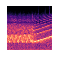

/content/drive/My Drive/sound Classification/fold10/93567-8-0-18.wav 8 siren /93567-8-0-18 799
/content/drive/My Drive/sound Classification/fold10/93567-8-0-18.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/93567-8-0-18.jpg


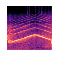

/content/drive/My Drive/sound Classification/fold10/93567-8-0-19.wav 8 siren /93567-8-0-19 800
/content/drive/My Drive/sound Classification/fold10/93567-8-0-19.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/93567-8-0-19.jpg


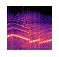

/content/drive/My Drive/sound Classification/fold10/93567-8-0-2.wav 8 siren /93567-8-0-2 801
/content/drive/My Drive/sound Classification/fold10/93567-8-0-2.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/93567-8-0-2.jpg


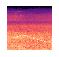

/content/drive/My Drive/sound Classification/fold10/93567-8-0-3.wav 8 siren /93567-8-0-3 802
/content/drive/My Drive/sound Classification/fold10/93567-8-0-3.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/93567-8-0-3.jpg


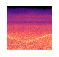

/content/drive/My Drive/sound Classification/fold10/93567-8-0-4.wav 8 siren /93567-8-0-4 803
/content/drive/My Drive/sound Classification/fold10/93567-8-0-4.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/93567-8-0-4.jpg


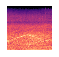

/content/drive/My Drive/sound Classification/fold10/93567-8-0-5.wav 8 siren /93567-8-0-5 804
/content/drive/My Drive/sound Classification/fold10/93567-8-0-5.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/93567-8-0-5.jpg


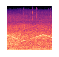

/content/drive/My Drive/sound Classification/fold10/93567-8-0-6.wav 8 siren /93567-8-0-6 805
/content/drive/My Drive/sound Classification/fold10/93567-8-0-6.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/93567-8-0-6.jpg


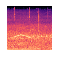

/content/drive/My Drive/sound Classification/fold10/93567-8-0-7.wav 8 siren /93567-8-0-7 806
/content/drive/My Drive/sound Classification/fold10/93567-8-0-7.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/93567-8-0-7.jpg


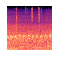

/content/drive/My Drive/sound Classification/fold10/93567-8-0-8.wav 8 siren /93567-8-0-8 807
/content/drive/My Drive/sound Classification/fold10/93567-8-0-8.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/93567-8-0-8.jpg


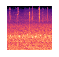

/content/drive/My Drive/sound Classification/fold10/93567-8-0-9.wav 8 siren /93567-8-0-9 808
/content/drive/My Drive/sound Classification/fold10/93567-8-0-9.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/8_siren/93567-8-0-9.jpg


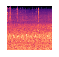

/content/drive/My Drive/sound Classification/fold10/97756-3-0-0.wav 3 dog_bark /97756-3-0-0 809
/content/drive/My Drive/sound Classification/fold10/97756-3-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/3_dog_bark/97756-3-0-0.jpg


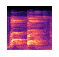

/content/drive/My Drive/sound Classification/fold10/99192-4-0-0.wav 4 drilling /99192-4-0-0 810
/content/drive/My Drive/sound Classification/fold10/99192-4-0-0.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/99192-4-0-0.jpg


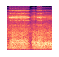

/content/drive/My Drive/sound Classification/fold10/99192-4-0-1.wav 4 drilling /99192-4-0-1 811
/content/drive/My Drive/sound Classification/fold10/99192-4-0-1.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/99192-4-0-1.jpg


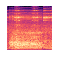

/content/drive/My Drive/sound Classification/fold10/99192-4-0-12.wav 4 drilling /99192-4-0-12 812
/content/drive/My Drive/sound Classification/fold10/99192-4-0-12.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/99192-4-0-12.jpg


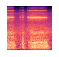

/content/drive/My Drive/sound Classification/fold10/99192-4-0-15.wav 4 drilling /99192-4-0-15 813
/content/drive/My Drive/sound Classification/fold10/99192-4-0-15.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/99192-4-0-15.jpg


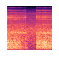

/content/drive/My Drive/sound Classification/fold10/99192-4-0-17.wav 4 drilling /99192-4-0-17 814
/content/drive/My Drive/sound Classification/fold10/99192-4-0-17.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/99192-4-0-17.jpg


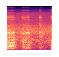

/content/drive/My Drive/sound Classification/fold10/99192-4-0-18.wav 4 drilling /99192-4-0-18 815
/content/drive/My Drive/sound Classification/fold10/99192-4-0-18.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/99192-4-0-18.jpg


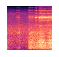

/content/drive/My Drive/sound Classification/fold10/99192-4-0-20.wav 4 drilling /99192-4-0-20 816
/content/drive/My Drive/sound Classification/fold10/99192-4-0-20.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/99192-4-0-20.jpg


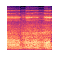

/content/drive/My Drive/sound Classification/fold10/99192-4-0-24.wav 4 drilling /99192-4-0-24 817
/content/drive/My Drive/sound Classification/fold10/99192-4-0-24.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/99192-4-0-24.jpg


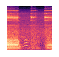

/content/drive/My Drive/sound Classification/fold10/99192-4-0-26.wav 4 drilling /99192-4-0-26 818
/content/drive/My Drive/sound Classification/fold10/99192-4-0-26.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/99192-4-0-26.jpg


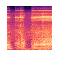

/content/drive/My Drive/sound Classification/fold10/99192-4-0-27.wav 4 drilling /99192-4-0-27 819
/content/drive/My Drive/sound Classification/fold10/99192-4-0-27.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/99192-4-0-27.jpg


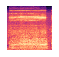

/content/drive/My Drive/sound Classification/fold10/99192-4-0-28.wav 4 drilling /99192-4-0-28 820
/content/drive/My Drive/sound Classification/fold10/99192-4-0-28.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/99192-4-0-28.jpg


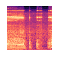

/content/drive/My Drive/sound Classification/fold10/99192-4-0-3.wav 4 drilling /99192-4-0-3 821
/content/drive/My Drive/sound Classification/fold10/99192-4-0-3.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/99192-4-0-3.jpg


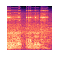

/content/drive/My Drive/sound Classification/fold10/99192-4-0-30.wav 4 drilling /99192-4-0-30 822
/content/drive/My Drive/sound Classification/fold10/99192-4-0-30.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/99192-4-0-30.jpg


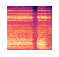

/content/drive/My Drive/sound Classification/fold10/99192-4-0-32.wav 4 drilling /99192-4-0-32 823
/content/drive/My Drive/sound Classification/fold10/99192-4-0-32.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/99192-4-0-32.jpg


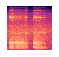

/content/drive/My Drive/sound Classification/fold10/99192-4-0-33.wav 4 drilling /99192-4-0-33 824
/content/drive/My Drive/sound Classification/fold10/99192-4-0-33.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/99192-4-0-33.jpg


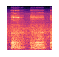

/content/drive/My Drive/sound Classification/fold10/99192-4-0-38.wav 4 drilling /99192-4-0-38 825
/content/drive/My Drive/sound Classification/fold10/99192-4-0-38.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/99192-4-0-38.jpg


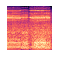

/content/drive/My Drive/sound Classification/fold10/99192-4-0-40.wav 4 drilling /99192-4-0-40 826
/content/drive/My Drive/sound Classification/fold10/99192-4-0-40.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/99192-4-0-40.jpg


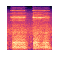

/content/drive/My Drive/sound Classification/fold10/99192-4-0-41.wav 4 drilling /99192-4-0-41 827
/content/drive/My Drive/sound Classification/fold10/99192-4-0-41.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/99192-4-0-41.jpg


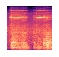

/content/drive/My Drive/sound Classification/fold10/99192-4-0-43.wav 4 drilling /99192-4-0-43 828
/content/drive/My Drive/sound Classification/fold10/99192-4-0-43.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/99192-4-0-43.jpg


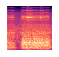

/content/drive/My Drive/sound Classification/fold10/99192-4-0-47.wav 4 drilling /99192-4-0-47 829
/content/drive/My Drive/sound Classification/fold10/99192-4-0-47.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/99192-4-0-47.jpg


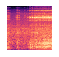

/content/drive/My Drive/sound Classification/fold10/99192-4-0-48.wav 4 drilling /99192-4-0-48 830
/content/drive/My Drive/sound Classification/fold10/99192-4-0-48.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/99192-4-0-48.jpg


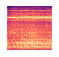

/content/drive/My Drive/sound Classification/fold10/99192-4-0-49.wav 4 drilling /99192-4-0-49 831
/content/drive/My Drive/sound Classification/fold10/99192-4-0-49.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/99192-4-0-49.jpg


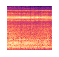

/content/drive/My Drive/sound Classification/fold10/99192-4-0-52.wav 4 drilling /99192-4-0-52 832
/content/drive/My Drive/sound Classification/fold10/99192-4-0-52.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/99192-4-0-52.jpg


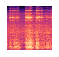

/content/drive/My Drive/sound Classification/fold10/99192-4-0-53.wav 4 drilling /99192-4-0-53 833
/content/drive/My Drive/sound Classification/fold10/99192-4-0-53.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/99192-4-0-53.jpg


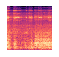

/content/drive/My Drive/sound Classification/fold10/99192-4-0-54.wav 4 drilling /99192-4-0-54 834
/content/drive/My Drive/sound Classification/fold10/99192-4-0-54.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/99192-4-0-54.jpg


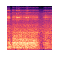

/content/drive/My Drive/sound Classification/fold10/99192-4-0-55.wav 4 drilling /99192-4-0-55 835
/content/drive/My Drive/sound Classification/fold10/99192-4-0-55.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/99192-4-0-55.jpg


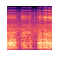

/content/drive/My Drive/sound Classification/fold10/99192-4-0-7.wav 4 drilling /99192-4-0-7 836
/content/drive/My Drive/sound Classification/fold10/99192-4-0-7.wav
/content/drive/My Drive/sound Classification/
/content/drive/My Drive/sound Classification/images/Test/4_drilling/99192-4-0-7.jpg


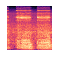

In [17]:
#get test items from fold10
init_data(csv_path, filepath, range(10,11))
get_test_items(10)
